In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import clear_output
from tqdm.notebook import tqdm
import os
from pathlib import Path

import torch
import numpy as np

import cv2
import matplotlib.pyplot as plt

In [2]:
PYTHON_PATHS = ["../.."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
        

from imap.utils import UniversalFactory
from pytorch_lightning.utilities.parsing import AttributeDict
from imap.data.datasets.tum.tum_dataset_loader_factory import TUMDatasetLoaderFactory
from imap.model.nerf import NERF
from imap.model.embeddings.gaussian_positional_encoding import GaussianPositionalEncoding
from imap.model.embeddings.gaussian_positional_embedding import GaussianPositionalEmbedding
from imap.trainers.trainers import ModelTrainer
from imap.model.active_sampling.image_active_sampling import ImageActiveSampling
from imap.utils.utils import *

In [3]:
image_width = 640
image_height = 480
points_per_image = int(200)
num_epochs = 300
is_image_active_sampling = True



def train_model(model, dataset_loader, camera, trainer, num_epochs, is_image_active_sampling, verbose_step=5):
    for i in tqdm(range(num_epochs)):
        # train the model
        for color_image, depth_image, position in dataset_loader:
            state = camera.create_state(color_image, depth_image, position)
            loss = trainer.train(model, state, is_image_active_sampling)
            load_last_state = True

        # trainer.reset_params()

        if i%verbose_step == 0:
            print(f"loss {torch.mean(loss['loss']).item()}")
        # clear_output(wait=True)

    torch.cuda.empty_cache()

def render_images(model, camera, dataset_loader, image_height=image_height, image_width=image_width):
    # prepare image coordinates

    scale = 1
    height = image_height
    width = image_width
    x, y = generate_image_meshgrid(width, height, scale)
    np_pixels = get_ji_pixels_from_meshgrid(x, y, scale)


    # positions for rendering
    # TODO: manually generate positions
    positions = []
    for _, _, position in dataset_loader:
        positions.append(camera.process_positions(position))


    # reder the image

    batch_size = 4096

    model = model.cuda()
    model.eval()


    pixels = torch.from_numpy(np_pixels.copy()).cuda()

    color_coarse_images = []
    depth_coarse_images =[]
    color_fine_images = []
    depth_fine_images = []

    mean = camera._color_mean
    std = camera._color_std

    with torch.no_grad():
        for pos in positions:
            position = torch.from_numpy(pos).to('cuda')
            output_coarse_color = []
            output_coarse_depth = []
            output_fine_color = []
            output_fine_depth = []

            for i in tqdm(range(int(np.ceil(pixels.shape[0] / batch_size)))):
                output = model(pixels[i * batch_size : i * batch_size + batch_size],
                                     position)
                output_coarse_color.append(output[0])
                output_coarse_depth.append(output[1])
                output_fine_color.append(output[2])
                output_fine_depth.append(output[3])

            reconstructed_image = reshape_points_list_to_image(output_coarse_color,height, width, scale).detach().cpu().numpy()
            reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
            reconstructed_image = np.clip(reconstructed_image / 255., 0, 1).astype(np.float32)
            color_coarse_images.append(reconstructed_image)

            reconstructed_image = reshape_points_list_to_image(output_fine_color,height, width, scale).detach().cpu().numpy()
            reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
            reconstructed_image = np.clip(reconstructed_image / 255., 0, 1).astype(np.float32)
            color_fine_images.append(reconstructed_image)

            reconstructed_depth = torch.cat(output_coarse_depth, dim=0).reshape(480 // scale, 640 // scale).detach().cpu().numpy()
            depth_coarse_images.append(reconstructed_depth)


            reconstructed_depth = torch.cat(output_fine_depth, dim=0).reshape(480 // scale, 640 // scale).detach().cpu().numpy()
            depth_fine_images.append(reconstructed_depth)

    del output_coarse_color, output_coarse_depth, output_fine_color, output_fine_depth, position, pixels
    torch.cuda.empty_cache()
    return color_coarse_images, depth_coarse_images, color_fine_images, depth_fine_images

In [4]:
import plotly.graph_objects as go
def show_trajectories(shown_truth_trajectory, shown_predicted_trajectory):
    fig = go.Figure(
        data=[
            go.Scatter3d(x=shown_truth_trajectory[:, 0],
                         y=shown_truth_trajectory[:, 1], 
                         z=shown_truth_trajectory[:, 2],
                         mode="markers",
                         name="truth",
                         marker={
                             "size": 2
                         }),
            go.Scatter3d(x=shown_predicted_trajectory[:, 0],
                         y=shown_predicted_trajectory[:, 1],
                         z=shown_predicted_trajectory[:, 2],
                         mode="markers",
                         name="predicted",
                         marker={
                             "size": 2
                         }),
            go.Scatter3d(x=make_lines(shown_truth_trajectory[:, 0], shown_predicted_trajectory[:, 0]),
                         y=make_lines(shown_truth_trajectory[:, 1], shown_predicted_trajectory[:, 1]),
                         z=make_lines(shown_truth_trajectory[:, 2], shown_predicted_trajectory[:, 2]),
                         mode="lines",
                         name="errors")
        ]
    )
    fig.update_layout(height=1280,width=960)
    fig.show()
    
    



def make_lines(markers1, markers2):
    result = []
    for x1, x2 in zip(markers1, markers2):
        result.append(x1)
        result.append(x2)
        result.append(None)
    return result

def make_matrix_44_from_34(matrix):
    result = np.zeros((matrix.shape[0], 4, 4))
    result[:, 3, 3] = 1
    result[:, :3, :] = matrix
    return result

# Track a few images

### Train on 1 image

In [5]:
len([*range(0,100,5)])

20

In [6]:

dataset_params = {'dataset_path': "/home/quetalasj/datasets/TUM RGBD/", 
                  'scene_name': "rgbd_dataset_freiburg1_desk", 
                  'association_file_name': "data_association_file.txt", 
                  'frame_indices': [*range(0,573,10)],
                  'distance_koef': 0.1,
                  'clip_distance_threshold': 4.}
camera, dataset_loader = TUMDatasetLoaderFactory.make_dataset_loader(**dataset_params)

Reading /home/quetalasj/datasets/TUM RGBD/rgbd_dataset_freiburg1_desk/data_association_file.txt


In [7]:
model_parameters = AttributeDict(
    name="NERF",
    course_sample_bins=32,
    fine_sample_bins=12,
    depth_loss_koef=1.,
    color_loss_koef=5.,
    minimal_depth=0.01,
    positional_embedding = AttributeDict(
                                        name = 'GaussianPositionalEmbedding',
                                        encoding_dimension=93,
                                        sigma=25,
                                        use_only_sin=False,
                                        use_bias=True
                                        )
)

factory = UniversalFactory([NERF, GaussianPositionalEncoding, GaussianPositionalEmbedding])
model = factory.make_from_parameters(model_parameters, camera_info=camera)

In [8]:
model.cuda()
model.train()

image_active_sampler = ImageActiveSampling(image_width, image_height, points_per_image)
trainer = ModelTrainer(model.parameters(), image_active_sampler, lr=0.005)

train_model(model, dataset_loader, camera, trainer, 300, is_image_active_sampling=True)

  0%|          | 0/300 [00:00<?, ?it/s]

loss 1.4404034614562988
loss 1.3973159790039062
loss 1.4661104679107666
loss 1.2643301486968994
loss 1.3371529579162598
loss 1.3119404315948486
loss 1.1713347434997559
loss 1.1959301233291626
loss 1.2637076377868652
loss 1.26503324508667
loss 1.008554458618164
loss 1.0801875591278076
loss 1.0110701322555542
loss 0.9374769330024719
loss 0.889677107334137
loss 0.8640365600585938
loss 0.9043884873390198
loss 0.8668668270111084
loss 0.9340632557868958
loss 0.8256176710128784
loss 0.9101132750511169
loss 0.860380232334137
loss 0.7825803160667419
loss 0.84225994348526
loss 0.8167023062705994
loss 0.8747609257698059
loss 0.825664222240448
loss 0.7241165637969971
loss 0.7636049389839172
loss 0.7083062529563904
loss 0.7624848484992981
loss 0.7376012802124023
loss 0.7106888294219971
loss 0.7736203074455261
loss 0.8217481970787048
loss 0.7014605402946472
loss 0.6653720140457153
loss 0.6327235698699951
loss 0.7480292320251465
loss 0.6185984015464783
loss 0.7383334040641785
loss 0.7853222489356995


In [9]:
model.eval()
color_coarse_images, depth_coarse_images, color_fine_images, depth_fine_images = render_images(model, camera, dataset_loader)

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

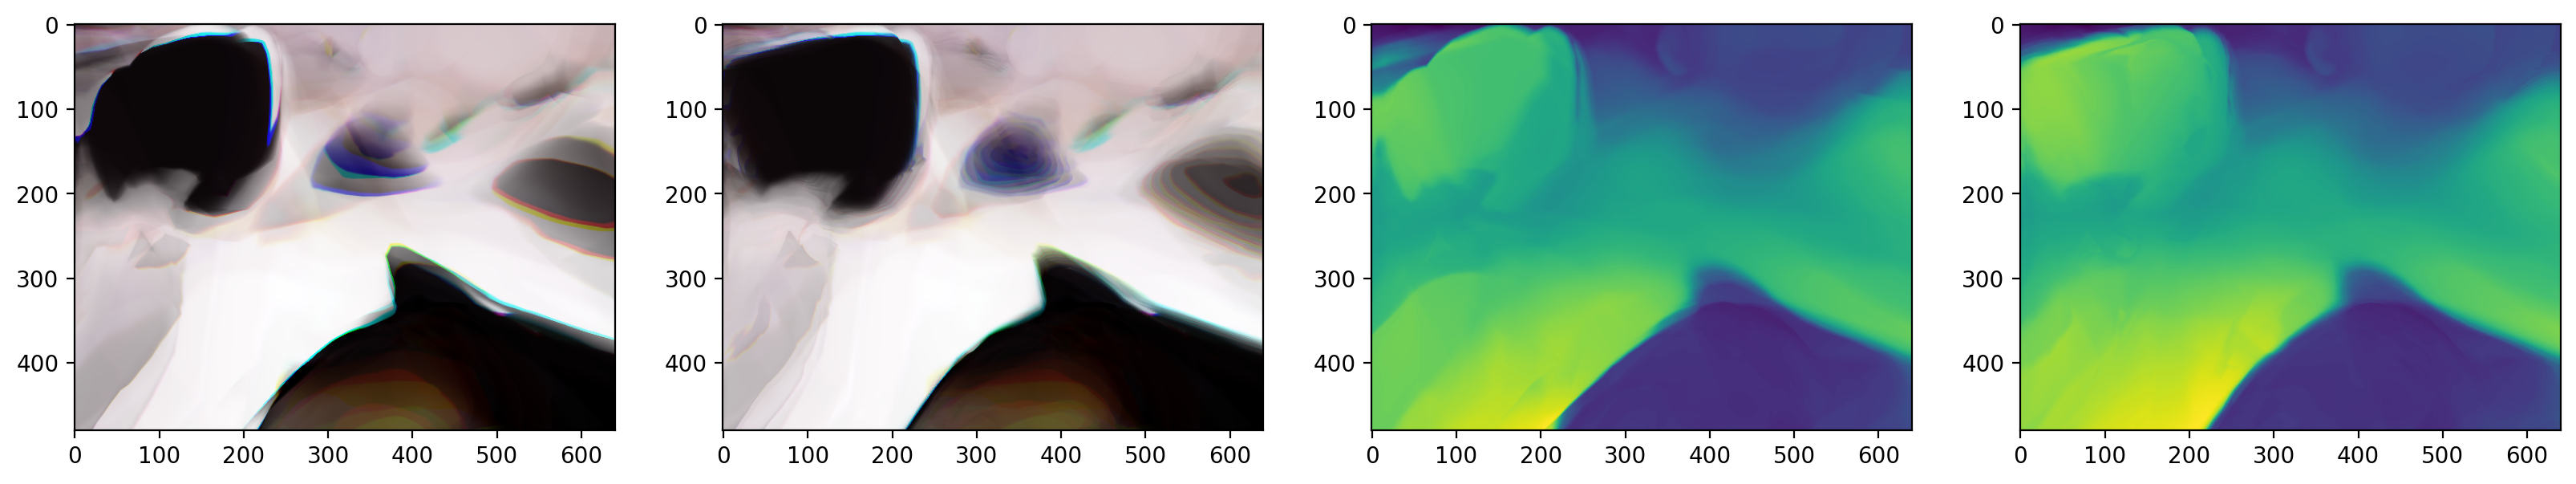

In [10]:
indx = 0
figure = plt.figure(dpi=200, figsize=(20,18))
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(color_coarse_images[indx], cv2.COLOR_RGB2BGR))


plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(color_fine_images[indx], cv2.COLOR_RGB2BGR))

plt.subplot(1,4,3)
plt.imshow(1. /depth_coarse_images[indx])


plt.subplot(1,4,4)
plt.imshow(1. /depth_fine_images[indx])

### Tracking

In [11]:
dataset_params = {'dataset_path': "/home/quetalasj/datasets/TUM RGBD/", 
                  'scene_name': "rgbd_dataset_freiburg1_desk", 
                  'association_file_name': "data_association_file.txt", 
                  'frame_indices': [*range(573)],
                  'distance_koef': 0.1,
                  'clip_distance_threshold': 4.}
camera, tracking_dataset_loader = TUMDatasetLoaderFactory.make_dataset_loader(**dataset_params)

Reading /home/quetalasj/datasets/TUM RGBD/rgbd_dataset_freiburg1_desk/data_association_file.txt


In [12]:
poses = trainer.localization(model, tracking_dataset_loader, camera)

[[ 0.8722986   0.4882979   0.02569568  0.        ]
 [ 0.34789497 -0.58283824 -0.73434913  0.        ]
 [-0.34360474  0.64951116 -0.67828536  0.        ]
 [ 1.3112      0.8507      1.5186      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7551529407501221
loss 0.93452388048172
loss 0.8044238090515137
loss 0.7123964428901672
loss 0.7662928700447083
----------
[[ 0.8694768   0.49363816  0.01820865  0.        ]
 [ 0.34114742 -0.5734097  -0.7448624   0.        ]
 [-0.35725144  0.6538524  -0.66696966  0.        ]
 [ 0.13269573  0.08321883  0.15254182  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8153330683708191
loss 0.7085026502609253
loss 0.7384921312332153
loss 0.806340217590332
loss 0.8185147047042847
----------
[[ 0.876573    0.48123404  0.00579266  0.        ]
 [ 0.3250229  -0.5830704  -0.7445732   0.        ]
 [-0.35493642  0.6545555  -0.66751575  0.        ]
 [ 0.13509017  0.08433628  0.1519945   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6004416346549988
loss 0.7843056321144104
loss 0.7258235216140747
loss 0.7303571105003357
loss 0.7069862484931946
----------
[[ 0.8856327   0.46437326 -0.00349808  0.        ]
 [ 0.3068463  -0.5908247  -0.7461712   0.        ]
 [-0.34856868  0.6597602  -0.665745    0.        ]
 [ 0.13320206  0.08258353  0.15172711  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7678084373474121
loss 0.7157147526741028
loss 0.7405198216438293
loss 1.2334918975830078
loss 0.8294821977615356
----------
[[ 0.8943436   0.447379    0.00123306  0.        ]
 [ 0.29692054 -0.5914998  -0.74964386  0.        ]
 [-0.33464557  0.6708053  -0.6618403   0.        ]
 [ 0.13360994  0.08126715  0.1518818   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9449191093444824
loss 0.8754411339759827
loss 0.8339434862136841
loss 0.7468483448028564
loss 0.6535340547561646
----------
[[ 0.9076809   0.41965896 -0.00130662  0.        ]
 [ 0.27452195 -0.5961132  -0.7545111   0.        ]
 [-0.31741622  0.68449664 -0.65628624  0.        ]
 [ 0.13531177  0.08194564  0.15394124  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.838162899017334
loss 0.8090322017669678
loss 0.7064440846443176
loss 0.710953414440155
loss 0.7002890110015869
----------
[[ 0.91714007  0.3985414  -0.00433944  0.        ]
 [ 0.2541631  -0.5932082  -0.7638753   0.        ]
 [-0.30701005  0.69947773 -0.6453494   0.        ]
 [ 0.13551359  0.07903627  0.15360558  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8367661237716675
loss 0.8283801078796387
loss 0.6721088886260986
loss 0.7259620428085327
loss 0.8164829611778259
----------
[[ 0.91941065  0.39325118 -0.00612673  0.        ]
 [ 0.24433857 -0.58332527 -0.77461624  0.        ]
 [-0.3081926   0.7106935  -0.63240194  0.        ]
 [ 0.132188    0.0792525   0.1606149   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.5468218326568604
loss 0.6971127390861511
loss 0.9830254912376404
loss 0.7982215881347656
loss 0.780790388584137
----------
[[ 0.9233849   0.3837255  -0.01072927  0.        ]
 [ 0.23353073 -0.58370495 -0.77765805  0.        ]
 [-0.30466992  0.71557206 -0.62859595  0.        ]
 [ 0.13681374  0.07575312  0.15582554  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9971450567245483
loss 1.0072234869003296
loss 0.6520917415618896
loss 0.902765691280365
loss 0.7544028162956238
----------
[[ 0.92586386  0.37736315 -0.01931928  0.        ]
 [ 0.22104257 -0.5823796  -0.7822879   0.        ]
 [-0.30645776  0.72002167 -0.6226175   0.        ]
 [ 0.13418077  0.07661547  0.15789033  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7133538722991943
loss 0.6963016390800476
loss 0.6483693718910217
loss 0.7053440809249878
loss 0.8842517137527466
----------
[[ 0.9229857   0.3838633  -0.02732114  0.        ]
 [ 0.21467665 -0.5725024  -0.7912994   0.        ]
 [-0.31939226  0.7244927  -0.6108179   0.        ]
 [ 0.1386622   0.07630502  0.15778363  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7613949179649353
loss 0.6912243366241455
loss 0.7292420864105225
loss 0.7570657730102539
loss 0.7456001043319702
----------
[[ 0.91792285  0.39548483 -0.0317708   0.        ]
 [ 0.21542642 -0.5640441  -0.7971486   0.        ]
 [-0.33318028  0.72487664 -0.602947    0.        ]
 [ 0.13928829  0.07419652  0.15941486  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7963203191757202
loss 0.6884297132492065
loss 0.7378464937210083
loss 1.714908242225647
loss 0.8259207606315613
----------
[[ 0.91060454  0.4123124  -0.0282464   0.        ]
 [ 0.2249886  -0.55190444 -0.8029829   0.        ]
 [-0.34666914  0.7248448  -0.59533215  0.        ]
 [ 0.13631229  0.07251047  0.15951069  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8056468963623047
loss 0.8667704463005066
loss 0.773340106010437
loss 0.792012631893158
loss 0.8220893740653992
----------
[[ 0.89885575  0.43682665 -0.0352253   0.        ]
 [ 0.23168474 -0.54188406 -0.80788875  0.        ]
 [-0.3719953   0.71801424 -0.58828163  0.        ]
 [ 0.13938637  0.07125368  0.15983716  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8378715515136719
loss 0.7507521510124207
loss 0.8509721755981445
loss 1.0055515766143799
loss 0.8170275688171387
----------
[[ 0.8873871   0.4593103  -0.03972626  0.        ]
 [ 0.23807202 -0.53033066 -0.8136774   0.        ]
 [-0.3947985   0.7125891  -0.5799575   0.        ]
 [ 0.13947691  0.07035583  0.16056523  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.928046703338623
loss 0.8130726218223572
loss 0.8356037139892578
loss 0.9089630842208862
loss 0.7217402458190918
----------
[[ 0.8790821   0.4743287  -0.04719098  0.        ]
 [ 0.24037898 -0.52662325 -0.81540513  0.        ]
 [-0.411622    0.70546424 -0.5769638   0.        ]
 [ 0.13998473  0.06892164  0.15960923  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8872625827789307
loss 0.8122317790985107
loss 0.8315216898918152
loss 0.9881821870803833
loss 0.8541037440299988
----------
[[ 0.8709047   0.48916507 -0.04735516  0.        ]
 [ 0.24832523 -0.5211625  -0.8165316   0.        ]
 [-0.4240985   0.69936174 -0.57535493  0.        ]
 [ 0.14241514  0.06662358  0.15797232  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3384246826171875
loss 1.3236737251281738
loss 0.8918532133102417
loss 0.9560253620147705
loss 0.9502026438713074
----------
[[ 0.86108154  0.5063135  -0.04674672  0.        ]
 [ 0.25745583 -0.51343167 -0.8185992   0.        ]
 [-0.43846905  0.69284546 -0.57245994  0.        ]
 [ 0.13786477  0.06461222  0.158787    1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2008616924285889
loss 0.8013429641723633
loss 0.7664830088615417
loss 0.7404377460479736
loss 0.8192611336708069
----------
[[ 0.84073395  0.5375905  -0.0645206   0.        ]
 [ 0.26289278 -0.5094725  -0.8193445   0.        ]
 [-0.47334325  0.6718887  -0.5696595   0.        ]
 [ 0.13389537  0.06111905  0.16195175  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9978185296058655
loss 0.9951297044754028
loss 1.110090970993042
loss 0.9432337880134583
loss 0.935892641544342
----------
[[ 0.8178189   0.57099515 -0.07167134  0.        ]
 [ 0.27786607 -0.5008687  -0.8197077   0.        ]
 [-0.50394714  0.65045744 -0.5682802   0.        ]
 [ 0.13737798  0.05760939  0.16088934  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9641181826591492
loss 0.9326354265213013
loss 0.8157650828361511
loss 1.0281797647476196
loss 0.96461021900177
----------
[[ 0.80286646  0.5915673  -0.07384887  0.        ]
 [ 0.2945069  -0.5012708  -0.8136298   0.        ]
 [-0.518335    0.6314871  -0.5766742   0.        ]
 [ 0.13627298  0.058251    0.15867496  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2449493408203125
loss 1.2441880702972412
loss 1.1194899082183838
loss 0.7963110208511353
loss 0.9570063352584839
----------
[[ 0.7837362   0.6180136  -0.06177914  0.        ]
 [ 0.3141414  -0.480245   -0.8189503   0.        ]
 [-0.53579164  0.62243354 -0.5705291   0.        ]
 [ 0.13845149  0.05768835  0.15959564  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1592377424240112
loss 1.0181210041046143
loss 0.8866841197013855
loss 0.8718931674957275
loss 0.8882107138633728
----------
[[ 0.7548565   0.6522795  -0.06872451  0.        ]
 [ 0.3274185  -0.46553922 -0.822235    0.        ]
 [-0.568321    0.5981678  -0.5649836   0.        ]
 [ 0.13554439  0.05782901  0.15951203  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.031638264656067
loss 1.2297056913375854
loss 0.9964207410812378
loss 0.8186945915222168
loss 0.974267840385437
----------
[[ 0.7388459   0.6712303  -0.05963746  0.        ]
 [ 0.3459728  -0.4537865  -0.8212067   0.        ]
 [-0.5782815   0.58611226 -0.5675057   0.        ]
 [ 0.13176602  0.05717068  0.16231456  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.019815444946289
loss 0.9611994624137878
loss 1.0074423551559448
loss 0.9430894255638123
loss 0.8365757465362549
----------
[[ 0.7025949   0.7097802  -0.05071932  0.        ]
 [ 0.36766025 -0.42311466 -0.82813036  0.        ]
 [-0.60925066  0.5631927  -0.5582361   0.        ]
 [ 0.13439938  0.0577157   0.16083024  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.230107069015503
loss 1.0257025957107544
loss 1.07145094871521
loss 1.2161412239074707
loss 0.9936350584030151
----------
[[ 0.6667853   0.74311876 -0.05632007  0.        ]
 [ 0.3807932  -0.40468872 -0.83139855  0.        ]
 [-0.64061993  0.53291804 -0.5528151   0.        ]
 [ 0.14029549  0.05620817  0.15795392  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.9553970098495483
loss 1.3896398544311523
loss 1.0211623907089233
loss 0.9718541502952576
loss 1.0119097232818604
----------
[[ 0.63626003  0.77033746 -0.0418714   0.        ]
 [ 0.40813753 -0.3821653  -0.82907975  0.        ]
 [-0.6546731   0.51042104 -0.5575602   0.        ]
 [ 0.13289429  0.05503356  0.15996216  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2763358354568481
loss 0.9493656754493713
loss 1.1037019491195679
loss 1.1196316480636597
loss 0.9839167594909668
----------
[[ 0.5998538   0.7997809  -0.0229325   0.        ]
 [ 0.43489784 -0.3499732  -0.8296883   0.        ]
 [-0.6715946   0.48771837 -0.5577557   0.        ]
 [ 0.13244535  0.05316545  0.16135165  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1303480863571167
loss 0.983757734298706
loss 1.1985582113265991
loss 1.0112618207931519
loss 0.9601729512214661
----------
[[ 0.56521297  0.8249013  -0.00849548  0.        ]
 [ 0.45787567 -0.3222643  -0.8285503   0.        ]
 [-0.6862099   0.46441752 -0.5598502   0.        ]
 [ 0.12879741  0.05393816  0.15898259  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.048959732055664
loss 1.0480738878250122
loss 1.1315854787826538
loss 1.0903034210205078
loss 0.9023441672325134
----------
[[ 5.4833078e-01  8.3626151e-01 -4.6673417e-04  0.0000000e+00]
 [ 4.6683145e-01 -3.0656135e-01 -8.2951134e-01  0.0000000e+00]
 [-6.9383132e-01  4.5462877e-01 -5.5849016e-01  0.0000000e+00]
 [ 1.3238560e-01  5.4158922e-02  1.6004664e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3273931741714478
loss 0.8845612406730652
loss 1.0938720703125
loss 0.9731358289718628
loss 0.9042737483978271
----------
[[ 0.51675     0.85605514  0.01178911  0.        ]
 [ 0.48092675 -0.27885985 -0.83123195  0.        ]
 [-0.70829284  0.4352088  -0.5558007   0.        ]
 [ 0.12923887  0.05068506  0.15895161  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9473781585693359
loss 0.9314134120941162
loss 1.0274492502212524
loss 0.8671545386314392
loss 1.0726451873779297
----------
[[ 0.49661535  0.8673967   0.03155971  0.        ]
 [ 0.4912164  -0.25088966 -0.8341228   0.        ]
 [-0.7155974   0.4297408  -0.55067515  0.        ]
 [ 0.12980317  0.04913193  0.15998179  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.988737165927887
loss 1.045331358909607
loss 1.0282049179077148
loss 0.8494189977645874
loss 0.9759652614593506
----------
[[ 0.4647979   0.88509226  0.02396795  0.        ]
 [ 0.49770167 -0.23878336 -0.83383167  0.        ]
 [-0.7322949   0.39949214 -0.55149806  0.        ]
 [ 0.1286037   0.05019844  0.15722159  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1196144819259644
loss 0.9990178346633911
loss 0.8663861155509949
loss 0.9890328645706177
loss 0.957283616065979
----------
[[ 0.44213676  0.89610684  0.03882745  0.        ]
 [ 0.50525033 -0.2130549  -0.83625937  0.        ]
 [-0.74110544  0.3893586  -0.54695773  0.        ]
 [ 0.12957142  0.04951145  0.1603065   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1571167707443237
loss 1.0899020433425903
loss 0.8749023079872131
loss 0.8814416527748108
loss 0.7910751104354858
----------
[[ 0.40404713  0.91322803  0.05253991  0.        ]
 [ 0.5255562  -0.18474841 -0.830457    0.        ]
 [-0.7486899   0.36315653 -0.55459976  0.        ]
 [ 0.12954241  0.04767169  0.15942498  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.018668293952942
loss 1.0913013219833374
loss 1.0918793678283691
loss 1.0125622749328613
loss 1.1699984073638916
----------
[[ 0.3665889   0.92729205  0.0757764   0.        ]
 [ 0.5407234  -0.14606869 -0.8284215   0.        ]
 [-0.7571201   0.34466422 -0.5549556   0.        ]
 [ 0.1252758   0.04770696  0.15937984  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0334458351135254
loss 0.8958948850631714
loss 0.9577468633651733
loss 0.9333873391151428
loss 0.9492847919464111
----------
[[ 0.3454545   0.93447185  0.08616024  0.        ]
 [ 0.5470089  -0.12591076 -0.8276036   0.        ]
 [-0.7625237   0.33302978 -0.5546608   0.        ]
 [ 0.13048401  0.04545779  0.1592797   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0898308753967285
loss 0.9281921982765198
loss 1.0253283977508545
loss 1.0743156671524048
loss 1.0177197456359863
----------
[[ 0.32786083  0.939565    0.09861434  0.        ]
 [ 0.5537918  -0.10657072 -0.825807    0.        ]
 [-0.76539     0.3253615  -0.55526364  0.        ]
 [ 0.13217887  0.04609623  0.15838353  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3599603176116943
loss 1.1358040571212769
loss 1.008317470550537
loss 0.9867875576019287
loss 0.9640561938285828
----------
[[ 0.2879719   0.95185214  0.1051167   0.        ]
 [ 0.5754599  -0.08426332 -0.8134774   0.        ]
 [-0.76545274  0.29474905 -0.57201827  0.        ]
 [ 0.12881023  0.04427571  0.15849929  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1385903358459473
loss 1.0291881561279297
loss 1.0659538507461548
loss 0.9514223337173462
loss 1.013137698173523
----------
[[ 0.2453779   0.96351266  0.10692576  0.        ]
 [ 0.58677065 -0.05981612 -0.8075409   0.        ]
 [-0.77168     0.2608936  -0.5800384   0.        ]
 [ 0.12338632  0.0434554   0.15717612  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1323860883712769
loss 1.0122573375701904
loss 1.010194182395935
loss 0.9928852915763855
loss 0.9839736223220825
----------
[[ 0.22118777  0.9699114   0.10172337  0.        ]
 [ 0.5895577  -0.04989636 -0.80618346  0.        ]
 [-0.776851    0.23828968 -0.5828552   0.        ]
 [ 0.12651907  0.04196779  0.15649168  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0235048532485962
loss 0.8328011631965637
loss 0.8388628959655762
loss 0.7519886493682861
loss 0.9133851528167725
----------
[[ 0.19517255  0.9773708   0.08157173  0.        ]
 [ 0.59439737 -0.05171847 -0.8025066   0.        ]
 [-0.78012776  0.20511323 -0.59104073  0.        ]
 [ 0.12533605  0.04464874  0.15490389  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.162960171699524
loss 0.8832496404647827
loss 0.804101824760437
loss 0.8542013168334961
loss 0.7156010270118713
----------
[[ 0.16961068  0.9828718   0.07207751  0.        ]
 [ 0.60026777 -0.0450269  -0.7985306   0.        ]
 [-0.7816078   0.17870507 -0.59762335  0.        ]
 [ 0.12717862  0.04078169  0.15525164  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9385485053062439
loss 1.3696999549865723
loss 1.0968234539031982
loss 0.9001390933990479
loss 0.8387795090675354
----------
[[ 0.16856897  0.9847364   0.04334423  0.        ]
 [ 0.59607834 -0.06681871 -0.80014116  0.        ]
 [-0.7850319   0.16071552 -0.5982436   0.        ]
 [ 0.12366422  0.0640935   0.15506157  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.6324727535247803
loss 0.9464409351348877
loss 0.8207731246948242
loss 1.1369575262069702
loss 0.8341709971427917
----------
[[ 0.17305887  0.9843553   0.03309602  0.        ]
 [ 0.59896296 -0.07850933 -0.79691887  0.        ]
 [-0.7818529   0.1577372  -0.603179    0.        ]
 [ 0.12702191  0.04155271  0.15383704  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7713591456413269
loss 1.394102692604065
loss 1.719529390335083
loss 0.9342548847198486
loss 0.982785165309906
----------
[[ 0.17268288  0.9848924   0.01293686  0.        ]
 [ 0.59911567 -0.09460056 -0.7950541   0.        ]
 [-0.781819    0.1450429  -0.6064004   0.        ]
 [ 0.1267422   0.03976168  0.15470287  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9304835200309753
loss 0.7479789853096008
loss 0.9226614832878113
loss 0.7833868861198425
loss 0.8731110692024231
----------
[[ 0.18936205  0.9819027   0.00303045  0.        ]
 [ 0.59877145 -0.11302733 -0.7929046   0.        ]
 [-0.77821255  0.15196064 -0.6093384   0.        ]
 [ 0.12965514  0.04166673  0.1526992   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.849015474319458
loss 1.5867888927459717
loss 1.1418766975402832
loss 0.8295496702194214
loss 0.8480915427207947
----------
[[ 0.19974053  0.97984326  0.00329748  0.        ]
 [ 0.6015152  -0.11996067 -0.78980315  0.        ]
 [-0.7734878   0.15973917 -0.61335146  0.        ]
 [ 0.12746342  0.04029337  0.15157166  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.769627571105957
loss 0.8028913140296936
loss 1.1280568838119507
loss 0.6980648636817932
loss 0.7744547724723816
----------
[[ 0.22540009  0.97425795 -0.00402448  0.        ]
 [ 0.5973555  -0.14146245 -0.7894015   0.        ]
 [-0.76965     0.1755271  -0.61386406  0.        ]
 [ 0.12838432  0.03967791  0.14916067  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7339906692504883
loss 1.3564327955245972
loss 1.051335096359253
loss 0.9992210268974304
loss 0.8354572653770447
----------
[[ 0.24031264  0.9706914  -0.00286162  0.        ]
 [ 0.5972659  -0.1501869  -0.7878562   0.        ]
 [-0.76519495  0.18762273 -0.6158526   0.        ]
 [ 0.13451995  0.04770874  0.15189339  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1983704566955566
loss 0.9754955768585205
loss 0.6854020357131958
loss 0.8054332733154297
loss 0.883941650390625
----------
[[ 0.2694947   0.96300036  0.00173026  0.        ]
 [ 0.5896645  -0.16359615 -0.79090595  0.        ]
 [-0.7613596   0.21416533 -0.6119355   0.        ]
 [ 0.13131577  0.03551458  0.15148482  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.770263671875
loss 0.7939785122871399
loss 0.7797819375991821
loss 0.8864340782165527
loss 0.7609429955482483
----------
[[ 0.27250904  0.9621511  -0.00202981  0.        ]
 [ 0.5938639  -0.16985846 -0.786431    0.        ]
 [-0.7570102   0.21310413 -0.6176747   0.        ]
 [ 0.1328875   0.04123865  0.1506146   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9394248723983765
loss 0.6448333859443665
loss 0.7929472327232361
loss 0.8564556837081909
loss 0.7140702605247498
----------
[[ 2.8114176e-01  9.5966589e-01  7.6207519e-04  0.0000000e+00]
 [ 5.9471989e-01 -1.7360449e-01 -7.8496468e-01  0.0000000e+00]
 [-7.5317156e-01  2.2113955e-01 -6.1953986e-01  0.0000000e+00]
 [ 1.3112620e-01  3.6393408e-02  1.4968909e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.689453125
loss 0.7895107269287109
loss 1.165608525276184
loss 0.9775176644325256
loss 0.7774658799171448
----------
[[ 0.2765721   0.96098375 -0.00424808  0.        ]
 [ 0.5966809  -0.17518735 -0.7831229   0.        ]
 [-0.7533126   0.2140553  -0.62185264  0.        ]
 [ 0.13237305  0.03797971  0.1489214   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8592485785484314
loss 1.266624927520752
loss 0.6687679886817932
loss 0.9015640020370483
loss 0.9872703552246094
----------
[[ 0.28486633  0.9583912   0.01837516  0.        ]
 [ 0.61067474 -0.1666708  -0.7741431   0.        ]
 [-0.73886925  0.23174867 -0.6327442   0.        ]
 [ 0.12807897  0.03359976  0.15048294  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.834135115146637
loss 1.6794555187225342
loss 1.3551207780838013
loss 0.7847490310668945
loss 0.6312668919563293
----------
[[ 0.29108107  0.9566589   0.00868884  0.        ]
 [ 0.5978634  -0.17480552 -0.7823057   0.        ]
 [-0.7468809   0.23290908 -0.62283385  0.        ]
 [ 0.12947255  0.03327124  0.14864798  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.792364776134491
loss 0.831195056438446
loss 1.0291420221328735
loss 0.7708700299263
loss 0.9658094048500061
----------
[[ 0.31193286  0.95009744  0.00357011  0.        ]
 [ 0.59274757 -0.19166958 -0.78224874  0.        ]
 [-0.7425282   0.24612522 -0.62295604  0.        ]
 [ 0.13071997  0.03369904  0.14809209  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7089358568191528
loss 1.1738622188568115
loss 0.9244353771209717
loss 1.6789073944091797
loss 1.7898954153060913
----------
[[ 0.3008446   0.9536307  -0.00900376  0.        ]
 [ 0.61443126 -0.20103967 -0.7629269   0.        ]
 [-0.7293606   0.22399032 -0.64642215  0.        ]
 [ 0.12454262  0.03212906  0.14768216  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9726250767707825
loss 2.0701515674591064
loss 1.3324239253997803
loss 1.2895643711090088
loss 1.047120213508606
----------
[[ 0.3211015   0.9470409  -0.00268662  0.        ]
 [ 0.60592437 -0.2076217  -0.7679509   0.        ]
 [-0.7278388   0.24496222 -0.6405028   0.        ]
 [ 0.13657138  0.02761356  0.14858983  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1507784128189087
loss 1.0227413177490234
loss 0.8039752840995789
loss 0.9462002515792847
loss 0.9458543062210083
----------
[[ 0.3576637   0.93384093 -0.0042066   0.        ]
 [ 0.595586   -0.23157597 -0.7691877   0.        ]
 [-0.71927315  0.27260515 -0.6390091   0.        ]
 [ 0.12855041  0.02689566  0.14785707  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7178969383239746
loss 0.90157550573349
loss 0.7292197942733765
loss 1.32602059841156
loss 0.815458357334137
----------
[[ 0.37824744  0.9256419  -0.01077291  0.        ]
 [ 0.588025   -0.24924171 -0.76948375  0.        ]
 [-0.7149514   0.28472048 -0.63857555  0.        ]
 [ 0.12847854  0.02588539  0.14695689  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8033216595649719
loss 0.9786649942398071
loss 0.9344869256019592
loss 1.0091389417648315
loss 0.8903939127922058
----------
[[ 0.39928234  0.9166155  -0.01973909  0.        ]
 [ 0.5839864  -0.27086675 -0.7652392   0.        ]
 [-0.70677674  0.29401916 -0.64344347  0.        ]
 [ 0.12759353  0.0201009   0.14602749  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9319891929626465
loss 0.979398250579834
loss 0.8965392708778381
loss 0.7575626969337463
loss 0.8735801577568054
----------
[[ 0.4079858   0.91252375 -0.02911842  0.        ]
 [ 0.5884088  -0.2871939  -0.7558403   0.        ]
 [-0.6980849   0.29123855 -0.65410805  0.        ]
 [ 0.12375831  0.02649617  0.14361888  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.18474280834198
loss 0.8729678392410278
loss 0.8784756064414978
loss 0.7308748364448547
loss 0.9027105569839478
----------
[[ 0.4418475   0.89659363 -0.02984205  0.        ]
 [ 0.5911029  -0.31599998 -0.7421193   0.        ]
 [-0.6748096   0.31026375 -0.6696029   0.        ]
 [ 0.1259233   0.01800619  0.14537041  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8459815979003906
loss 0.9341333508491516
loss 1.054742693901062
loss 0.8610213994979858
loss 0.9128802418708801
----------
[[ 0.4559133   0.88874465 -0.04770806  0.        ]
 [ 0.5905369  -0.34217095 -0.7308799   0.        ]
 [-0.66588986  0.30504453 -0.6808369   0.        ]
 [ 0.12514433  0.02068086  0.14851902  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8498445153236389
loss 1.693617820739746
loss 1.3630214929580688
loss 1.5332626104354858
loss 2.3293466567993164
----------
[[ 0.45657915  0.88759077 -0.06097668  0.        ]
 [ 0.59759176 -0.35673368 -0.7180705   0.        ]
 [-0.6591052   0.29141685 -0.69329405  0.        ]
 [ 0.12145486  0.01623869  0.15025513  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.200317144393921
loss 1.1918225288391113
loss 0.8107724785804749
loss 0.9666880369186401
loss 0.930570662021637
----------
[[ 0.4938234   0.86500746 -0.08888489  0.        ]
 [ 0.57954293 -0.40360403 -0.70797867  0.        ]
 [-0.64828116  0.29810387 -0.70061815  0.        ]
 [ 0.12157876  0.02295447  0.148381    1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1080868244171143
loss 0.7346826195716858
loss 0.865132212638855
loss 1.1511214971542358
loss 0.9267703294754028
----------
[[ 0.5202695   0.84489095 -0.12441421  0.        ]
 [ 0.55828035 -0.44672728 -0.6991123   0.        ]
 [-0.6462529   0.29426888 -0.70410466  0.        ]
 [ 0.12705003  0.01910836  0.1478999   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1707055568695068
loss 1.3609631061553955
loss 0.8492710590362549
loss 0.8541006445884705
loss 0.82862788438797
----------
[[ 0.54885453  0.8299677  -0.09956089  0.        ]
 [ 0.5499522  -0.44821966 -0.70473516  0.        ]
 [-0.6295326   0.3320433  -0.7024499   0.        ]
 [ 0.1200108   0.01422662  0.14946982  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9164533615112305
loss 0.7892059087753296
loss 0.935362696647644
loss 0.7016196846961975
loss 1.9102535247802734
----------
[[ 0.5505264   0.8221048  -0.145135    0.        ]
 [ 0.54312277 -0.48474038 -0.68559754  0.        ]
 [-0.63398594  0.29861337 -0.71336627  0.        ]
 [ 0.11515331  0.02521702  0.14554745  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.7771505117416382
loss 0.769216001033783
loss 0.8919904232025146
loss 0.8298056125640869
loss 1.144917607307434
----------
[[ 0.5543935   0.8155279  -0.1660182   0.        ]
 [ 0.52393425 -0.4969864  -0.691735    0.        ]
 [-0.6466381   0.29651076 -0.702809    0.        ]
 [ 0.1186426   0.02126315  0.15360382  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0780627727508545
loss 0.9831425547599792
loss 0.8333572149276733
loss 0.709671139717102
loss 0.7714850306510925
----------
[[ 0.5772709   0.8033084  -0.14647202  0.        ]
 [ 0.51478034 -0.49726868 -0.69837344  0.        ]
 [-0.6338451   0.32774982 -0.7005861   0.        ]
 [ 0.11523118  0.01656481  0.15114823  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.122685194015503
loss 0.769732654094696
loss 0.9077979922294617
loss 1.1416611671447754
loss 0.9367052912712097
----------
[[ 0.5695304   0.8086838  -0.1471925   0.        ]
 [ 0.52832943 -0.4973358  -0.6881316   0.        ]
 [-0.6296849   0.3141457  -0.7104993   0.        ]
 [ 0.11429116  0.01491083  0.15198502  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9086838364601135
loss 1.3841831684112549
loss 0.7625365257263184
loss 1.1718873977661133
loss 1.0052217245101929
----------
[[ 0.5809547   0.8039821  -0.12690361  0.        ]
 [ 0.531625   -0.49287367 -0.68880355  0.        ]
 [-0.6163332   0.33269855 -0.7137542   0.        ]
 [ 0.11482621  0.00936942  0.15336879  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9903541207313538
loss 0.8304876685142517
loss 0.8798134922981262
loss 0.9796709418296814
loss 0.7818863987922668
----------
[[ 0.5890965   0.80094326 -0.10702887  0.        ]
 [ 0.53143775 -0.48379362 -0.6953546   0.        ]
 [-0.60871935  0.35275176 -0.7106526   0.        ]
 [ 0.11365142  0.00492757  0.1555988   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9565740823745728
loss 0.9304246306419373
loss 1.1817578077316284
loss 0.9092825055122375
loss 1.5470190048217773
----------
[[ 0.59140825  0.7999287  -0.10173669  0.        ]
 [ 0.533922   -0.4830066  -0.6939971   0.        ]
 [-0.6042876   0.35611612 -0.7127538   0.        ]
 [ 0.10901735  0.00639637  0.1547839   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0168436765670776
loss 0.9898421764373779
loss 0.8645994663238525
loss 0.7609739303588867
loss 0.7109748125076294
----------
[[ 0.60595703  0.7915584  -0.07906517  0.        ]
 [ 0.5301331  -0.47592437 -0.7017512   0.        ]
 [-0.59310615  0.38331598 -0.70802104  0.        ]
 [ 0.10882677  0.00481454  0.15357962  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1384586095809937
loss 1.0319939851760864
loss 0.8922898769378662
loss 0.7227789163589478
loss 0.7112524509429932
----------
[[ 6.0773140e-01  7.9122961e-01 -6.7956567e-02  0.0000000e+00]
 [ 5.2438676e-01 -4.6408749e-01 -7.1389145e-01  0.0000000e+00]
 [-5.9638995e-01  3.9821869e-01 -6.9695091e-01  0.0000000e+00]
 [ 1.0914132e-01 -8.4170047e-04  1.6065799e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8760510087013245
loss 0.7122895121574402
loss 0.9309473037719727
loss 0.6825283169746399
loss 0.7122219800949097
----------
[[ 0.61193156  0.7877741  -0.07036898  0.        ]
 [ 0.525668   -0.47157598 -0.7080178   0.        ]
 [-0.5909424   0.39626768 -0.7026799   0.        ]
 [ 0.10956981  0.00186667  0.15923336  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8350828289985657
loss 2.4005775451660156
loss 2.2197635173797607
loss 1.735644817352295
loss 0.7986100316047668
----------
[[ 0.59844744  0.79709077 -0.08066577  0.        ]
 [ 0.5368476  -0.473711   -0.69813514  0.        ]
 [-0.5946893   0.37449193 -0.7114074   0.        ]
 [ 0.10634977  0.00119336  0.16171367  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8536794781684875
loss 1.9963996410369873
loss 0.9999081492424011
loss 0.8361032009124756
loss 0.6957294344902039
----------
[[ 6.1314201e-01  7.8793174e-01 -5.6748092e-02  0.0000000e+00]
 [ 5.3349155e-01 -4.6598268e-01 -7.0586592e-01  0.0000000e+00]
 [-5.8261782e-01  4.0252143e-01 -7.0606852e-01  0.0000000e+00]
 [ 1.0763591e-01  4.3377606e-04  1.6035652e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7564110159873962
loss 0.7735207676887512
loss 0.8247269988059998
loss 0.8047060966491699
loss 0.7371774911880493
----------
[[ 0.6263133   0.7785009  -0.04084232  0.        ]
 [ 0.54226804 -0.47270298 -0.69462055  0.        ]
 [-0.56006896  0.41290265 -0.7182163   0.        ]
 [ 0.10755762 -0.00269334  0.16373387  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8188273906707764
loss 0.9611230492591858
loss 0.7418617010116577
loss 1.6740984916687012
loss 1.3911247253417969
----------
[[ 0.607078    0.79263633 -0.0564256   0.        ]
 [ 0.5672464  -0.48198915 -0.66777086  0.        ]
 [-0.556496    0.37338173 -0.74222517  0.        ]
 [ 0.10462431  0.00353751  0.16074625  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9930921792984009
loss 0.9244971871376038
loss 2.719899892807007
loss 0.9589250087738037
loss 0.7784401774406433
----------
[[ 0.62144816  0.7831067  -0.02336824  0.        ]
 [ 0.57802224 -0.47842598 -0.6610588   0.        ]
 [-0.52885956  0.39730644 -0.7499702   0.        ]
 [ 0.1048723  -0.00356106  0.16609496  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7961867451667786
loss 1.2407795190811157
loss 0.8636091351509094
loss 0.8383749127388
loss 1.3105030059814453
----------
[[ 0.6210724   0.78375    -0.00224277  0.        ]
 [ 0.58141583 -0.46265078 -0.669261    0.        ]
 [-0.52557087  0.4143556  -0.74302423  0.        ]
 [ 0.10198805  0.00437659  0.16758095  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3844220638275146
loss 0.9413980841636658
loss 1.1017128229141235
loss 1.7443705797195435
loss 1.0638614892959595
----------
[[ 0.6237971   0.7815844   0.00172809  0.        ]
 [ 0.58801866 -0.46784973 -0.65981096  0.        ]
 [-0.5148895   0.41260427 -0.75142956  0.        ]
 [ 0.10355689 -0.0023826   0.16603656  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8035505414009094
loss 1.4076746702194214
loss 0.902392566204071
loss 0.8486464023590088
loss 0.8665862679481506
----------
[[ 0.6332858   0.773882    0.00747237  0.        ]
 [ 0.57637197 -0.46517146 -0.67187124  0.        ]
 [-0.51647305  0.42979342 -0.74063027  0.        ]
 [ 0.10622422 -0.00345047  0.16631705  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.892756462097168
loss 0.9421655535697937
loss 0.8446892499923706
loss 0.8811944127082825
loss 0.8611984848976135
----------
[[ 0.65519863  0.75457394  0.03650549  0.        ]
 [ 0.57048666 -0.4625206  -0.6786893   0.        ]
 [-0.49523684  0.4655022  -0.7335173   0.        ]
 [ 0.10239298 -0.00620676  0.1656228   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9619114995002747
loss 0.8085355758666992
loss 1.2207852602005005
loss 0.9286011457443237
loss 0.9294926524162292
----------
[[ 0.6736584   0.73608744  0.06602813  0.        ]
 [ 0.5675901  -0.4580865  -0.6841041   0.        ]
 [-0.4733138   0.4983293  -0.72638965  0.        ]
 [ 0.09838566 -0.00408314  0.16822228  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.944848895072937
loss 0.9226382970809937
loss 0.7652252912521362
loss 0.8682746887207031
loss 0.762747049331665
----------
[[ 0.70362675  0.7052737   0.08659296  0.        ]
 [ 0.55400556 -0.46819246 -0.6883848   0.        ]
 [-0.4449575   0.53233886 -0.7201582   0.        ]
 [ 0.09645239 -0.00739647  0.16527078  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9152116775512695
loss 1.0054835081100464
loss 0.9558901190757751
loss 0.8638430833816528
loss 1.1171560287475586
----------
[[ 0.727709    0.67648494  0.11317134  0.        ]
 [ 0.5405624  -0.4641024  -0.70171297  0.        ]
 [-0.42217517  0.57181895 -0.7034137   0.        ]
 [ 0.0961633  -0.00952358  0.1711958   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.940623939037323
loss 0.8586823344230652
loss 1.0800012350082397
loss 0.765622615814209
loss 0.7408433556556702
----------
[[ 0.74760175  0.65527266  0.10821037  0.        ]
 [ 0.51893026 -0.47464716 -0.7109302   0.        ]
 [-0.41449136  0.58764637 -0.69488776  0.        ]
 [ 0.09686158 -0.00948154  0.16787316  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9340945482254028
loss 1.1621150970458984
loss 1.208551049232483
loss 1.3344717025756836
loss 0.8507018685340881
----------
[[ 0.76187456  0.6420571   0.08549786  0.        ]
 [ 0.5019086  -0.50175893 -0.7045041   0.        ]
 [-0.40943247  0.5796558  -0.70453143  0.        ]
 [ 0.10008876  0.00365428  0.16522066  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 2.4173736572265625
loss 0.8353699445724487
loss 0.8303858637809753
loss 1.282627820968628
loss 1.816763997077942
----------
[[ 0.7644235   0.63522846  0.1101889   0.        ]
 [ 0.5278339  -0.5184938  -0.67272234  0.        ]
 [-0.3702001   0.5724062  -0.7316439   0.        ]
 [ 0.08742388 -0.01081026  0.16538018  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8480876684188843
loss 1.0568091869354248
loss 1.074341058731079
loss 0.8448861241340637
loss 0.9510818123817444
----------
[[ 0.775335    0.6271128   0.0747337   0.        ]
 [ 0.49375898 -0.5281323  -0.6908532   0.        ]
 [-0.39377365  0.5725431  -0.71912205  0.        ]
 [ 0.08936799 -0.01071404  0.16489752  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9606172442436218
loss 0.9121598601341248
loss 0.8519076108932495
loss 0.7584951519966125
loss 0.9071717858314514
----------
[[ 0.7900823   0.609492    0.06549394  0.        ]
 [ 0.4862798  -0.5581151  -0.6723384   0.        ]
 [-0.37323177  0.56305104 -0.7373407   0.        ]
 [ 0.08851606 -0.00853917  0.16210447  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8407667279243469
loss 1.0412970781326294
loss 1.0974547863006592
loss 0.8529611229896545
loss 1.157177209854126
----------
[[ 0.8094942   0.5827432   0.07161993  0.        ]
 [ 0.4745392  -0.57754743 -0.66426754  0.        ]
 [-0.34573352  0.57170725 -0.74405587  0.        ]
 [ 0.08614818 -0.01136741  0.16346276  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0180312395095825
loss 1.5565414428710938
loss 1.0459004640579224
loss 0.9231336712837219
loss 0.857113778591156
----------
[[ 0.8269861   0.557012    0.07636517  0.        ]
 [ 0.46178526 -0.5954777  -0.65738904  0.        ]
 [-0.32069987  0.57891583 -0.7496717   0.        ]
 [ 0.08212223 -0.00980402  0.15793714  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.932520866394043
loss 1.069185733795166
loss 0.8248624205589294
loss 0.8646992444992065
loss 1.2315902709960938
----------
[[ 0.8398379   0.53993386  0.0560696   0.        ]
 [ 0.43705592 -0.6113033  -0.6597655   0.        ]
 [-0.32195413  0.5786016  -0.749377    0.        ]
 [ 0.08059978 -0.01342013  0.15860721  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8535781502723694
loss 0.8846232295036316
loss 1.0935590267181396
loss 0.8911643624305725
loss 0.8688371181488037
----------
[[ 0.85443896  0.5189883   0.02419089  0.        ]
 [ 0.4086153  -0.6425103  -0.64823925  0.        ]
 [-0.32088566  0.56376565 -0.76105237  0.        ]
 [ 0.07641038 -0.01195892  0.15511055  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8575796484947205
loss 0.8919227123260498
loss 0.918046236038208
loss 0.9584758281707764
loss 0.8275046944618225
----------
[[ 0.8647535   0.5018497   0.01866101  0.        ]
 [ 0.398579   -0.6632509  -0.63342977  0.        ]
 [-0.30550963  0.55519855 -0.7735753   0.        ]
 [ 0.07479467 -0.01098023  0.15637726  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.825087308883667
loss 0.8575592041015625
loss 0.9122440814971924
loss 0.9374531507492065
loss 0.969456136226654
----------
[[ 0.87284124  0.48796135 -0.00647262  0.        ]
 [ 0.37234497 -0.67448854 -0.63751405  0.        ]
 [-0.31544796  0.55403847 -0.7704114   0.        ]
 [ 0.07817242 -0.00865524  0.15556328  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0157783031463623
loss 0.7925555109977722
loss 1.0408389568328857
loss 0.8148927092552185
loss 0.9930909276008606
----------
[[ 0.8775666   0.47945306 -0.00129203  0.        ]
 [ 0.37303314 -0.68446875 -0.6263772   0.        ]
 [-0.3012029   0.5492058  -0.77951884  0.        ]
 [ 0.07359702 -0.01212404  0.15610437  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9322933554649353
loss 0.833694577217102
loss 0.8456990122795105
loss 0.9068441390991211
loss 0.9087351560592651
----------
[[ 0.88036966  0.47426492 -0.00468834  0.        ]
 [ 0.3685724  -0.6903287  -0.62257534  0.        ]
 [-0.2985022   0.5463684  -0.7825453   0.        ]
 [ 0.06879254 -0.01123108  0.15088418  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0527151823043823
loss 1.2600566148757935
loss 0.8740455508232117
loss 0.8662813901901245
loss 0.9912671446800232
----------
[[ 0.8898679   0.45621094  0.00260541  0.        ]
 [ 0.3609701  -0.70057964 -0.6155398   0.        ]
 [-0.27899066  0.5486896  -0.7881017   0.        ]
 [ 0.06945499 -0.01002844  0.15175305  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9922323226928711
loss 1.1566885709762573
loss 0.9963845014572144
loss 0.9412866234779358
loss 1.0493301153182983
----------
[[ 0.9022258   0.43114883 -0.00996508  0.        ]
 [ 0.34171373 -0.7287879  -0.5933801   0.        ]
 [-0.26309752  0.5319576  -0.8048607   0.        ]
 [ 0.0667164  -0.01038512  0.15136068  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9271500706672668
loss 1.0329374074935913
loss 0.9090142846107483
loss 0.9201630353927612
loss 0.8721556067466736
----------
[[ 0.9052472   0.42474458 -0.01093189  0.        ]
 [ 0.33441392 -0.7281271  -0.5983291   0.        ]
 [-0.26209688  0.53798    -0.8011757   0.        ]
 [ 0.0668714  -0.00865122  0.15119298  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0590804815292358
loss 0.9961471557617188
loss 1.073037028312683
loss 0.9431759715080261
loss 0.9423115253448486
----------
[[ 0.91848505  0.39507303 -0.01739295  0.        ]
 [ 0.30777153 -0.74175596 -0.5958818   0.        ]
 [-0.24831812  0.5419555  -0.802884    0.        ]
 [ 0.06687304 -0.01089039  0.15350582  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9663339853286743
loss 0.8822211027145386
loss 0.9702022075653076
loss 0.9019849896430969
loss 1.254334568977356
----------
[[ 0.92269087  0.3850838  -0.01876316  0.        ]
 [ 0.3052857  -0.7594782  -0.5744504   0.        ]
 [-0.23546177  0.524312   -0.8183242   0.        ]
 [ 0.06254059 -0.00201933  0.14594649  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4073933362960815
loss 1.080116868019104
loss 1.1911824941635132
loss 1.0634325742721558
loss 1.0260895490646362
----------
[[ 0.9323391   0.35998887 -0.03393917  0.        ]
 [ 0.27229065 -0.76075363 -0.58916175  0.        ]
 [-0.23791103  0.5400572  -0.807302    0.        ]
 [ 0.06551494 -0.00760085  0.14897802  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2559350728988647
loss 1.096339464187622
loss 1.1949315071105957
loss 1.0433474779129028
loss 0.9511204361915588
----------
[[ 0.9429791   0.33183664 -0.02597833  0.        ]
 [ 0.24959262 -0.7565824  -0.6043899   0.        ]
 [-0.22021341  0.56344306 -0.79626524  0.        ]
 [ 0.06527399 -0.01232439  0.15373912  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2046723365783691
loss 1.1638461351394653
loss 1.2208691835403442
loss 1.1057018041610718
loss 1.160748839378357
----------
[[ 0.954016    0.2993007  -0.016513    0.        ]
 [ 0.22602776 -0.75445664 -0.61620325  0.        ]
 [-0.19688842  0.58413535 -0.78741395  0.        ]
 [ 0.06655583 -0.01338052  0.15119529  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3941515684127808
loss 1.312008023262024
loss 1.3003432750701904
loss 1.0668047666549683
loss 1.0154757499694824
----------
[[ 0.9717287   0.22184266  0.08080362  0.        ]
 [ 0.22047423 -0.73017895 -0.6467066   0.        ]
 [-0.08446601  0.64623845 -0.75844646  0.        ]
 [ 0.05400778 -0.023936    0.15325841  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2174537181854248
loss 1.3104197978973389
loss 1.2042955160140991
loss 1.13533616065979
loss 1.0986202955245972
----------
[[ 0.97523737  0.2040497   0.0852981   0.        ]
 [ 0.20816785 -0.7166754  -0.66561425  0.        ]
 [-0.07468734  0.66688824 -0.74140525  0.        ]
 [ 0.05297585 -0.0221148   0.15018094  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2697126865386963
loss 1.2913943529129028
loss 1.2227215766906738
loss 1.144393801689148
loss 1.2160056829452515
----------
[[ 0.9771944   0.20070434  0.06934606  0.        ]
 [ 0.19552505 -0.7230637  -0.6625323   0.        ]
 [-0.08283149  0.6609818  -0.74581647  0.        ]
 [ 0.05041809 -0.01974878  0.15440689  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2452231645584106
loss 1.241221308708191
loss 1.2808287143707275
loss 1.1173272132873535
loss 1.3285534381866455
----------
[[ 0.98029816  0.1735352   0.09434551  0.        ]
 [ 0.19121581 -0.71399987 -0.67352825  0.        ]
 [-0.04951818  0.6782989  -0.7331153   0.        ]
 [ 0.04908011 -0.02739288  0.15351653  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.22141695022583
loss 1.5076662302017212
loss 1.2253233194351196
loss 1.1910529136657715
loss 1.2900044918060303
----------
[[ 0.982022    0.14947301  0.11528488  0.        ]
 [ 0.18831217 -0.73338735 -0.65320855  0.        ]
 [-0.01308857  0.6631747  -0.74835     0.        ]
 [ 0.04486747 -0.02875071  0.16175467  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.32522714138031
loss 1.8908743858337402
loss 1.1923826932907104
loss 1.1315922737121582
loss 1.0604630708694458
----------
[[ 0.9858561   0.1345145   0.09996784  0.        ]
 [ 0.1671498  -0.74577665 -0.6448859   0.        ]
 [-0.01219282  0.6524743  -0.7577125   0.        ]
 [ 0.04366152 -0.02567677  0.15847598  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3136074542999268
loss 1.0648695230484009
loss 1.5970956087112427
loss 1.5759282112121582
loss 1.062233567237854
----------
[[ 0.9863455   0.13365564  0.09622203  0.        ]
 [ 0.16372603 -0.7327063  -0.6605573   0.        ]
 [-0.01778476  0.6672918  -0.74458444  0.        ]
 [ 0.04053838 -0.02966253  0.1657567   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2185513973236084
loss 1.3173671960830688
loss 1.1870008707046509
loss 1.2233773469924927
loss 1.081521987915039
----------
[[ 0.988065    0.12961067  0.08323862  0.        ]
 [ 0.1524166  -0.7444403  -0.6500596   0.        ]
 [-0.02228846  0.65498805 -0.7553103   0.        ]
 [ 0.04289959 -0.03233204  0.1694482   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1476712226867676
loss 1.0921385288238525
loss 1.1036196947097778
loss 1.1151329278945923
loss 1.6451435089111328
----------
[[ 0.9865033   0.14238255  0.08086081  0.        ]
 [ 0.16006337 -0.7344706  -0.65949386  0.        ]
 [-0.03451054  0.6635358  -0.74734795  0.        ]
 [ 0.04108585 -0.0346957   0.1685739   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.12646484375
loss 1.1751008033752441
loss 1.1798560619354248
loss 1.1724109649658203
loss 0.9900686144828796
----------
[[ 0.98609686  0.14488403  0.08137352  0.        ]
 [ 0.16205518 -0.7301495  -0.6637921   0.        ]
 [-0.03675804  0.6677503  -0.7434772   0.        ]
 [ 0.04221739 -0.02997245  0.16186844  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4607470035552979
loss 0.9622001647949219
loss 1.1063718795776367
loss 0.9612600207328796
loss 1.061076045036316
----------
[[ 0.98677444  0.1526638   0.05449685  0.        ]
 [ 0.1493232  -0.72526824 -0.67207795  0.        ]
 [-0.06307715  0.67132705 -0.73847246  0.        ]
 [ 0.04493247 -0.03045006  0.16934554  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0207873582839966
loss 1.037405014038086
loss 0.9596765041351318
loss 1.0848705768585205
loss 1.0046815872192383
----------
[[ 0.98748404  0.14328791  0.06590769  0.        ]
 [ 0.14984064 -0.7218971  -0.67558295  0.        ]
 [-0.0492243   0.6770031  -0.7343323   0.        ]
 [ 0.04265607 -0.03050166  0.17614597  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1137549877166748
loss 0.9633002877235413
loss 0.9783309102058411
loss 1.1786073446273804
loss 0.9876965284347534
----------
[[ 0.987318    0.14205079  0.07088592  0.        ]
 [ 0.14984207 -0.6863227  -0.7116941   0.        ]
 [-0.05244611  0.7132901  -0.6989039   0.        ]
 [ 0.04192076 -0.03140269  0.16640604  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.148317813873291
loss 1.116849660873413
loss 1.1298550367355347
loss 0.8947315812110901
loss 1.0703290700912476
----------
[[ 0.9870147   0.134195    0.08828203  0.        ]
 [ 0.15535465 -0.6578052  -0.7369921   0.        ]
 [-0.0408283   0.741137   -0.6701113   0.        ]
 [ 0.04329152 -0.03754376  0.1688166   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.147694706916809
loss 1.05180025100708
loss 1.162471890449524
loss 1.1816679239273071
loss 1.3287839889526367
----------
[[ 0.9882659   0.12456557  0.08839703  0.        ]
 [ 0.14858556 -0.6498958  -0.7453573   0.        ]
 [-0.035397    0.7497456  -0.6607785   0.        ]
 [ 0.04314063 -0.02802285  0.16650864  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2211861610412598
loss 1.1380442380905151
loss 1.0347859859466553
loss 1.1119365692138672
loss 1.2093180418014526
----------
[[ 0.9894623   0.12458773  0.07377122  0.        ]
 [ 0.13543825 -0.61626315 -0.77580667  0.        ]
 [-0.05119351  0.77762294 -0.62664306  0.        ]
 [ 0.03818935 -0.03722063  0.16450185  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3428895473480225
loss 1.1197056770324707
loss 1.2273739576339722
loss 1.1234246492385864
loss 1.0782972574234009
----------
[[ 0.9904091   0.1230759   0.06278661  0.        ]
 [ 0.12521276 -0.6074214  -0.7844495   0.        ]
 [-0.0584089   0.7847876  -0.6170064   0.        ]
 [ 0.04233613 -0.03265802  0.16213605  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.351459264755249
loss 1.1965177059173584
loss 1.2959411144256592
loss 1.4662182331085205
loss 1.2245720624923706
----------
[[ 0.98817664  0.12663998  0.08642505  0.        ]
 [ 0.14476316 -0.5849873  -0.79801834  0.        ]
 [-0.05050346  0.8010942  -0.5964036   0.        ]
 [ 0.04370117 -0.03859982  0.16726354  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3363664150238037
loss 1.1849528551101685
loss 1.5646450519561768
loss 1.2110011577606201
loss 1.334686517715454
----------
[[ 0.99043745  0.11758301  0.0721661   0.        ]
 [ 0.12733556 -0.57778895 -0.8061919   0.        ]
 [-0.0530977   0.8076719  -0.5872364   0.        ]
 [ 0.04116411 -0.03963928  0.1645706   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1587170362472534
loss 1.4099923372268677
loss 1.3167005777359009
loss 1.2126319408416748
loss 1.3133713006973267
----------
[[ 0.9915401   0.11003809  0.06884733  0.        ]
 [ 0.12022105 -0.5785446  -0.8067423   0.        ]
 [-0.04894112  0.80819416 -0.586879    0.        ]
 [ 0.03784562 -0.04040897  0.1659806   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.238507866859436
loss 1.208642840385437
loss 1.235587239265442
loss 1.1559014320373535
loss 1.1648375988006592
----------
[[ 0.99107337  0.1111683   0.07358764  0.        ]
 [ 0.1241884  -0.5690876  -0.8128447   0.        ]
 [-0.04848476  0.8147275  -0.5778134   0.        ]
 [ 0.03929164 -0.03909449  0.16704305  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.316399097442627
loss 1.3111275434494019
loss 1.2746163606643677
loss 1.2574048042297363
loss 1.3337327241897583
----------
[[ 0.990002    0.11486822  0.08186214  0.        ]
 [ 0.13294816 -0.56598735 -0.81362325  0.        ]
 [-0.04712649  0.816372   -0.57560027  0.        ]
 [ 0.0365018  -0.04086606  0.16620827  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.133905053138733
loss 1.259491205215454
loss 1.2766010761260986
loss 1.210405707359314
loss 1.3884214162826538
----------
[[ 0.9902864   0.12169324  0.06725748  0.        ]
 [ 0.12625216 -0.5843414  -0.8016266   0.        ]
 [-0.05825122  0.8023314  -0.5940294   0.        ]
 [ 0.03583306 -0.04183486  0.16403885  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.252272129058838
loss 1.2784525156021118
loss 1.1859875917434692
loss 1.2563831806182861
loss 1.2088775634765625
----------
[[ 0.9881211   0.144795    0.05148924  0.        ]
 [ 0.12691939 -0.5799893  -0.80467635  0.        ]
 [-0.08664989  0.8016526  -0.5914769   0.        ]
 [ 0.03951405 -0.04079925  0.16237958  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.273633360862732
loss 1.4329980611801147
loss 1.1062482595443726
loss 1.2705222368240356
loss 1.0326322317123413
----------
[[ 0.99204266  0.06224898  0.10943664  0.        ]
 [ 0.12401652 -0.63301206 -0.76414376  0.        ]
 [ 0.02170754  0.77163523 -0.63569486  0.        ]
 [ 0.01993875 -0.0308691   0.1647289   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9867691397666931
loss 1.0380277633666992
loss 0.9730645418167114
loss 0.9684051871299744
loss 1.0058659315109253
----------
[[ 0.9917074   0.02859729  0.12529439  0.        ]
 [ 0.11466537 -0.63716245 -0.762152    0.        ]
 [ 0.05803742  0.77019864 -0.6351578   0.        ]
 [ 0.01049112 -0.03057878  0.16755411  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9529172778129578
loss 1.024009108543396
loss 0.9687410593032837
loss 0.812445342540741
loss 0.9391595125198364
----------
[[ 0.99180555  0.03007612  0.12416573  0.        ]
 [ 0.11521949 -0.6304444  -0.76763546  0.        ]
 [ 0.0551921   0.77565145 -0.62874377  0.        ]
 [ 0.0066609  -0.02720951  0.16620523  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0951600074768066
loss 0.8441942930221558
loss 1.082448124885559
loss 1.0340551137924194
loss 0.9202197194099426
----------
[[ 0.99358034  0.02423903  0.11050142  0.        ]
 [ 0.10209313 -0.6129056  -0.78353304  0.        ]
 [ 0.04873484  0.7897845  -0.6114458   0.        ]
 [ 0.00492068 -0.02741726  0.16513395  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9126734137535095
loss 0.8445342779159546
loss 0.8457430601119995
loss 0.8815931677818298
loss 0.7810048460960388
----------
[[ 0.9936991   0.01482827  0.11109576  0.        ]
 [ 0.09755319 -0.6024755  -0.7921531   0.        ]
 [ 0.05518622  0.7979996  -0.6001259   0.        ]
 [ 0.0044878  -0.02471369  0.16436212  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8601823449134827
loss 0.9562617540359497
loss 0.875630259513855
loss 1.0351033210754395
loss 0.8350383639335632
----------
[[ 0.9948995   0.00481736  0.10075589  0.        ]
 [ 0.08484982 -0.5801182  -0.8101007   0.        ]
 [ 0.05454779  0.81451786 -0.57756805  0.        ]
 [ 0.00220971 -0.02218534  0.16147117  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.207824945449829
loss 1.0801491737365723
loss 1.0341637134552002
loss 0.9036220908164978
loss 0.8645301461219788
----------
[[ 0.994916   -0.01039794  0.10016987  0.        ]
 [ 0.07850008 -0.5430064  -0.8360511   0.        ]
 [ 0.06308609  0.839664   -0.53942955  0.        ]
 [ 0.00290963 -0.01956298  0.160016    1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0371044874191284
loss 1.2228916883468628
loss 1.0087449550628662
loss 0.9398893713951111
loss 0.8072022199630737
----------
[[ 0.99390703 -0.03266272  0.10527082  0.        ]
 [ 0.07400033 -0.510085   -0.85693467  0.        ]
 [ 0.0816869   0.8595035  -0.50456     0.        ]
 [ 0.00301825 -0.02296848  0.15944998  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0335420370101929
loss 0.9941930770874023
loss 1.1452014446258545
loss 0.9674326777458191
loss 1.0437439680099487
----------
[[ 9.92549300e-01 -4.69943359e-02  1.12416536e-01  0.00000000e+00]
 [ 7.43291900e-02 -4.97532248e-01 -8.64255190e-01  0.00000000e+00]
 [ 9.65459347e-02  8.66171718e-01 -4.90332127e-01  0.00000000e+00]
 [ 4.58646799e-04 -1.96571499e-02  1.57311380e-01  1.00000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0584678649902344
loss 1.1293025016784668
loss 1.0947322845458984
loss 0.9118903875350952
loss 0.8462181687355042
----------
[[ 9.9109310e-01 -4.8854515e-02  1.2388566e-01  0.0000000e+00]
 [ 8.5585341e-02 -4.7905314e-01 -8.7360352e-01  0.0000000e+00]
 [ 1.0202730e-01  8.7642521e-01 -4.7060490e-01  0.0000000e+00]
 [ 7.6406100e-04 -1.9996367e-02  1.5316364e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9561439156532288
loss 0.8646436929702759
loss 0.8834166526794434
loss 0.9821444749832153
loss 0.87637859582901
----------
[[ 0.9897347  -0.04582422  0.13537133  0.        ]
 [ 0.09819246 -0.47020423 -0.8770782   0.        ]
 [ 0.10384361  0.8813671  -0.46087778  0.        ]
 [-0.00112255 -0.02214391  0.15612456  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.108751654624939
loss 0.7890827655792236
loss 0.963572084903717
loss 0.8496366739273071
loss 1.1461560726165771
----------
[[ 0.98926884 -0.04364458  0.13943554  0.        ]
 [ 0.10182412 -0.47846055 -0.8721855   0.        ]
 [ 0.10478057  0.8770239  -0.4688822   0.        ]
 [-0.00420725 -0.02246066  0.1519244   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0663541555404663
loss 1.1977720260620117
loss 1.0305709838867188
loss 1.0505822896957397
loss 1.134683609008789
----------
[[ 0.9901528  -0.01143659  0.13952315  0.        ]
 [ 0.11661921 -0.4839666  -0.86728096  0.        ]
 [ 0.07744329  0.8750117  -0.47786725  0.        ]
 [-0.00136127 -0.02429357  0.15070896  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4612057209014893
loss 1.2948408126831055
loss 1.0298573970794678
loss 1.1970056295394897
loss 0.859973669052124
----------
[[ 0.99110013  0.01808757  0.1318839   0.        ]
 [ 0.12397627 -0.48623514 -0.8649887   0.        ]
 [ 0.04848102  0.8736409  -0.48415005  0.        ]
 [-0.00421311 -0.02077994  0.14543806  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4649686813354492
loss 0.8596145510673523
loss 0.8764254450798035
loss 0.8865668177604675
loss 1.0437273979187012
----------
[[ 0.9888299   0.06185267  0.13560846  0.        ]
 [ 0.14866732 -0.47431433 -0.86771196  0.        ]
 [ 0.01065075  0.8781801  -0.47821164  0.        ]
 [-0.00581352 -0.02120754  0.14857024  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.063638687133789
loss 1.0071179866790771
loss 1.0998413562774658
loss 0.9065577983856201
loss 0.9823628067970276
----------
[[ 9.8701537e-01  1.0738599e-01  1.1945246e-01  0.0000000e+00]
 [ 1.5602508e-01 -4.6425438e-01 -8.7185097e-01  0.0000000e+00]
 [-3.8168252e-02  8.7916791e-01 -4.7498107e-01  0.0000000e+00]
 [ 9.2448201e-05 -1.8507447e-02  1.4636797e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2592151165008545
loss 0.9521343111991882
loss 1.0349102020263672
loss 0.7919085025787354
loss 0.9450877904891968
----------
[[ 0.983581    0.13799436  0.11630096  0.        ]
 [ 0.16896899 -0.4778267  -0.86205053  0.        ]
 [-0.0633864   0.86754775 -0.49329805  0.        ]
 [-0.00275139 -0.01421784  0.1448856   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9891857504844666
loss 0.9540864825248718
loss 0.8841387629508972
loss 0.7763193845748901
loss 0.9527247548103333
----------
[[ 0.97931516  0.15914996  0.1249526   0.        ]
 [ 0.18595742 -0.46448016 -0.8658391   0.        ]
 [-0.07976025  0.8711653  -0.48446763  0.        ]
 [-0.00199612 -0.01496004  0.14238647  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8650922775268555
loss 1.0509432554244995
loss 0.8419697284698486
loss 0.8981069922447205
loss 0.8739873170852661
----------
[[ 0.9829462   0.13754423  0.12205872  0.        ]
 [ 0.17266606 -0.4619447  -0.86993885  0.        ]
 [-0.06327069  0.8761785  -0.4778161   0.        ]
 [-0.00409947 -0.01237394  0.14185135  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1154828071594238
loss 0.901676595211029
loss 0.9403875470161438
loss 0.8380587697029114
loss 1.023858666419983
----------
[[ 0.98427635  0.12375603  0.1260339   0.        ]
 [ 0.17049813 -0.47919774 -0.8609877   0.        ]
 [-0.04615723  0.8689384  -0.49276328  0.        ]
 [-0.00671512 -0.01274096  0.14400561  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9621950387954712
loss 1.0080195665359497
loss 0.8473173379898071
loss 0.8450059294700623
loss 0.7482575178146362
----------
[[ 0.9873469   0.10067819  0.12251523  0.        ]
 [ 0.15603136 -0.4789729  -0.8638514   0.        ]
 [-0.02828953  0.8720373  -0.48862135  0.        ]
 [-0.00333182 -0.01360596  0.146941    1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2700332403182983
loss 0.9520637392997742
loss 0.7544213533401489
loss 0.9424035549163818
loss 0.8995693922042847
----------
[[ 0.98891455  0.09976308  0.10997906  0.        ]
 [ 0.1441975  -0.4685111  -0.87161016  0.        ]
 [-0.03542809  0.87780666 -0.4777031   0.        ]
 [-0.00664411 -0.01039163  0.14378646  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2523623704910278
loss 0.8093211054801941
loss 0.9903924465179443
loss 0.8835122585296631
loss 0.787319540977478
----------
[[ 0.9914084   0.10195124  0.08194672  0.        ]
 [ 0.12062873 -0.47038507 -0.87417763  0.        ]
 [-0.05057698  0.87655216 -0.478642    0.        ]
 [-0.01019949 -0.00849674  0.14328718  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.7444226741790771
loss 1.0435326099395752
loss 1.122511625289917
loss 1.0107172727584839
loss 1.1486680507659912
----------
[[ 0.98913306  0.14695953 -0.00431728  0.        ]
 [ 0.06198778 -0.44348514 -0.89413536  0.        ]
 [-0.13331638  0.8841512  -0.4477756   0.        ]
 [-0.01671671 -0.01786414  0.1491865   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1416248083114624
loss 0.8232463598251343
loss 1.0841388702392578
loss 0.9991226196289062
loss 1.0061492919921875
----------
[[ 0.98350006  0.17855155 -0.02910355  0.        ]
 [ 0.05372103 -0.441867   -0.8954707   0.        ]
 [-0.17274758  0.879132   -0.4441682   0.        ]
 [-0.01534092 -0.00881152  0.13961571  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3337868452072144
loss 0.8041947484016418
loss 0.757096529006958
loss 0.8862759470939636
loss 0.7896482944488525
----------
[[ 0.9772373   0.2016088  -0.06603874  0.        ]
 [ 0.0294091  -0.43701768 -0.8989718   0.        ]
 [-0.21010078  0.87656665 -0.432999    0.        ]
 [-0.01327476 -0.0113548   0.14266661  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.208128809928894
loss 1.2902991771697998
loss 0.7218384146690369
loss 0.7826272249221802
loss 0.7735029458999634
----------
[[ 0.9687767   0.22078347 -0.11281098  0.        ]
 [-0.00259989 -0.44593143 -0.8950635   0.        ]
 [-0.24792117  0.86741006 -0.43143404  0.        ]
 [-0.01702634 -0.00936955  0.14290693  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8781745433807373
loss 0.7983418703079224
loss 0.7590039372444153
loss 0.8229514360427856
loss 0.8988083600997925
----------
[[ 0.96883374  0.21256068 -0.12719701  0.        ]
 [-0.02019466 -0.44400287 -0.8957978   0.        ]
 [-0.24688722  0.8704478  -0.42587245  0.        ]
 [-0.01578475 -0.00985734  0.13902995  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1595274209976196
loss 1.374474287033081
loss 0.8502402305603027
loss 0.8396704196929932
loss 1.0759785175323486
----------
[[ 0.9841027   0.12073429 -0.13025014  0.        ]
 [-0.0624759  -0.4511732  -0.89024687  0.        ]
 [-0.1662487   0.8842318  -0.43645775  0.        ]
 [-0.02033199 -0.00641789  0.1361632   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1052401065826416
loss 0.9956815242767334
loss 0.946730375289917
loss 0.8685104250907898
loss 0.9205981492996216
----------
[[ 0.9901453   0.06478284 -0.12415871  0.        ]
 [-0.08442309 -0.43124843 -0.8982748   0.        ]
 [-0.11173604  0.8999045  -0.4215294   0.        ]
 [-0.02060113 -0.00740422  0.1348888   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1637024879455566
loss 0.8654482960700989
loss 0.8635478019714355
loss 0.8476220369338989
loss 0.7901440262794495
----------
[[ 0.99079233 -0.00805611 -0.13515052  0.        ]
 [-0.12559459 -0.42748427 -0.8952558   0.        ]
 [-0.05056245  0.9039868  -0.42455995  0.        ]
 [-0.02643323 -0.01002012  0.13270168  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 2.1734957695007324
loss 1.0881344079971313
loss 1.0052380561828613
loss 0.8865998387336731
loss 0.9379903674125671
----------
[[ 0.9849909  -0.10662354 -0.13573636  0.        ]
 [-0.16896725 -0.43499947 -0.8844352   0.        ]
 [ 0.03525635  0.89409554 -0.44648635  0.        ]
 [-0.0240337  -0.01066282  0.13181783  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3165985345840454
loss 0.9011390209197998
loss 0.8911169171333313
loss 0.965444028377533
loss 1.0399706363677979
----------
[[ 0.96578294 -0.21420667 -0.14621481  0.        ]
 [-0.22519708 -0.412979   -0.88245934  0.        ]
 [ 0.12864503  0.8851914  -0.4470868   0.        ]
 [-0.02768135 -0.01603333  0.13299894  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.6574777364730835
loss 1.5251394510269165
loss 1.457595944404602
loss 1.3645718097686768
loss 1.0485094785690308
----------
[[ 0.94131637 -0.30754972 -0.13905628  0.        ]
 [-0.26420152 -0.41499794 -0.87061733  0.        ]
 [ 0.21005003  0.85626525 -0.4718995   0.        ]
 [-0.02938594 -0.01572368  0.13177049  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4986834526062012
loss 1.2710044384002686
loss 1.0169684886932373
loss 1.0421561002731323
loss 1.1179019212722778
----------
[[ 0.8913046  -0.397347   -0.2183836   0.        ]
 [-0.38237622 -0.39991283 -0.8329814   0.        ]
 [ 0.24364822  0.82594484 -0.5083802   0.        ]
 [-0.03135996 -0.01498935  0.13021094  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1602630615234375
loss 0.9722061157226562
loss 0.9915888905525208
loss 0.8958492875099182
loss 1.0087465047836304
----------
[[ 0.8627302  -0.4522673  -0.22616562  0.        ]
 [-0.41580218 -0.3799758  -0.82627296  0.        ]
 [ 0.2877588   0.80689085 -0.51587033  0.        ]
 [-0.03447833 -0.00988248  0.12776554  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8545884490013123
loss 1.0123679637908936
loss 0.8816446661949158
loss 0.9934199452400208
loss 0.9316366910934448
----------
[[ 0.8516352  -0.45870867 -0.25358197  0.        ]
 [-0.44108817 -0.36589313 -0.8194895   0.        ]
 [ 0.28312305  0.80975807 -0.5139384   0.        ]
 [-0.03128256 -0.01327059  0.12834242  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8574625849723816
loss 0.7647364735603333
loss 0.8703429698944092
loss 0.8130744695663452
loss 0.9366530179977417
----------
[[ 0.8451153  -0.47381422 -0.24754846  0.        ]
 [-0.44054362 -0.35496724 -0.82457244  0.        ]
 [ 0.30282253  0.80591464 -0.5087241   0.        ]
 [-0.0338822  -0.01044343  0.12554687  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0715808868408203
loss 1.0057871341705322
loss 0.9263639450073242
loss 0.8901070356369019
loss 1.1870797872543335
----------
[[ 0.8354232  -0.5042951  -0.21852829  0.        ]
 [-0.43428046 -0.36200714 -0.8248342   0.        ]
 [ 0.33685106  0.78398824 -0.52143455  0.        ]
 [-0.03265754 -0.01458792  0.12669599  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0279693603515625
loss 1.0910323858261108
loss 1.025591254234314
loss 0.824702262878418
loss 0.8272455930709839
----------
[[ 0.82550347 -0.51639384 -0.22777474  0.        ]
 [-0.45017147 -0.35901165 -0.8175917   0.        ]
 [ 0.3404256   0.77746254 -0.5288311   0.        ]
 [-0.03644637 -0.01125469  0.12571336  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9830173850059509
loss 0.8449604511260986
loss 0.8918803334236145
loss 0.8875550627708435
loss 0.8596136569976807
----------
[[ 0.82733655 -0.5188341  -0.21523343  0.        ]
 [-0.4364774  -0.35263407 -0.82772994  0.        ]
 [ 0.35355586  0.7787558  -0.51820636  0.        ]
 [-0.03991912 -0.01284909  0.12776612  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8889483213424683
loss 0.995216965675354
loss 0.7864393591880798
loss 0.7804170250892639
loss 0.8932315111160278
----------
[[ 0.8349035  -0.49723843 -0.2359876   0.        ]
 [-0.45380196 -0.3792752  -0.80635846  0.        ]
 [ 0.31144822  0.78032315 -0.5423058   0.        ]
 [-0.03691402 -0.01023026  0.12931477  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8552709817886353
loss 0.7925890684127808
loss 0.8394804000854492
loss 0.8301127552986145
loss 0.8344894051551819
----------
[[ 0.81905204 -0.5392002  -0.19600235  0.        ]
 [-0.44105676 -0.37329066 -0.8161635   0.        ]
 [ 0.36690968  0.7549285  -0.5435623   0.        ]
 [-0.0446217  -0.0075226   0.12834845  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7589238286018372
loss 0.8246028423309326
loss 0.9421613812446594
loss 0.9781866073608398
loss 0.8965936303138733
----------
[[ 0.8033845  -0.5625787  -0.19513734  0.        ]
 [-0.46240613 -0.3829453  -0.79970825  0.        ]
 [ 0.3751719   0.73270583 -0.5677922   0.        ]
 [-0.04976843 -0.00355357  0.13247997  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7375990152359009
loss 0.7477579116821289
loss 0.765276312828064
loss 0.6890904307365417
loss 0.7460837960243225
----------
[[ 0.80316937 -0.558995   -0.20601816  0.        ]
 [-0.4686831  -0.3793999  -0.7977418   0.        ]
 [ 0.36777043  0.73727906 -0.5667138   0.        ]
 [-0.05232442 -0.00230618  0.13058235  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7051449418067932
loss 0.8049226403236389
loss 0.802865743637085
loss 0.698337972164154
loss 0.7424448132514954
----------
[[ 0.8012914  -0.55724716 -0.21773294  0.        ]
 [-0.480088   -0.3817413  -0.78980315  0.        ]
 [ 0.356998    0.7373935  -0.5734137   0.        ]
 [-0.05198487 -0.00290272  0.13215803  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.754065752029419
loss 0.7828234434127808
loss 0.7202247977256775
loss 0.7165417075157166
loss 0.7095035910606384
----------
[[ 0.7994459  -0.5571707  -0.22460417  0.        ]
 [-0.48818764 -0.38466966 -0.7833914   0.        ]
 [ 0.3500843   0.7359281  -0.5795264   0.        ]
 [-0.0535568  -0.00235352  0.1305434   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7564060688018799
loss 0.7528883814811707
loss 0.815112292766571
loss 0.8906687498092651
loss 0.745766282081604
----------
[[ 7.9987872e-01 -5.5040318e-01 -2.3927064e-01  0.0000000e+00]
 [-4.9490958e-01 -3.7939262e-01 -7.8174543e-01  0.0000000e+00]
 [ 3.3949760e-01  7.4371886e-01 -5.7586777e-01  0.0000000e+00]
 [-5.2110821e-02 -8.1201270e-04  1.3367869e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7757427096366882
loss 0.7593249082565308
loss 0.7744048833847046
loss 0.7815351486206055
loss 0.8629419803619385
----------
[[ 0.8040361  -0.5440625  -0.2398374   0.        ]
 [-0.49805662 -0.39596677 -0.7714597   0.        ]
 [ 0.32475466  0.73973405 -0.5893456   0.        ]
 [-0.04928361  0.00115755  0.1332293   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1380845308303833
loss 0.8345215916633606
loss 0.8731215000152588
loss 0.8732004165649414
loss 0.8183884024620056
----------
[[ 0.7979399  -0.5383958  -0.27096456  0.        ]
 [-0.51228625 -0.36893225 -0.77553314  0.        ]
 [ 0.3175763   0.7576403  -0.57019854  0.        ]
 [-0.05207862  0.0018234   0.1325267   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8663768768310547
loss 0.6905166506767273
loss 0.7904764413833618
loss 0.8746676445007324
loss 0.7438852787017822
----------
[[ 0.79355824 -0.53041977 -0.29819486  0.        ]
 [-0.53002983 -0.36182952 -0.7669079   0.        ]
 [ 0.2988874   0.7666382  -0.56827104  0.        ]
 [-0.0527585   0.00280495  0.13076283  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.01822030544281
loss 0.8037331700325012
loss 0.7881473898887634
loss 0.8705242872238159
loss 0.9581687450408936
----------
[[ 0.7913606  -0.521612   -0.31885627  0.        ]
 [-0.5461697  -0.36887765 -0.7520822   0.        ]
 [ 0.27467617  0.76931787 -0.5768038   0.        ]
 [-0.05467756  0.00477806  0.13236223  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8299582600593567
loss 0.8068122863769531
loss 0.9087879061698914
loss 0.7730176448822021
loss 0.7638047337532043
----------
[[ 0.78139246 -0.5322336  -0.3258115   0.        ]
 [-0.55812335 -0.3624934  -0.74638903  0.        ]
 [ 0.27914882  0.7650658  -0.58030164  0.        ]
 [-0.05382378  0.00583264  0.13467683  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7769289016723633
loss 0.8130519390106201
loss 0.860706627368927
loss 0.8605205416679382
loss 0.8817593455314636
----------
[[ 0.7778042  -0.55166703 -0.30113792  0.        ]
 [-0.54503924 -0.3534547  -0.76026434  0.        ]
 [ 0.31297415  0.7554688  -0.57559884  0.        ]
 [-0.05543063  0.00559334  0.13520461  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7267444729804993
loss 0.8201133608818054
loss 0.8327968120574951
loss 0.7600172758102417
loss 0.8466289043426514
----------
[[ 0.7589829  -0.57923746 -0.2973701   0.        ]
 [-0.5516325  -0.32941687 -0.76628065  0.        ]
 [ 0.34589967  0.7456329  -0.56954813  0.        ]
 [-0.05671121  0.00658319  0.13574716  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7892428636550903
loss 0.8779313564300537
loss 0.7747970223426819
loss 0.7407497763633728
loss 0.791743278503418
----------
[[ 0.7358682  -0.6150869  -0.28313607  0.        ]
 [-0.5624305  -0.32238162 -0.7614079   0.        ]
 [ 0.3770542   0.7195403  -0.583174    0.        ]
 [-0.05978857  0.0089226   0.13675286  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9313933849334717
loss 0.8346846103668213
loss 0.7997589111328125
loss 0.8749189376831055
loss 0.7556850910186768
----------
[[ 0.7254027  -0.63095015 -0.27512324  0.        ]
 [-0.56036705 -0.30921364 -0.7683592   0.        ]
 [ 0.39972448  0.71153986 -0.5778681   0.        ]
 [-0.06021017  0.0108692   0.13587824  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9447717666625977
loss 1.1693931818008423
loss 0.8965458273887634
loss 0.8721902370452881
loss 0.8276612162590027
----------
[[ 0.7102473  -0.6497866  -0.27078813  0.        ]
 [-0.57029974 -0.30561864 -0.7624666   0.        ]
 [ 0.41268265  0.69597024 -0.5876379   0.        ]
 [-0.05788724  0.01091245  0.13715553  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8501361608505249
loss 0.9377618432044983
loss 0.7158746123313904
loss 0.7646186947822571
loss 0.7166760563850403
----------
[[ 0.68775517 -0.6797041  -0.2549415   0.        ]
 [-0.5776145  -0.2996521  -0.7593223   0.        ]
 [ 0.43972072  0.6694858  -0.5986942   0.        ]
 [-0.06235399  0.01180508  0.13817854  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.956650972366333
loss 0.7442967295646667
loss 0.8248283863067627
loss 0.808999240398407
loss 1.1263395547866821
----------
[[ 0.6589668  -0.70517105 -0.26171824  0.        ]
 [-0.60295194 -0.28721035 -0.7442842   0.        ]
 [ 0.44967952  0.6482621  -0.6144464   0.        ]
 [-0.05697692  0.0071681   0.13927796  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8243858218193054
loss 0.720038890838623
loss 0.7538138628005981
loss 0.7475041151046753
loss 0.8481658101081848
----------
[[ 0.6448467  -0.72439194 -0.24378085  0.        ]
 [-0.6051806  -0.28910828 -0.7417366   0.        ]
 [ 0.46682894  0.62583786 -0.62481856  0.        ]
 [-0.05930194  0.01384772  0.13857797  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7892391681671143
loss 1.3769018650054932
loss 0.8381645083427429
loss 0.6897056698799133
loss 0.8492156267166138
----------
[[ 0.62975895 -0.7436751  -0.22438988  0.        ]
 [-0.6033462  -0.286348   -0.7442969   0.        ]
 [ 0.48926154  0.6041124  -0.6290237   0.        ]
 [-0.06032947  0.01752399  0.13812378  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7945364117622375
loss 0.7164762020111084
loss 0.8519845604896545
loss 0.7867617607116699
loss 0.8397418260574341
----------
[[ 0.610168   -0.76450473 -0.20791265  0.        ]
 [-0.60816365 -0.28377128 -0.74135756  0.        ]
 [ 0.50777173  0.5787976  -0.63809204  0.        ]
 [-0.06015607  0.01771881  0.14020917  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7249796390533447
loss 0.8278222680091858
loss 0.782557487487793
loss 0.7562592625617981
loss 0.7900359034538269
----------
[[ 0.5995334  -0.7761114  -0.19547561  0.        ]
 [-0.6060719  -0.28073728 -0.74421984  0.        ]
 [ 0.5227202   0.5646569  -0.6386907   0.        ]
 [-0.06424035  0.02162547  0.13970117  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9102761745452881
loss 1.1801223754882812
loss 0.8632161021232605
loss 0.8896362781524658
loss 0.8084398508071899
----------
[[ 0.594949   -0.7818217  -0.18652184  0.        ]
 [-0.6052867  -0.2831217  -0.7439557   0.        ]
 [ 0.5288324   0.5555149  -0.6416693   0.        ]
 [-0.06032832  0.01948624  0.13887316  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8682868480682373
loss 0.8449375629425049
loss 1.0011004209518433
loss 0.8415675759315491
loss 0.8274633884429932
----------
[[ 0.59151745 -0.78583837 -0.18045838  0.        ]
 [-0.6082982  -0.2880391  -0.73959917  0.        ]
 [ 0.5292263   0.5472583  -0.64840424  0.        ]
 [-0.06201316  0.01927032  0.14160451  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.712020993232727
loss 0.8813179731369019
loss 0.8249755501747131
loss 1.0144984722137451
loss 0.9646644592285156
----------
[[ 0.58628064 -0.7927126  -0.1669777   0.        ]
 [-0.59727305 -0.28371716 -0.7501794   0.        ]
 [ 0.5473023   0.53954697 -0.6398039   0.        ]
 [-0.06542251  0.02338186  0.14319374  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9387760758399963
loss 0.7401604056358337
loss 0.8699612021446228
loss 0.7905004620552063
loss 0.7280628085136414
----------
[[ 0.5822069  -0.79851633 -0.15299241  0.        ]
 [-0.6020611  -0.29696393 -0.7411712   0.        ]
 [ 0.54640406  0.5236258  -0.65365016  0.        ]
 [-0.06684014  0.02418898  0.14139462  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7646347880363464
loss 1.2920796871185303
loss 0.899907648563385
loss 1.0578964948654175
loss 0.7853713035583496
----------
[[ 0.5723     -0.8092372  -0.13269463  0.        ]
 [-0.5974842  -0.30064988 -0.7433858   0.        ]
 [ 0.5616808   0.5047227  -0.6555685   0.        ]
 [-0.06994625  0.02849263  0.14000152  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.927408754825592
loss 1.2733125686645508
loss 0.9720075130462646
loss 0.8035652041435242
loss 0.7892094254493713
----------
[[ 0.56053567 -0.81968904 -0.11793926  0.        ]
 [-0.5980779  -0.3021871  -0.7422841   0.        ]
 [ 0.5728024   0.48661357 -0.65962446  0.        ]
 [-0.06883042  0.02509081  0.14319894  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7630782127380371
loss 0.8338541984558105
loss 0.8427743315696716
loss 0.770104706287384
loss 0.7715418338775635
----------
[[ 0.55526125 -0.82594734 -0.09744783  0.        ]
 [-0.59629506 -0.31369007 -0.7389389   0.        ]
 [ 0.5797562   0.4684118  -0.6666882   0.        ]
 [-0.06773957  0.03149513  0.1418713   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.635844886302948
loss 0.987290620803833
loss 0.8526396155357361
loss 0.9230753779411316
loss 0.7237372994422913
----------
[[ 0.5608825  -0.82269216 -0.09267342  0.        ]
 [-0.59185195 -0.320176   -0.7397288   0.        ]
 [ 0.5788973   0.46974993 -0.6664932   0.        ]
 [-0.06842638  0.03014642  0.13917193  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8744314908981323
loss 0.8179925084114075
loss 0.7287582159042358
loss 0.6777932643890381
loss 0.7387742400169373
----------
[[ 0.5559382  -0.82469165 -0.1040021   0.        ]
 [-0.5958451  -0.3081417  -0.74163157  0.        ]
 [ 0.57956994  0.4742704  -0.66269624  0.        ]
 [-0.06732206  0.03134877  0.14150447  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7216330766677856
loss 1.3203225135803223
loss 0.7649308443069458
loss 0.8485241532325745
loss 0.8105237483978271
----------
[[ 0.5411922  -0.8363723  -0.08713412  0.        ]
 [-0.5993889  -0.31100643 -0.7375689   0.        ]
 [ 0.58978295  0.45139378 -0.66962636  0.        ]
 [-0.06650135  0.03615299  0.14434724  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9598760604858398
loss 0.7618082761764526
loss 0.8721984624862671
loss 0.8032630681991577
loss 0.7438953518867493
----------
[[ 0.53328955 -0.8419706  -0.0817773   0.        ]
 [-0.6019837  -0.30980515 -0.7359593   0.        ]
 [ 0.59432113  0.44170797 -0.6720686   0.        ]
 [-0.07398111  0.03812922  0.14444974  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.119219183921814
loss 1.1701587438583374
loss 1.0351779460906982
loss 0.7490551471710205
loss 0.914566159248352
----------
[[ 0.52917904 -0.8447094  -0.080221    0.        ]
 [-0.6062417  -0.31024504 -0.73226964  0.        ]
 [ 0.593667    0.43613505 -0.67627335  0.        ]
 [-0.06913897  0.04039318  0.14373055  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.827035665512085
loss 1.028826117515564
loss 0.9334477186203003
loss 0.9773672819137573
loss 0.8542161583900452
----------
[[ 0.52733874 -0.8458471  -0.08035326  0.        ]
 [-0.6105823  -0.31149483 -0.72812116  0.        ]
 [ 0.5908495   0.43302882 -0.6807226   0.        ]
 [-0.06566589  0.04179688  0.14561541  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0366684198379517
loss 0.9799339175224304
loss 0.91311115026474
loss 0.8666471838951111
loss 0.8582720756530762
----------
[[ 0.54788864 -0.8326517  -0.08068076  0.        ]
 [-0.60246795 -0.32582748 -0.72860754  0.        ]
 [ 0.5803882   0.44780338 -0.680163    0.        ]
 [-0.0681322   0.04279575  0.14345856  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0857865810394287
loss 0.792098879814148
loss 0.928633987903595
loss 0.8825003504753113
loss 0.8514143824577332
----------
[[ 0.5422226  -0.83683306 -0.07553253  0.        ]
 [-0.59815925 -0.32131135 -0.7341421   0.        ]
 [ 0.5900849   0.44324893 -0.6747818   0.        ]
 [-0.06764545  0.04284357  0.14506085  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0227878093719482
loss 1.0067903995513916
loss 0.789483368396759
loss 0.8213697671890259
loss 0.7960739135742188
----------
[[ 0.54621446 -0.83387387 -0.07939914  0.        ]
 [-0.5950533  -0.3195641  -0.7374215   0.        ]
 [ 0.58954334  0.450037   -0.67075     0.        ]
 [-0.06497872  0.0436085   0.1477972   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9711664915084839
loss 1.1185580492019653
loss 0.990773618221283
loss 0.9887714385986328
loss 0.9365273118019104
----------
[[ 0.550526   -0.8325084  -0.06205624  0.        ]
 [-0.58188826 -0.32936656 -0.7435887   0.        ]
 [ 0.59860444  0.44547477 -0.6657518   0.        ]
 [-0.06651992  0.04629009  0.14381467  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9846582412719727
loss 1.3309272527694702
loss 0.8563764691352844
loss 1.1534725427627563
loss 1.1306452751159668
----------
[[ 0.5567194  -0.8291363  -0.05095434  0.        ]
 [-0.56732386 -0.3346871  -0.75241464  0.        ]
 [ 0.6068007   0.4477914  -0.65671563  0.        ]
 [-0.06980231  0.04752041  0.14501823  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9271851778030396
loss 0.8626487255096436
loss 0.7263763546943665
loss 0.7932202219963074
loss 0.9793792366981506
----------
[[ 0.5624263  -0.8259374  -0.0387814   0.        ]
 [-0.5555645  -0.34274423 -0.7575449   0.        ]
 [ 0.61239254  0.4476087  -0.6516298   0.        ]
 [-0.06772089  0.04611406  0.14424323  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.900995135307312
loss 0.9408032298088074
loss 1.036746621131897
loss 1.1707499027252197
loss 1.0718497037887573
----------
[[ 0.5498755  -0.83488727 -0.02449897  0.        ]
 [-0.56168103 -0.34790862 -0.75064903  0.        ]
 [ 0.61818385  0.4265241  -0.66024685  0.        ]
 [-0.0706525   0.04791342  0.14576937  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0293785333633423
loss 1.2429115772247314
loss 0.822617769241333
loss 0.8658139109611511
loss 0.955706775188446
----------
[[ 0.54898936 -0.8356376  -0.01790261  0.        ]
 [-0.5583785  -0.35073185 -0.7517983   0.        ]
 [ 0.6219519   0.42272568 -0.6591501   0.        ]
 [-0.06502293  0.04930151  0.14255688  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.926146388053894
loss 0.9830260872840881
loss 0.8983582258224487
loss 0.8770869374275208
loss 0.892242968082428
----------
[[ 0.550079   -0.8350804  -0.0073486   0.        ]
 [-0.5544665  -0.35862648 -0.7509689   0.        ]
 [ 0.6244839   0.41716677 -0.66029704  0.        ]
 [-0.06956913  0.04975872  0.14293699  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.020126461982727
loss 0.9072954058647156
loss 0.9008123874664307
loss 0.9811649918556213
loss 0.98044353723526
----------
[[ 0.5489512  -0.83575994 -0.01256087  0.        ]
 [-0.5605256  -0.35693824 -0.7472655   0.        ]
 [ 0.62005115  0.41725296 -0.66440654  0.        ]
 [-0.06754157  0.05064766  0.14489758  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.057970404624939
loss 1.1478734016418457
loss 1.4036834239959717
loss 1.2613186836242676
loss 1.1315299272537231
----------
[[ 0.5521807  -0.8332339  -0.02859822  0.        ]
 [-0.5549492  -0.34173107 -0.7584533   0.        ]
 [ 0.6221961   0.43467385 -0.6510998   0.        ]
 [-0.07052246  0.04608497  0.14513606  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3283647298812866
loss 1.2855100631713867
loss 0.9337714910507202
loss 1.368693232536316
loss 1.3213109970092773
----------
[[ 0.54870194 -0.8358842  -0.01496473  0.        ]
 [-0.54636145 -0.3449862  -0.76319975  0.        ]
 [ 0.6327839   0.4269454  -0.64598954  0.        ]
 [-0.06623878  0.04581928  0.14581221  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9968199729919434
loss 1.0707143545150757
loss 0.9951428174972534
loss 1.1511479616165161
loss 1.14054274559021
----------
[[ 0.53799295 -0.8429332   0.00521466  0.        ]
 [-0.5345726  -0.34595513 -0.77106875  0.        ]
 [ 0.65176356  0.41204196 -0.63673043  0.        ]
 [-0.06870446  0.04736437  0.14346157  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1270381212234497
loss 1.1115282773971558
loss 1.121989130973816
loss 1.1791151762008667
loss 1.3015868663787842
----------
[[ 0.5372753  -0.84322935  0.01730958  0.        ]
 [-0.5327044  -0.3551886  -0.7681583   0.        ]
 [ 0.6538818   0.40349162 -0.640026    0.        ]
 [-0.07142396  0.04320646  0.14764035  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1450529098510742
loss 0.9433010816574097
loss 1.1732853651046753
loss 1.3189632892608643
loss 1.1483758687973022
----------
[[ 0.5279873  -0.8488852   0.02496555  0.        ]
 [-0.5278704  -0.35106814 -0.7733718   0.        ]
 [ 0.66526854  0.39515197 -0.6334609   0.        ]
 [-0.06390826  0.04611199  0.14268965  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1142044067382812
loss 0.9473443627357483
loss 0.9305189847946167
loss 1.077541708946228
loss 1.0944271087646484
----------
[[ 0.51428545 -0.85717595  0.02756166  0.        ]
 [-0.5346714  -0.34558618 -0.77116555  0.        ]
 [ 0.67054963  0.3818627  -0.63603747  0.        ]
 [-0.06133133  0.05170259  0.13571545  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1133637428283691
loss 1.0538387298583984
loss 1.10099458694458
loss 1.2687606811523438
loss 1.0975251197814941
----------
[[ 0.5098521  -0.86023235  0.00715798  0.        ]
 [-0.556468   -0.33613646 -0.7598394   0.        ]
 [ 0.6560444   0.3834226  -0.6500716   0.        ]
 [-0.06240973  0.04743585  0.14257163  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.086742639541626
loss 0.9255753755569458
loss 1.12705659866333
loss 1.0755774974822998
loss 0.8460360765457153
----------
[[ 0.49924397 -0.8661768   0.02221182  0.        ]
 [-0.5511487  -0.33724093 -0.7632194   0.        ]
 [ 0.6685736   0.3687907  -0.6457577   0.        ]
 [-0.06646569  0.04980468  0.13972677  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1083019971847534
loss 0.8964318633079529
loss 1.0478891134262085
loss 0.9285023212432861
loss 0.9210358262062073
----------
[[ 0.49419487 -0.869143    0.01902226  0.        ]
 [-0.556751   -0.33322227 -0.7609147   0.        ]
 [ 0.6676823   0.36544943 -0.64857304  0.        ]
 [-0.06326319  0.04652561  0.13953051  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0113657712936401
loss 1.1651782989501953
loss 1.0838267803192139
loss 1.1673048734664917
loss 1.008870005607605
----------
[[ 0.47698927 -0.8784752   0.02761313  0.        ]
 [-0.56765544 -0.33190382 -0.75339717  0.        ]
 [ 0.6710056   0.3436876  -0.6569859   0.        ]
 [-0.06453585  0.0397038   0.14385383  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0417239665985107
loss 1.0784462690353394
loss 1.2313910722732544
loss 0.9240856766700745
loss 0.8210262656211853
----------
[[ 0.46429992 -0.8855008   0.01772332  0.        ]
 [-0.5851525  -0.32171547 -0.74437636  0.        ]
 [ 0.6648476   0.33524305 -0.6675254   0.        ]
 [-0.06417585  0.04055405  0.14148481  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8760403394699097
loss 1.0123924016952515
loss 1.0026779174804688
loss 0.9171897768974304
loss 0.859382152557373
----------
[[ 0.44600922 -0.8948077   0.01987034  0.        ]
 [-0.60220313 -0.31643903 -0.7329513   0.        ]
 [ 0.6621382   0.314937   -0.67999077  0.        ]
 [-0.05804788  0.04400141  0.14258818  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.06529700756073
loss 0.7775329351425171
loss 0.8593406677246094
loss 0.9985366463661194
loss 1.0142414569854736
----------
[[ 0.4239427  -0.9054172   0.02218783  0.        ]
 [-0.6164057  -0.30639493 -0.7253732   0.        ]
 [ 0.6635636   0.29384    -0.6879983   0.        ]
 [-0.0646714   0.04165487  0.14246741  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9273657202720642
loss 0.8580366373062134
loss 0.6665015816688538
loss 0.7867339253425598
loss 0.7515580654144287
----------
[[ 0.4078921  -0.91254485  0.02976352  0.        ]
 [-0.6236764  -0.30228472 -0.7208687   0.        ]
 [ 0.66682214  0.27547386 -0.6924323   0.        ]
 [-0.06318483  0.04379262  0.139245    1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8407683968544006
loss 0.7684272527694702
loss 0.6812701225280762
loss 0.9540039896965027
loss 0.9452949166297913
----------
[[ 0.44497126 -0.89475155 -0.03768685  0.        ]
 [-0.62675023 -0.28108    -0.72675896  0.        ]
 [ 0.6396756   0.34700716 -0.68585813  0.        ]
 [-0.05895055  0.03509972  0.13629423  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7525564432144165
loss 0.6574838161468506
loss 0.6715794205665588
loss 0.7199328541755676
loss 0.7150326371192932
----------
[[ 0.41095144 -0.91117764 -0.02956656  0.        ]
 [-0.6478723  -0.26907337 -0.71264374  0.        ]
 [ 0.6413895   0.31201732 -0.7009028   0.        ]
 [-0.06283929  0.03314048  0.13687558  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5803244113922119
loss 0.6408267617225647
loss 0.7541512846946716
loss 0.6203972697257996
loss 0.6100543141365051
----------
[[ 0.39968747 -0.9154693  -0.04653871  0.        ]
 [-0.66678584 -0.25552487 -0.7000739   0.        ]
 [ 0.62900436  0.3108421  -0.7125521   0.        ]
 [-0.05908553  0.03093635  0.13586876  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6230321526527405
loss 0.7416039109230042
loss 0.6039655804634094
loss 0.7513554096221924
loss 0.5965288877487183
----------
[[ 0.38948363 -0.91919684 -0.05813554  0.        ]
 [-0.67603946 -0.24244356 -0.69583887  0.        ]
 [ 0.6255183   0.31031972 -0.71584105  0.        ]
 [-0.06300603  0.03381295  0.13420677  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6641086339950562
loss 0.6167209148406982
loss 0.5836491584777832
loss 0.9314703345298767
loss 0.6622541546821594
----------
[[ 0.38554704 -0.9190153  -0.08224538  0.        ]
 [-0.70246065 -0.23456192 -0.6719595   0.        ]
 [ 0.59824944  0.31684613 -0.73600674  0.        ]
 [-0.06457455  0.03039775  0.13504192  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7015073895454407
loss 0.8094403743743896
loss 0.577583909034729
loss 0.7123881578445435
loss 0.6532081961631775
----------
[[ 0.36782002 -0.9278594  -0.06152526  0.        ]
 [-0.70544004 -0.23531723 -0.66856563  0.        ]
 [ 0.605857    0.28931418 -0.74110353  0.        ]
 [-0.06046792  0.03171507  0.13402176  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6688379645347595
loss 0.8947738409042358
loss 0.6844698786735535
loss 0.732316255569458
loss 0.7374204993247986
----------
[[ 0.3691671  -0.92851627 -0.03966305  0.        ]
 [-0.72309434 -0.2601601  -0.63988376  0.        ]
 [ 0.5838238   0.26490408 -0.7674475   0.        ]
 [-0.0577324   0.03353892  0.13306443  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6148300170898438
loss 0.5797260403633118
loss 0.7037708163261414
loss 0.582969605922699
loss 0.5478753447532654
----------
[[ 0.3626879  -0.9301724  -0.05689314  0.        ]
 [-0.722717   -0.2422055  -0.6473149   0.        ]
 [ 0.58833456  0.27589092 -0.76009643  0.        ]
 [-0.06164974  0.02865683  0.133073    1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5577430129051208
loss 0.5618230104446411
loss 0.5795716643333435
loss 0.58573979139328
loss 0.4837483763694763
----------
[[ 0.37049937 -0.92718124 -0.05536556  0.        ]
 [-0.71930456 -0.24869895 -0.64865255  0.        ]
 [ 0.58764905  0.28015012 -0.75906837  0.        ]
 [-0.06051935  0.03027454  0.13296118  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7834895253181458
loss 0.5945243835449219
loss 0.5575971007347107
loss 0.665054440498352
loss 0.5740050673484802
----------
[[ 0.38343865 -0.9230425  -0.03109977  0.        ]
 [-0.72007245 -0.27769768 -0.6359082   0.        ]
 [ 0.578334    0.2662258  -0.7711376   0.        ]
 [-0.06091983  0.02959788  0.13159592  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5458028316497803
loss 0.5584208369255066
loss 0.5921540856361389
loss 0.5523978471755981
loss 0.5443611145019531
----------
[[ 0.39287877 -0.91882825 -0.03742981  0.        ]
 [-0.72982514 -0.28678358 -0.62057275  0.        ]
 [ 0.55946547  0.2711271  -0.7832551   0.        ]
 [-0.05837213  0.02765294  0.135164    1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9077121615409851
loss 0.47345978021621704
loss 0.5177993774414062
loss 0.610580563545227
loss 0.635310709476471
----------
[[ 0.4027933  -0.9152066  -0.01243076  0.        ]
 [-0.7266051  -0.31146967 -0.6123984   0.        ]
 [ 0.55659926  0.2557022  -0.79045165  0.        ]
 [-0.06231697  0.02476213  0.13073069  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5202746987342834
loss 0.576991856098175
loss 0.5564031004905701
loss 0.4779152572154999
loss 0.503605306148529
----------
[[ 0.4270954  -0.904204   -0.00214353  0.        ]
 [-0.7187202  -0.33804274 -0.6075922   0.        ]
 [ 0.54866266  0.26104045 -0.7942462   0.        ]
 [-0.06223411  0.02496376  0.13045193  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6137328147888184
loss 0.5282894968986511
loss 0.5082571506500244
loss 0.5377991199493408
loss 0.491061270236969
----------
[[ 0.45237696 -0.8918004   0.00686365  0.        ]
 [-0.7172085  -0.36836553 -0.5915391   0.        ]
 [ 0.53006315  0.26267594 -0.8062469   0.        ]
 [-0.06591107  0.0276522   0.13149054  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.714688777923584
loss 0.5904658436775208
loss 0.5269571542739868
loss 0.5910952091217041
loss 0.5740932822227478
----------
[[ 0.45307362 -0.8903604   0.04452732  0.        ]
 [-0.664797   -0.3707261  -0.64854234  0.        ]
 [ 0.59394383  0.2642358  -0.7598752   0.        ]
 [-0.07531291  0.0255074   0.12518635  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5661628842353821
loss 0.5740813612937927
loss 0.526132345199585
loss 0.5329757332801819
loss 0.5704139471054077
----------
[[ 0.46675074 -0.8826701   0.05511248  0.        ]
 [-0.67303413 -0.3949417  -0.6253371   0.        ]
 [ 0.5737325   0.25478405 -0.7784064   0.        ]
 [-0.07421242  0.02433346  0.127543    1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5012308955192566
loss 0.6229019165039062
loss 0.5076131820678711
loss 0.5624463558197021
loss 0.6701684594154358
----------
[[ 0.48561013 -0.8735327   0.03351611  0.        ]
 [-0.6806405  -0.40188098 -0.61255205  0.        ]
 [ 0.54855376  0.27464902 -0.78971934  0.        ]
 [-0.07400671  0.02430313  0.12424009  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5276220440864563
loss 0.49235594272613525
loss 0.6577901840209961
loss 0.4758164882659912
loss 0.5448745489120483
----------
[[ 0.4993825  -0.8661843   0.01849225  0.        ]
 [-0.6874451  -0.40914357 -0.60001737  0.        ]
 [ 0.52729154  0.28692573 -0.7997732   0.        ]
 [-0.0733389   0.02072772  0.12587133  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.526637077331543
loss 0.6423601508140564
loss 0.6367055773735046
loss 0.5310859680175781
loss 0.5201417207717896
----------
[[ 0.50948346 -0.8599617   0.02987313  0.        ]
 [-0.6759785  -0.42148137 -0.6044886   0.        ]
 [ 0.532428    0.28778332 -0.7960533   0.        ]
 [-0.07336352  0.01880741  0.12697934  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5347979068756104
loss 0.5674685835838318
loss 0.613343358039856
loss 0.518126368522644
loss 0.5219682455062866
----------
[[ 0.52849144 -0.84845567  0.02863221  0.        ]
 [-0.673949   -0.43982494 -0.5935881   0.        ]
 [ 0.51622635  0.29440963 -0.80425954  0.        ]
 [-0.07344828  0.01420574  0.12768045  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5095309615135193
loss 0.5329273343086243
loss 0.636520266532898
loss 0.45618635416030884
loss 0.4935278296470642
----------
[[ 0.53315854 -0.8451238   0.03882979  0.        ]
 [-0.6651935  -0.44712245 -0.5979962   0.        ]
 [ 0.5227424   0.29299748 -0.800558    0.        ]
 [-0.07082815  0.0187959   0.12731548  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6564421057701111
loss 0.4498027265071869
loss 0.5799860954284668
loss 0.5957788825035095
loss 0.45833882689476013
----------
[[ 0.55584013 -0.82836807  0.0696273   0.        ]
 [-0.64562833 -0.48294246 -0.5915493   0.        ]
 [ 0.5236466   0.28385344 -0.80325675  0.        ]
 [-0.07430297  0.01434654  0.12541854  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5991838574409485
loss 0.6102422475814819
loss 0.8053783774375916
loss 0.7776713371276855
loss 0.5312574505805969
----------
[[ 0.5683956  -0.8180293   0.08805995  0.        ]
 [-0.61863613 -0.4954878  -0.6097386   0.        ]
 [ 0.54241663  0.29209566 -0.7876955   0.        ]
 [-0.07733174  0.01957427  0.1285276   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6209973096847534
loss 0.579056441783905
loss 0.5264521837234497
loss 0.5195396542549133
loss 0.4702609181404114
----------
[[ 0.60050577 -0.7967514   0.06767665  0.        ]
 [-0.6167182  -0.51535845 -0.59503305  0.        ]
 [ 0.5089711   0.31558335 -0.8008467   0.        ]
 [-0.0759745   0.01607365  0.13370813  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7032504081726074
loss 0.750178337097168
loss 0.5167791247367859
loss 0.8272782564163208
loss 0.5531903505325317
----------
[[ 0.62084925 -0.7807429   0.07061662  0.        ]
 [-0.60615885 -0.5352303  -0.5883026   0.        ]
 [ 0.49710923  0.32244235 -0.80555165  0.        ]
 [-0.07780029  0.01601424  0.12739806  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5022918581962585
loss 0.6985396146774292
loss 0.504425048828125
loss 0.5796718001365662
loss 0.5180268883705139
----------
[[ 0.6311879  -0.77246     0.0700524   0.        ]
 [-0.60478914 -0.5466982  -0.5790949   0.        ]
 [ 0.4856252   0.32315075 -0.81224465  0.        ]
 [-0.06974205  0.01318093  0.12961815  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9332752823829651
loss 0.6487835645675659
loss 0.6723729372024536
loss 0.7428513765335083
loss 0.4844439923763275
----------
[[ 0.64648944 -0.7590453   0.07682152  0.        ]
 [-0.5883214  -0.56010866 -0.5832287   0.        ]
 [ 0.48572552  0.33185542 -0.80866694  0.        ]
 [-0.07602596  0.01103085  0.1266369   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.4105963706970215
loss 0.5454581379890442
loss 0.6093364953994751
loss 0.4623275697231293
loss 0.5233482122421265
----------
[[ 0.65479493 -0.74980694  0.0950435   0.        ]
 [-0.5790108  -0.5784712  -0.5745592   0.        ]
 [ 0.4857883   0.3211873  -0.8129264   0.        ]
 [-0.08074915  0.0151825   0.12636779  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7920199632644653
loss 0.4589191973209381
loss 0.4815325140953064
loss 0.5494226217269897
loss 0.48312613368034363
----------
[[ 0.6544113  -0.74671334  0.1190168   0.        ]
 [-0.5673844  -0.5889747  -0.5754857   0.        ]
 [ 0.49982074  0.30907613 -0.80910516  0.        ]
 [-0.07851687  0.0144824   0.12735115  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.48948046565055847
loss 0.4994639456272125
loss 0.5921577215194702
loss 0.49287673830986023
loss 0.5542765855789185
----------
[[ 0.6575904  -0.7447606   0.11360717  0.        ]
 [-0.56644577 -0.5881945  -0.5772059   0.        ]
 [ 0.49670327  0.3152128  -0.8086575   0.        ]
 [-0.07688148  0.00886822  0.12635368  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5877557396888733
loss 0.7675032019615173
loss 0.8137589693069458
loss 0.5656471252441406
loss 0.6250624060630798
----------
[[ 0.65985084 -0.74387175  0.10607374  0.        ]
 [-0.56296927 -0.58292687 -0.5858855   0.        ]
 [ 0.49765694  0.32688075 -0.80342174  0.        ]
 [-0.07449062  0.01041559  0.1288641   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.43338543176651
loss 0.7447447180747986
loss 0.47429025173187256
loss 0.709886908531189
loss 0.6888044476509094
----------
[[ 0.66154957 -0.7399794   0.12158339  0.        ]
 [-0.55050206 -0.5893122  -0.5913192   0.        ]
 [ 0.50921464  0.32425505 -0.7972194   0.        ]
 [-0.07197186  0.01159236  0.12974992  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7579286098480225
loss 0.6330855488777161
loss 0.5379375219345093
loss 0.5173928141593933
loss 0.4487341344356537
----------
[[ 0.689582   -0.718796    0.08836862  0.        ]
 [-0.54552567 -0.5958159  -0.58941084  0.        ]
 [ 0.4763176   0.35823977 -0.80298555  0.        ]
 [-0.07395613  0.00785614  0.12984489  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.47424787282943726
loss 0.6138507127761841
loss 0.5689826607704163
loss 0.5453964471817017
loss 0.567763090133667
----------
[[ 0.71898615 -0.6911891   0.0729135   0.        ]
 [-0.5200401  -0.6046001  -0.60333794  0.        ]
 [ 0.46110418  0.39587373 -0.7941451   0.        ]
 [-0.07364845  0.0079194   0.13105877  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6994544267654419
loss 0.5238053202629089
loss 0.5740703344345093
loss 0.6009892225265503
loss 0.5621709227561951
----------
[[ 0.7229544  -0.6819137   0.11104396  0.        ]
 [-0.49255687 -0.6214181  -0.6092843   0.        ]
 [ 0.484484    0.38578925 -0.78513825  0.        ]
 [-0.07332096  0.00252816  0.12856546  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.531001091003418
loss 0.7911595106124878
loss 0.6173994541168213
loss 0.5841391682624817
loss 0.4899755120277405
----------
[[ 0.7343885  -0.67251325  0.09164855  0.        ]
 [-0.48274884 -0.6124698  -0.62596655  0.        ]
 [ 0.47710285  0.41545936 -0.77444565  0.        ]
 [-0.07308685 -0.00120301  0.13146585  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.48350757360458374
loss 0.7306959629058838
loss 0.5399250984191895
loss 0.5354642868041992
loss 0.6350162625312805
----------
[[ 0.74433875 -0.6596942   0.10374679  0.        ]
 [-0.46426606 -0.62286246 -0.62968206  0.        ]
 [ 0.4800176   0.42053068 -0.76989424  0.        ]
 [-0.0741502  -0.0014033   0.13135324  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.48000821471214294
loss 0.57710862159729
loss 0.6680399775505066
loss 0.6287554502487183
loss 0.5144946575164795
----------
[[ 0.7440616  -0.6567628   0.12261809  0.        ]
 [-0.4465104  -0.6253462  -0.6399772   0.        ]
 [ 0.49699193  0.42143223 -0.7585474   0.        ]
 [-0.07107626 -0.00398298  0.12859601  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5587987899780273
loss 1.045803189277649
loss 0.5182846188545227
loss 0.5199646949768066
loss 0.7748159766197205
----------
[[ 0.7545404  -0.6436336   0.12808037  0.        ]
 [-0.4304388  -0.63271046 -0.64373887  0.        ]
 [ 0.4953698   0.43059623 -0.75445056  0.        ]
 [-0.06909243 -0.0022074   0.12977552  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5636128187179565
loss 0.5713773369789124
loss 0.5241746306419373
loss 0.5316032767295837
loss 0.6698000431060791
----------
[[ 0.76665264 -0.6333577   0.10536511  0.        ]
 [-0.4231463  -0.6218307  -0.65899456  0.        ]
 [ 0.48289853  0.46063507 -0.74473107  0.        ]
 [-0.07114778 -0.00774181  0.1283516   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6207479238510132
loss 0.5625865459442139
loss 0.5829167366027832
loss 0.5141812562942505
loss 0.5064348578453064
----------
[[ 0.7736515  -0.62540793  0.10162871  0.        ]
 [-0.41933846 -0.62563336 -0.6578284   0.        ]
 [ 0.47499335  0.46631306 -0.7462797   0.        ]
 [-0.06825411 -0.00848198  0.13159356  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5385223031044006
loss 0.5757202506065369
loss 0.5584419369697571
loss 0.5811265707015991
loss 0.5976964235305786
----------
[[ 0.7887964  -0.60710365  0.0960484   0.        ]
 [-0.4114135  -0.6375849  -0.651325    0.        ]
 [ 0.4566608   0.47424722 -0.7526953   0.        ]
 [-0.06454822 -0.00654683  0.13183908  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.645828127861023
loss 0.5786314010620117
loss 0.6823175549507141
loss 0.6754934787750244
loss 0.8098273873329163
----------
[[ 0.7984636  -0.5983912   0.06621183  0.        ]
 [-0.41437605 -0.6260183  -0.6606011   0.        ]
 [ 0.4367476   0.50002927 -0.7478118   0.        ]
 [-0.07073528 -0.00630696  0.13147962  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8615690469741821
loss 0.7192999720573425
loss 0.8598126173019409
loss 0.6603319644927979
loss 0.642626166343689
----------
[[ 0.79714787 -0.59359217  0.11047019  0.        ]
 [-0.37824088 -0.63355684 -0.6749369   0.        ]
 [ 0.47062635  0.49624014 -0.7295593   0.        ]
 [-0.06281833 -0.01072128  0.13038005  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7648891806602478
loss 0.8474481701850891
loss 0.594307005405426
loss 0.8854790925979614
loss 0.8002543449401855
----------
[[ 0.79361254 -0.5952953   0.1257085   0.        ]
 [-0.37432265 -0.6406046  -0.6704538   0.        ]
 [ 0.47964746  0.48502493 -0.7312243   0.        ]
 [-0.07168885 -0.01180898  0.12973164  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8091172575950623
loss 0.6723734736442566
loss 0.8953079581260681
loss 0.6161342263221741
loss 0.7532231211662292
----------
[[ 0.79839444 -0.5828952   0.15099472  0.        ]
 [-0.34910062 -0.6524148  -0.67266905  0.        ]
 [ 0.49060678  0.48434293 -0.72437346  0.        ]
 [-0.06691419 -0.0096845   0.13041414  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7286418080329895
loss 0.6392294764518738
loss 0.6595621109008789
loss 0.7360830307006836
loss 0.7469989061355591
----------
[[ 0.8096775  -0.5745779   0.11950958  0.        ]
 [-0.34964707 -0.6358309  -0.6880883   0.        ]
 [ 0.4713483   0.5153434  -0.71571755  0.        ]
 [-0.06174993 -0.01827225  0.12769492  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8261362910270691
loss 0.6079917550086975
loss 0.6246350407600403
loss 0.6547608971595764
loss 0.702046811580658
----------
[[ 0.80752647 -0.57775915  0.11872387  0.        ]
 [-0.35004508 -0.6314367  -0.69192207  0.        ]
 [ 0.4747309   0.51718664 -0.71214366  0.        ]
 [-0.05911049 -0.01993272  0.13112283  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7426777482032776
loss 0.8926478624343872
loss 0.7130269408226013
loss 0.8642948865890503
loss 1.0045090913772583
----------
[[ 0.8087702  -0.5735786   0.12999375  0.        ]
 [-0.33925354 -0.6355424  -0.6935364   0.        ]
 [ 0.4804142   0.5168108  -0.70859635  0.        ]
 [-0.06131403 -0.01682645  0.13355039  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6984961628913879
loss 0.7891055345535278
loss 0.7398692965507507
loss 0.6904642581939697
loss 0.7194675803184509
----------
[[ 0.80744874 -0.5757267   0.12870635  0.        ]
 [-0.33410126 -0.6260793  -0.70455724  0.        ]
 [ 0.48621285  0.5258929  -0.697878    0.        ]
 [-0.06014429 -0.01691294  0.12794536  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7395913600921631
loss 0.7006747126579285
loss 0.9805161952972412
loss 0.865898847579956
loss 0.745837390422821
----------
[[ 0.84296167 -0.5361389   0.04439241  0.        ]
 [-0.36994174 -0.63760316 -0.67572594  0.        ]
 [ 0.3905877   0.55318844 -0.7358153   0.        ]
 [-0.05363039 -0.01702584  0.13265823  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9754313230514526
loss 0.7166199088096619
loss 0.7892593741416931
loss 0.7220590114593506
loss 0.6935738325119019
----------
[[ 0.8730892  -0.48670948 -0.02879435  0.        ]
 [-0.37701344 -0.6365032  -0.67284805  0.        ]
 [ 0.30915383  0.5983122  -0.73922014  0.        ]
 [-0.03991355 -0.02410881  0.13625781  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7365835905075073
loss 0.8317356705665588
loss 0.7375378012657166
loss 0.6721764802932739
loss 0.6340023875236511
----------
[[ 0.87771535 -0.47903895 -0.01172175  0.        ]
 [-0.35757864 -0.6384944  -0.6815148   0.        ]
 [ 0.31898785  0.60236746 -0.73171055  0.        ]
 [-0.03761645 -0.01560392  0.13448736  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9129337072372437
loss 0.7422625422477722
loss 0.761789083480835
loss 0.6791344881057739
loss 0.554516077041626
----------
[[ 0.87925553 -0.47625732  0.00941385  0.        ]
 [-0.34496254 -0.650242   -0.6768947   0.        ]
 [ 0.32849735  0.591916   -0.7360196   0.        ]
 [-0.03912317 -0.02013211  0.13665012  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8361901640892029
loss 0.7060141563415527
loss 0.6627386212348938
loss 0.7286366820335388
loss 0.663479745388031
----------
[[ 0.87333286 -0.4863075   0.0281909   0.        ]
 [-0.335994   -0.64327455 -0.6879724   0.        ]
 [ 0.3527006   0.591357   -0.7251892   0.        ]
 [-0.03917729 -0.02418017  0.14007023  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7324296236038208
loss 0.8356266617774963
loss 0.7049760222434998
loss 0.7456624507904053
loss 0.6608904600143433
----------
[[ 0.8758851  -0.48042434  0.04491828  0.        ]
 [-0.32419658 -0.6548853  -0.68265814  0.        ]
 [ 0.35738188  0.58336776 -0.72935617  0.        ]
 [-0.04047404 -0.02353824  0.14087957  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8060159087181091
loss 0.6563124060630798
loss 0.7134965062141418
loss 0.7405060529708862
loss 0.635712206363678
----------
[[ 0.87949795 -0.46985894  0.07560371  0.        ]
 [-0.28999615 -0.655087   -0.69768417  0.        ]
 [ 0.37734014  0.59168696 -0.71240485  0.        ]
 [-0.03757373 -0.02626388  0.14212982  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7716162800788879
loss 0.8248879313468933
loss 0.7073994278907776
loss 0.6804014444351196
loss 0.7840399146080017
----------
[[ 0.8765758  -0.47353023  0.08592963  0.        ]
 [-0.2816776  -0.6495775  -0.70619166  0.        ]
 [ 0.39022106  0.5948261  -0.7027868   0.        ]
 [-0.04022081 -0.03021212  0.15331016  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9411957263946533
loss 0.881385087966919
loss 0.800757110118866
loss 0.7163996696472168
loss 0.8178752064704895
----------
[[ 0.8800071  -0.4649446   0.09702602  0.        ]
 [-0.27895045 -0.6712785  -0.6867112   0.        ]
 [ 0.38441408  0.57724524 -0.7204263   0.        ]
 [-0.03851182 -0.02059657  0.14611636  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9030212759971619
loss 0.8862351775169373
loss 0.8215681314468384
loss 0.8524073362350464
loss 1.0734939575195312
----------
[[ 0.89138913 -0.44412646  0.09042744  0.        ]
 [-0.26151565 -0.6669377  -0.69771326  0.        ]
 [ 0.3701824   0.5982858  -0.7106471   0.        ]
 [-0.03514937 -0.02322798  0.1536896   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8909980654716492
loss 0.943588137626648
loss 1.0048527717590332
loss 0.8880746960639954
loss 0.9313257932662964
----------
[[ 0.89234036 -0.43885916  0.10550523  0.        ]
 [-0.25324535 -0.6802832  -0.68780917  0.        ]
 [ 0.3736248   0.5870412  -0.7181833   0.        ]
 [-0.03268273 -0.02301476  0.1520578   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.860378086566925
loss 1.0296142101287842
loss 0.9865260124206543
loss 1.16129732131958
loss 1.0892876386642456
----------
[[ 0.9001088  -0.42339507  0.10266809  0.        ]
 [-0.23905125 -0.67699766 -0.69608104  0.        ]
 [ 0.3642233   0.6020057  -0.71058476  0.        ]
 [-0.03848371 -0.02917591  0.15965539  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9325243234634399
loss 0.976388692855835
loss 0.8262237906455994
loss 0.792279064655304
loss 0.8386560082435608
----------
[[ 0.8986712  -0.4180879   0.13263692  0.        ]
 [-0.21155053 -0.6780405  -0.7039228   0.        ]
 [ 0.38423485  0.60453576 -0.69778216  0.        ]
 [-0.03902308 -0.02773203  0.1611203   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9429000616073608
loss 0.9029729962348938
loss 0.9285610914230347
loss 1.0312016010284424
loss 0.9688977003097534
----------
[[ 0.90730244 -0.39828792  0.13479255  0.        ]
 [-0.20208445 -0.6941612  -0.69087076  0.        ]
 [ 0.36873317  0.5995892  -0.710302    0.        ]
 [-0.03369492 -0.01926924  0.15629657  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1229979991912842
loss 1.129856824874878
loss 1.1167839765548706
loss 1.0262060165405273
loss 1.5637288093566895
----------
[[ 0.90521514 -0.39830738  0.14811069  0.        ]
 [-0.18589602 -0.68457305 -0.70484203  0.        ]
 [ 0.3821364   0.6105005  -0.69372976  0.        ]
 [-0.04090364 -0.02048816  0.15764058  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.485320806503296
loss 1.0522346496582031
loss 1.3397866487503052
loss 1.2601318359375
loss 1.036045789718628
----------
[[ 0.9097682  -0.39275497  0.13440722  0.        ]
 [-0.1908148  -0.6832104  -0.70485014  0.        ]
 [ 0.36866176  0.6156034  -0.6965066   0.        ]
 [-0.03247936 -0.02375216  0.15921228  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0425262451171875
loss 1.0593985319137573
loss 1.414387822151184
loss 0.9488357305526733
loss 1.0813448429107666
----------
[[ 0.9093532  -0.39071608  0.14289051  0.        ]
 [-0.17881954 -0.67720735 -0.71373254  0.        ]
 [ 0.37563324  0.62348336 -0.68568826  0.        ]
 [-0.03331675 -0.02054942  0.159105    1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2361791133880615
loss 1.303557276725769
loss 1.1218898296356201
loss 1.0589810609817505
loss 1.061345100402832
----------
[[ 0.9120719  -0.38990933  0.12686831  0.        ]
 [-0.1868388  -0.6706326  -0.7178741   0.        ]
 [ 0.36498782  0.63104886 -0.68451536  0.        ]
 [-0.03591511 -0.0253267   0.1636507   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3710134029388428
loss 1.3238083124160767
loss 1.3156923055648804
loss 1.3551548719406128
loss 1.0452357530593872
----------
[[ 0.92066747 -0.37154943  0.11967634  0.        ]
 [-0.17334032 -0.66385055 -0.7274995   0.        ]
 [ 0.3497492   0.64904034 -0.6755899   0.        ]
 [-0.03898313 -0.0224441   0.16572648  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0907918214797974
loss 1.122038722038269
loss 1.1434975862503052
loss 1.1828587055206299
loss 1.2336194515228271
----------
[[ 0.9372951  -0.337941    0.08528706  0.        ]
 [-0.17231481 -0.66200864 -0.7294192   0.        ]
 [ 0.30296138  0.6689847  -0.67872965  0.        ]
 [-0.04050803 -0.02703279  0.16594934  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2092607021331787
loss 1.1429041624069214
loss 1.1814980506896973
loss 1.099684238433838
loss 1.513561487197876
----------
[[ 0.9418118  -0.3253674   0.08441907  0.        ]
 [-0.163284   -0.662354   -0.73118085  0.        ]
 [ 0.29381773  0.6748505  -0.6769401   0.        ]
 [-0.03808326 -0.02608702  0.16933481  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2357417345046997
loss 1.0340945720672607
loss 1.4370545148849487
loss 1.0932557582855225
loss 1.175127387046814
----------
[[ 0.9600394  -0.27689528  0.04066218  0.        ]
 [-0.16179651 -0.66768265 -0.7266508   0.        ]
 [ 0.22835563  0.6910344  -0.68580234  0.        ]
 [-0.03136268 -0.0225518   0.17221662  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1810580492019653
loss 1.1126738786697388
loss 1.1470363140106201
loss 1.2506206035614014
loss 1.1926568746566772
----------
[[ 0.9825372  -0.18581605 -0.00964767  0.        ]
 [-0.12923115 -0.6441928  -0.7538667   0.        ]
 [ 0.13386557  0.74194884 -0.6569567   0.        ]
 [-0.01322057 -0.03501175  0.16763002  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1335928440093994
loss 1.1039848327636719
loss 1.1140047311782837
loss 1.0098470449447632
loss 1.1022515296936035
----------
[[ 0.98977894 -0.14162901  0.01670043  0.        ]
 [-0.07827196 -0.63739514 -0.7665512   0.        ]
 [ 0.11921066  0.75740904 -0.641966    0.        ]
 [-0.015447   -0.03700176  0.16741781  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0926626920700073
loss 1.0868052244186401
loss 0.89199298620224
loss 1.0075030326843262
loss 0.9991902112960815
----------
[[ 0.9906087  -0.13127936  0.03821123  0.        ]
 [-0.05396198 -0.6321676  -0.7729502   0.        ]
 [ 0.12562832  0.7636292  -0.63331485  0.        ]
 [-0.01194293 -0.0347822   0.17074388  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0213898420333862
loss 0.9399754405021667
loss 0.990447998046875
loss 1.0991125106811523
loss 1.0238635540008545
----------
[[ 0.9914415  -0.12548831  0.03600624  0.        ]
 [-0.05149328 -0.6293256  -0.7754337   0.        ]
 [ 0.11996752  0.76694304 -0.6304015   0.        ]
 [-0.01308943 -0.03948566  0.16972995  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.16939377784729
loss 1.158095121383667
loss 0.994066596031189
loss 1.0221030712127686
loss 1.1471785306930542
----------
[[ 0.9917569  -0.11495046  0.05660939  0.        ]
 [-0.02778034 -0.6241888  -0.78077954  0.        ]
 [ 0.12508592  0.7727708  -0.62223685  0.        ]
 [-0.01242601 -0.04052206  0.17150322  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9921056628227234
loss 1.034055471420288
loss 1.1472070217132568
loss 1.1079084873199463
loss 1.0686756372451782
----------
[[ 0.9937578  -0.09267257  0.06210677  0.        ]
 [-0.0102324  -0.6300869  -0.77645713  0.        ]
 [ 0.11108895  0.7709748  -0.627102    0.        ]
 [-0.0076931  -0.04145626  0.1731677   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0257941484451294
loss 1.0024464130401611
loss 1.106640338897705
loss 1.1304519176483154
loss 1.1085203886032104
----------
[[ 0.99325454 -0.08583602  0.07795855  0.        ]
 [ 0.00754093 -0.62308216 -0.78212017  0.        ]
 [ 0.11570864  0.77743226 -0.6182319   0.        ]
 [-0.01045177 -0.03863137  0.17727342  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2455040216445923
loss 1.1838934421539307
loss 1.1628899574279785
loss 1.1092051267623901
loss 1.1375045776367188
----------
[[ 0.98807615 -0.10856131  0.10917835  0.        ]
 [ 0.02110008 -0.6069398  -0.79446775  0.        ]
 [ 0.15251313  0.7872984  -0.5974121   0.        ]
 [-0.00836558 -0.03575063  0.17688906  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0939818620681763
loss 1.1519602537155151
loss 1.0775201320648193
loss 1.1323304176330566
loss 0.9976571202278137
----------
[[ 0.98500216 -0.10296942  0.1384485   0.        ]
 [ 0.05003928 -0.5974424  -0.8003489   0.        ]
 [ 0.1651265   0.7952733  -0.5833297   0.        ]
 [-0.00753459 -0.03845293  0.17757474  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.5471664667129517
loss 1.1008422374725342
loss 0.9337310791015625
loss 1.0292524099349976
loss 1.308951735496521
----------
[[ 0.9771916  -0.09762029  0.18859164  0.        ]
 [ 0.09928901 -0.5750017  -0.812105    0.        ]
 [ 0.18771847  0.8123073  -0.55219424  0.        ]
 [-0.00833331 -0.03693867  0.1780405   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4258389472961426
loss 1.4140602350234985
loss 1.0140823125839233
loss 0.9199142456054688
loss 1.1868494749069214
----------
[[ 0.97306395 -0.09538576  0.20987633  0.        ]
 [ 0.12683757 -0.53869843 -0.83289635  0.        ]
 [ 0.19250649  0.8370817  -0.5120895   0.        ]
 [-0.00746454 -0.045855    0.18131037  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3190767765045166
loss 1.0270999670028687
loss 1.0767899751663208
loss 1.0461928844451904
loss 1.2942200899124146
----------
[[ 0.97110635 -0.06621014  0.22927868  0.        ]
 [ 0.16306326 -0.51739943 -0.84006435  0.        ]
 [ 0.17424944  0.8531787  -0.49165344  0.        ]
 [-0.00930739 -0.04138632  0.1826816   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1347016096115112
loss 1.1410737037658691
loss 0.9148229956626892
loss 1.0066592693328857
loss 0.9362480044364929
----------
[[ 0.9671261  -0.04204432  0.2507975   0.        ]
 [ 0.19611153 -0.50453055 -0.84082663  0.        ]
 [ 0.16188698  0.86236966 -0.47969925  0.        ]
 [-0.00219675 -0.03677543  0.18219233  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3426066637039185
loss 1.0943055152893066
loss 1.1539589166641235
loss 1.0665743350982666
loss 1.2245019674301147
----------
[[ 0.9667018  -0.00801615  0.25578     0.        ]
 [ 0.22004935 -0.48419893 -0.8468353   0.        ]
 [ 0.13063672  0.8749214  -0.46631193  0.        ]
 [-0.0067905  -0.04364471  0.18382059  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1580660343170166
loss 1.2292500734329224
loss 1.3259514570236206
loss 1.1815060377120972
loss 1.0507278442382812
----------
[[ 0.9671399   0.04660287  0.24993722  0.        ]
 [ 0.24235085 -0.4661436  -0.85086775  0.        ]
 [ 0.07685377  0.88348067 -0.4621203   0.        ]
 [-0.00144378 -0.04238213  0.18282019  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2074211835861206
loss 1.9269256591796875
loss 1.2026798725128174
loss 1.0408501625061035
loss 1.2801998853683472
----------
[[ 0.96085143  0.09595959  0.25991598  0.        ]
 [ 0.27392566 -0.46981692 -0.8391881   0.        ]
 [ 0.0415848   0.8775327  -0.47771013  0.        ]
 [-0.00271109 -0.03991061  0.1845089   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.07843017578125
loss 1.223868727684021
loss 1.335886836051941
loss 0.9382706880569458
loss 1.1337209939956665
----------
[[ 0.95056164  0.15980208  0.2662627   0.        ]
 [ 0.310396   -0.4632058  -0.83011734  0.        ]
 [-0.00932008  0.8717246  -0.48990762  0.        ]
 [ 0.00412928 -0.03947198  0.18632507  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2303836345672607
loss 1.0911024808883667
loss 1.2146466970443726
loss 0.9647840857505798
loss 1.0081359148025513
----------
[[ 0.93766344  0.18145937  0.29641148  0.        ]
 [ 0.34712225 -0.44694006 -0.82447004  0.        ]
 [-0.01712963  0.8759664  -0.48206794  0.        ]
 [ 0.00346037 -0.03621134  0.185958    1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9890710115432739
loss 1.0303057432174683
loss 1.0155221223831177
loss 0.9220380783081055
loss 0.9391923546791077
----------
[[ 0.9264367   0.20673427  0.31460446  0.        ]
 [ 0.3746322  -0.42426968 -0.8244064   0.        ]
 [-0.03695589  0.88162124 -0.47050822  0.        ]
 [ 0.00328118 -0.03695701  0.18363531  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4145164489746094
loss 1.169945240020752
loss 1.3935827016830444
loss 1.3918527364730835
loss 1.1764739751815796
----------
[[ 0.91017705  0.21694921  0.35286087  0.        ]
 [ 0.41301018 -0.41027248 -0.8130801   0.        ]
 [-0.03162797  0.885782   -0.46302283  0.        ]
 [ 0.00544432 -0.03263054  0.18302268  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3226070404052734
loss 1.289695143699646
loss 1.044435977935791
loss 0.9730882048606873
loss 1.0106220245361328
----------
[[ 0.8940545   0.2528707   0.36976075  0.        ]
 [ 0.44351444 -0.38370514 -0.8099787   0.        ]
 [-0.06294081  0.8881593  -0.45520508  0.        ]
 [ 0.00738362 -0.03563612  0.182227    1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2829995155334473
loss 1.2699304819107056
loss 1.1617624759674072
loss 1.0480738878250122
loss 1.147862195968628
----------
[[ 0.8767205   0.29366028  0.38095248  0.        ]
 [ 0.47210705 -0.37376666 -0.7983817   0.        ]
 [-0.09206563  0.87980795 -0.4663279   0.        ]
 [ 0.00982708 -0.0362048   0.18465999  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.5939784049987793
loss 1.376983880996704
loss 1.254601001739502
loss 1.0307080745697021
loss 1.2418010234832764
----------
[[ 0.8560879   0.3381038   0.39089558  0.        ]
 [ 0.5057251  -0.39206314 -0.76845866  0.        ]
 [-0.10656303  0.8555538  -0.50662804  0.        ]
 [ 0.0083669  -0.03662767  0.18853429  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.8935836553573608
loss 0.9317518472671509
loss 1.1010726690292358
loss 0.883543074131012
loss 1.1608246564865112
----------
[[ 0.84589344  0.36713147  0.3868834   0.        ]
 [ 0.52108926 -0.41422904 -0.74624413  0.        ]
 [-0.11371139  0.83284384 -0.5417019   0.        ]
 [ 0.01005253 -0.03356589  0.1807975   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.191228985786438
loss 1.0268586874008179
loss 0.9755396842956543
loss 1.1452040672302246
loss 1.139651894569397
----------
[[ 0.83512574  0.3984748   0.379187    0.        ]
 [ 0.53393835 -0.421584   -0.7329234   0.        ]
 [-0.13219231  0.81454563 -0.56483674  0.        ]
 [ 0.01217978 -0.029449    0.18080606  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4339559078216553
loss 0.9850924611091614
loss 0.9985253810882568
loss 0.8630511164665222
loss 0.995012640953064
----------
[[ 0.82419246  0.42283922  0.3767144   0.        ]
 [ 0.54749966 -0.42492676 -0.72088915  0.        ]
 [-0.14474416  0.80040246 -0.5817257   0.        ]
 [ 0.01294603 -0.03024067  0.17740743  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4059231281280518
loss 1.1129237413406372
loss 1.0682624578475952
loss 1.0715442895889282
loss 1.067288875579834
----------
[[ 0.82096976  0.4493755   0.35223612  0.        ]
 [ 0.5483669  -0.4486884  -0.7056714   0.        ]
 [-0.15906718  0.77248955 -0.6147822   0.        ]
 [ 0.01765062 -0.02622087  0.17523532  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2720805406570435
loss 1.0757876634597778
loss 1.0010579824447632
loss 0.977020263671875
loss 0.9088612198829651
----------
[[ 0.82167363  0.4628955   0.33253595  0.        ]
 [ 0.5427034  -0.45715594 -0.7046142   0.        ]
 [-0.17414197  0.7594313  -0.62684786  0.        ]
 [ 0.01845637 -0.02680949  0.17036065  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9416095018386841
loss 0.9160169959068298
loss 1.2181047201156616
loss 0.9572530388832092
loss 0.9145693778991699
----------
[[ 0.8304599   0.472137    0.29567388  0.        ]
 [ 0.5219122  -0.47381496 -0.70930034  0.        ]
 [-0.19479223  0.7433613  -0.6398984   0.        ]
 [ 0.01933765 -0.02571908  0.17182794  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0383574962615967
loss 1.1557886600494385
loss 0.9773008227348328
loss 1.0517754554748535
loss 1.0448646545410156
----------
[[ 0.83737195  0.48604307  0.2501408   0.        ]
 [ 0.49749252 -0.4879985  -0.71718806  0.        ]
 [-0.22651598  0.72499627 -0.6504389   0.        ]
 [ 0.02479329 -0.02532808  0.16799076  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.068056583404541
loss 0.9423875212669373
loss 0.9912531971931458
loss 1.0132362842559814
loss 0.9757426381111145
----------
[[ 0.84341824  0.49666283  0.20486985  0.        ]
 [ 0.46686247 -0.48882806 -0.7369441   0.        ]
 [-0.26586664  0.71719813 -0.6441598   0.        ]
 [ 0.02771243 -0.02469175  0.16707763  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0402653217315674
loss 0.9179165363311768
loss 1.1180596351623535
loss 0.9423295855522156
loss 1.159521222114563
----------
[[ 0.8431696   0.5099047   0.17047647  0.        ]
 [ 0.44857275 -0.49238038 -0.74588466  0.        ]
 [-0.2963908   0.7053784  -0.64388955  0.        ]
 [ 0.02915867 -0.0242823   0.16943604  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0298584699630737
loss 1.0430020093917847
loss 0.9891903400421143
loss 0.9171654582023621
loss 0.9195346832275391
----------
[[ 0.84687483  0.5149725   0.13268849  0.        ]
 [ 0.42260122 -0.50024056 -0.7557561   0.        ]
 [-0.32281747  0.6961052  -0.6412692   0.        ]
 [ 0.03025883 -0.0202967   0.1669395   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.234486699104309
loss 0.9748706817626953
loss 0.9282633066177368
loss 0.8811404705047607
loss 0.917142927646637
----------
[[ 0.85191846  0.5126606   0.10683657  0.        ]
 [ 0.40438062 -0.51438797 -0.7562284   0.        ]
 [-0.33273304  0.6874476  -0.64552665  0.        ]
 [ 0.03365407 -0.02503169  0.16700278  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9057283401489258
loss 1.0017750263214111
loss 1.035506010055542
loss 0.9784573912620544
loss 0.9302120804786682
----------
[[ 0.85052145  0.51917315  0.08409762  0.        ]
 [ 0.39434204 -0.5237001  -0.7551373   0.        ]
 [-0.34800512  0.67542374 -0.65015006  0.        ]
 [ 0.03300733 -0.02205716  0.16525224  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0544638633728027
loss 1.0113087892532349
loss 1.1073267459869385
loss 1.0418449640274048
loss 0.9893641471862793
----------
[[ 0.8499944   0.5239803   0.05435184  0.        ]
 [ 0.37664765 -0.53235495 -0.75811255  0.        ]
 [-0.36830157  0.6648629  -0.6498548   0.        ]
 [ 0.03229476 -0.02188472  0.1623026   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4175606966018677
loss 0.9908317923545837
loss 1.0781794786453247
loss 0.9611648321151733
loss 1.1557590961456299
----------
[[ 0.8490974   0.52627236  0.04550932  0.        ]
 [ 0.3652635  -0.52271163 -0.77029556  0.        ]
 [-0.38159698  0.6706788  -0.6360611   0.        ]
 [ 0.03899109 -0.02139788  0.16440618  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0888622999191284
loss 1.138290524482727
loss 1.0680514574050903
loss 1.1330851316452026
loss 0.9688287377357483
----------
[[ 0.85119116  0.52469575  0.01296347  0.        ]
 [ 0.33440796 -0.5231278  -0.783906    0.        ]
 [-0.40453056  0.6715889  -0.6207441   0.        ]
 [ 0.04433516 -0.02234109  0.16204128  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.155866026878357
loss 1.0635223388671875
loss 1.0916296243667603
loss 0.9876418709754944
loss 0.938144862651825
----------
[[ 0.85092306  0.5251369  -0.01269825  0.        ]
 [ 0.31236053 -0.52528346 -0.79152274  0.        ]
 [-0.42232794  0.6695585  -0.6110078   0.        ]
 [ 0.0463528  -0.02262885  0.1627769   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9207534790039062
loss 0.9812473058700562
loss 1.1830270290374756
loss 0.9564193487167358
loss 1.017349362373352
----------
[[ 0.84349215  0.53620434 -0.03171499  0.        ]
 [ 0.29766792 -0.51577115 -0.80335146  0.        ]
 [-0.44711828  0.66818005 -0.5946598   0.        ]
 [ 0.05040424 -0.02254882  0.15750328  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0503116846084595
loss 1.0466465950012207
loss 0.9010822176933289
loss 1.0460981130599976
loss 1.1145893335342407
----------
[[ 0.84535646  0.53266525 -0.04049805  0.        ]
 [ 0.28334433 -0.5113596  -0.81131196  0.        ]
 [-0.45286682  0.6743729  -0.5832088   0.        ]
 [ 0.05365844 -0.02541601  0.16009124  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0902363061904907
loss 1.0375640392303467
loss 1.2167762517929077
loss 1.2232692241668701
loss 1.1421475410461426
----------
[[ 0.8487017   0.52532655 -0.06113417  0.        ]
 [ 0.25652742 -0.50998557 -0.8210411   0.        ]
 [-0.46249223  0.6811365  -0.5675864   0.        ]
 [ 0.05683951 -0.02559821  0.1615983   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.074489712715149
loss 0.9623357653617859
loss 1.1212929487228394
loss 1.1837060451507568
loss 0.936549961566925
----------
[[ 0.84383917  0.5310892  -0.07667962  0.        ]
 [ 0.24856609 -0.51352143 -0.82128596  0.        ]
 [-0.4755527   0.6739733  -0.5653403   0.        ]
 [ 0.05744794 -0.02251197  0.15749593  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4605170488357544
loss 1.027224063873291
loss 1.0955342054367065
loss 0.9633122086524963
loss 0.9896631240844727
----------
[[ 0.845291    0.52689594 -0.08867805  0.        ]
 [ 0.22794454 -0.50572205 -0.8320375   0.        ]
 [-0.48324364  0.68310016 -0.54758537  0.        ]
 [ 0.06270879 -0.02343693  0.15919799  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.001691460609436
loss 1.1641814708709717
loss 0.8864395022392273
loss 0.9511401057243347
loss 1.0548077821731567
----------
[[ 0.8377699   0.5327357  -0.11972544  0.        ]
 [ 0.19456303 -0.4961313  -0.84616727  0.        ]
 [-0.5101831   0.6855994  -0.5192946   0.        ]
 [ 0.06779969 -0.02513912  0.15663777  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9402787685394287
loss 0.9442307353019714
loss 0.9825684428215027
loss 1.0915685892105103
loss 1.0671162605285645
----------
[[ 0.8387231   0.533266   -0.11032169  0.        ]
 [ 0.20290442 -0.49403214 -0.845436    0.        ]
 [-0.5053447   0.6867019  -0.5225582   0.        ]
 [ 0.07079185 -0.02694521  0.15439673  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1837375164031982
loss 1.270519495010376
loss 1.1239128112792969
loss 0.8205181956291199
loss 1.0606170892715454
----------
[[ 0.8482463   0.51720124 -0.11393461  0.        ]
 [ 0.18034965 -0.4843707  -0.8560718   0.        ]
 [-0.49794802  0.7056117  -0.50414276  0.        ]
 [ 0.07147925 -0.02551008  0.15517044  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0172444581985474
loss 0.9670459628105164
loss 0.9832050204277039
loss 0.9674314856529236
loss 0.9024385809898376
----------
[[ 0.85909563  0.50344104 -0.0922052   0.        ]
 [ 0.17766778 -0.46229148 -0.8687465   0.        ]
 [-0.47998837  0.72995436 -0.4865979   0.        ]
 [ 0.07444988 -0.02722122  0.15009867  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0245497226715088
loss 1.06773042678833
loss 0.9439645409584045
loss 1.0158276557922363
loss 1.0259132385253906
----------
[[ 0.858224    0.50648904 -0.0831892   0.        ]
 [ 0.17936663 -0.4478022  -0.875957    0.        ]
 [-0.480915    0.73684597 -0.4751619   0.        ]
 [ 0.0761346  -0.02878427  0.15316862  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1351470947265625
loss 1.1069092750549316
loss 1.0157626867294312
loss 1.0421348810195923
loss 1.4058297872543335
----------
[[ 0.85526127  0.5096951  -0.09348297  0.        ]
 [ 0.16564327 -0.43983734 -0.8826696   0.        ]
 [-0.49100965  0.73942834 -0.46060336  0.        ]
 [ 0.08197938 -0.02979783  0.15025973  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0522303581237793
loss 0.9876034259796143
loss 0.8743472099304199
loss 1.019713044166565
loss 0.8455963134765625
----------
[[ 0.86058396  0.5031917  -0.07869804  0.        ]
 [ 0.17588046 -0.43863118 -0.88128823  0.        ]
 [-0.47797626  0.74458104 -0.46598065  0.        ]
 [ 0.08169542 -0.02841075  0.15003052  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1079621315002441
loss 0.9756102561950684
loss 0.9569584727287292
loss 1.11069917678833
loss 1.0757275819778442
----------
[[ 0.86179537  0.4993694  -0.08910082  0.        ]
 [ 0.16988507 -0.44964504 -0.8769028   0.        ]
 [-0.47796214  0.7405739  -0.47233748  0.        ]
 [ 0.08535317 -0.02933339  0.14726377  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.043519139289856
loss 0.9451791048049927
loss 0.933732271194458
loss 0.974321722984314
loss 1.0962415933609009
----------
[[ 0.8543001   0.51022685 -0.09919649  0.        ]
 [ 0.17346494 -0.45976555 -0.87093383  0.        ]
 [-0.48998094  0.72683173 -0.48128414  0.        ]
 [ 0.08518518 -0.03119039  0.1467763   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0630896091461182
loss 0.9836788773536682
loss 1.0130486488342285
loss 0.9919943809509277
loss 0.8754551410675049
----------
[[ 0.85121965  0.5119539  -0.1154483   0.        ]
 [ 0.16951382 -0.47639942 -0.86273324  0.        ]
 [-0.49667913  0.71480536 -0.49230385  0.        ]
 [ 0.08620501 -0.02809055  0.14419644  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.023483157157898
loss 1.0572482347488403
loss 0.8995634317398071
loss 0.9186603426933289
loss 0.9163121581077576
----------
[[ 0.8520485   0.50646234 -0.13232239  0.        ]
 [ 0.16282581 -0.4966694  -0.85253006  0.        ]
 [-0.49749482  0.70485145 -0.5056515   0.        ]
 [ 0.09149819 -0.03315052  0.1480805   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2415915727615356
loss 1.5949221849441528
loss 1.0638928413391113
loss 1.0113160610198975
loss 1.0388906002044678
----------
[[ 0.8403302   0.5260308  -0.13090739  0.        ]
 [ 0.1859113  -0.506518   -0.8419479   0.        ]
 [-0.5091975   0.6831771  -0.5234374   0.        ]
 [ 0.09160084 -0.03298136  0.14593019  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.929901123046875
loss 0.8681862950325012
loss 1.1235989332199097
loss 0.9417939782142639
loss 1.0911785364151
----------
[[ 0.82804745  0.5461719  -0.12662393  0.        ]
 [ 0.20091455 -0.49991703 -0.84244657  0.        ]
 [-0.5234221   0.6721451  -0.5236889   0.        ]
 [ 0.09520141 -0.03648163  0.14591211  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1998282670974731
loss 0.9955791234970093
loss 0.9258993268013
loss 0.9588828682899475
loss 0.9888389110565186
----------
[[ 0.81256676  0.56979555 -0.12275308  0.        ]
 [ 0.21871412 -0.4932803  -0.8419258   0.        ]
 [-0.5402772   0.6572731  -0.52544546  0.        ]
 [ 0.09866816 -0.02958953  0.14606787  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0017012357711792
loss 1.2318370342254639
loss 0.987935483455658
loss 0.9935171008110046
loss 1.2521157264709473
----------
[[ 0.8221904   0.56260055 -0.08650741  0.        ]
 [ 0.23606843 -0.4753157  -0.8475534   0.        ]
 [-0.5179523   0.67642856 -0.52361214  0.        ]
 [ 0.10122389 -0.03137771  0.14487651  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8877831101417542
loss 1.5160356760025024
loss 1.2075382471084595
loss 1.1580308675765991
loss 1.2678172588348389
----------
[[ 0.83087045  0.55316615 -0.06051043  0.        ]
 [ 0.25461453 -0.47460592 -0.84256804  0.        ]
 [-0.4947987   0.68465805 -0.5351801   0.        ]
 [ 0.10409196 -0.03587057  0.14861591  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9985587000846863
loss 0.8874297738075256
loss 1.2364840507507324
loss 0.9058769941329956
loss 0.9673177003860474
----------
[[ 0.82756746  0.5589947  -0.05154631  0.        ]
 [ 0.27152222 -0.47895515 -0.8347921   0.        ]
 [-0.49133268  0.67685086 -0.5481472   0.        ]
 [ 0.09280615 -0.01864729  0.14350124  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.9474303722381592
loss 1.8086599111557007
loss 0.9712169170379639
loss 0.9263941049575806
loss 1.0545203685760498
----------
[[ 0.83339185  0.55083936 -0.04509988  0.        ]
 [ 0.25701678 -0.45850527 -0.85071456  0.        ]
 [-0.48928562  0.6973871  -0.5236895   0.        ]
 [ 0.10905891 -0.03011751  0.14724892  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4535342454910278
loss 1.0266188383102417
loss 1.4543652534484863
loss 0.9138818383216858
loss 0.9591276049613953
----------
[[ 0.8261506   0.5614856  -0.04700154  0.        ]
 [ 0.26168418 -0.4562292  -0.8505153   0.        ]
 [-0.49899554  0.69035417 -0.5238458   0.        ]
 [ 0.10689576 -0.03679475  0.14705063  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9377529621124268
loss 1.028574824333191
loss 1.142409086227417
loss 1.1139029264450073
loss 1.496678113937378
----------
[[ 0.8204494   0.57087475 -0.03106092  0.        ]
 [ 0.286255   -0.45721412 -0.8420293   0.        ]
 [-0.49489474  0.6819511  -0.5385369   0.        ]
 [ 0.11121966 -0.04341254  0.1501298   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.164949655532837
loss 2.2074296474456787
loss 0.9952085018157959
loss 1.837494969367981
loss 1.1850594282150269
----------
[[ 0.8167649   0.57480586 -0.04993342  0.        ]
 [ 0.2768618  -0.46638668 -0.84013736  0.        ]
 [-0.5062042   0.6723701  -0.54006994  0.        ]
 [ 0.11226778 -0.03666371  0.14745982  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.917731523513794
loss 0.8481062650680542
loss 1.689982533454895
loss 0.9644345045089722
loss 1.1252353191375732
----------
[[ 0.8165965   0.5755038  -0.04433429  0.        ]
 [ 0.27971363 -0.461738   -0.84175915  0.        ]
 [-0.5049064   0.67497665 -0.5380299   0.        ]
 [ 0.11637463 -0.03625674  0.1476038   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9704189896583557
loss 1.6099783182144165
loss 0.9103437066078186
loss 0.9887293577194214
loss 0.8907865881919861
----------
[[ 0.8213318   0.5694786  -0.03329043  0.        ]
 [ 0.29502618 -0.47400033 -0.82962835  0.        ]
 [-0.48823524  0.6715785  -0.5573225   0.        ]
 [ 0.11686265 -0.03595828  0.14621173  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7916282415390015
loss 1.5256311893463135
loss 1.0093858242034912
loss 1.6426849365234375
loss 1.5037860870361328
----------
[[ 0.81063217  0.5847828  -0.03007707  0.        ]
 [ 0.31013405 -0.47234583 -0.82504934  0.        ]
 [-0.49668136  0.6594836  -0.5642599   0.        ]
 [ 0.11312892 -0.0332462   0.14496106  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2198082208633423
loss 1.2607660293579102
loss 0.744991660118103
loss 0.9898470640182495
loss 1.8292335271835327
----------
[[ 0.8161011   0.57773775 -0.01407789  0.        ]
 [ 0.3172173  -0.46819127 -0.8247243   0.        ]
 [-0.4830655   0.6685927  -0.56535983  0.        ]
 [ 0.11965211 -0.03349356  0.14513914  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8396332263946533
loss 2.3485465049743652
loss 1.626033902168274
loss 1.3707610368728638
loss 0.8623011708259583
----------
[[ 0.81132287  0.58458793 -0.00348434  0.        ]
 [ 0.32371038 -0.4542098  -0.8300029   0.        ]
 [-0.48679233  0.67227244 -0.55774796  0.        ]
 [ 0.12025112 -0.04237497  0.14847863  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3725337982177734
loss 1.059912085533142
loss 1.3852871656417847
loss 0.8558772206306458
loss 1.2899099588394165
----------
[[ 0.8056345   0.59233093  0.00985916  0.        ]
 [ 0.33736017 -0.44503927 -0.829535    0.        ]
 [-0.4869715   0.6716281  -0.55836785  0.        ]
 [ 0.1248478  -0.03389132  0.14773442  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9234265089035034
loss 0.7930628061294556
loss 1.2377643585205078
loss 1.073081612586975
loss 1.8296608924865723
----------
[[ 0.77529645  0.6314981  -0.01120585  0.        ]
 [ 0.36204845 -0.45888817 -0.81138295  0.        ]
 [-0.5175291   0.6250052  -0.5844073   0.        ]
 [ 0.12645832 -0.01093597  0.15074837  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 2.079394578933716
loss 0.9779117107391357
loss 0.8387987613677979
loss 1.0477076768875122
loss 1.2861613035202026
----------
[[ 0.7757118   0.63105655  0.00622895  0.        ]
 [ 0.35434112 -0.42735553 -0.83175075  0.        ]
 [-0.5222199   0.647406   -0.55511403  0.        ]
 [ 0.12592308 -0.00959505  0.14741711  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.882029414176941
loss 1.234823226928711
loss 0.9258742928504944
loss 1.565667748451233
loss 2.1577749252319336
----------
[[ 0.7656196   0.6432528   0.00724319  0.        ]
 [ 0.3680269  -0.4287467  -0.825065    0.        ]
 [-0.52761996  0.6343516  -0.56499124  0.        ]
 [ 0.13425824 -0.00482184  0.14735213  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.9528571367263794
loss 2.013482093811035
loss 2.1422362327575684
loss 2.045010566711426
loss 1.1673356294631958
----------
[[ 7.5749052e-01  6.5284580e-01 -7.3856115e-04  0.0000000e+00]
 [ 3.8378149e-01 -4.4621265e-01 -8.0845922e-01  0.0000000e+00]
 [-5.2812868e-01  6.1211675e-01 -5.8855200e-01  0.0000000e+00]
 [ 1.3214649e-01 -2.3006147e-02  1.4952613e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4660131931304932
loss 0.9032595753669739
loss 1.4759478569030762
loss 1.0095871686935425
loss 1.98829185962677
----------
[[ 0.75147575  0.659704   -0.00864965  0.        ]
 [ 0.36662287 -0.42845201 -0.8258429   0.        ]
 [-0.5485179   0.6174298  -0.56383383  0.        ]
 [ 0.12960018  0.0030594   0.1446168   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 2.458059072494507
loss 1.5055404901504517
loss 1.097502589225769
loss 0.9102391004562378
loss 0.8343323469161987
----------
[[ 0.739413    0.6732174  -0.00683719  0.        ]
 [ 0.36495304 -0.4093305  -0.83621645  0.        ]
 [-0.5657541   0.6158141  -0.548357    0.        ]
 [ 0.13250788 -0.03156611  0.1453024   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8521921634674072
loss 1.4077661037445068
loss 1.2127076387405396
loss 0.8176387548446655
loss 1.2693184614181519
----------
[[ 0.7281684   0.6852248  -0.01541787  0.        ]
 [ 0.36216772 -0.4037683  -0.8401224   0.        ]
 [-0.581898    0.6061668  -0.5421777   0.        ]
 [ 0.13610551 -0.03576915  0.14796579  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0364582538604736
loss 1.5409847497940063
loss 1.2341794967651367
loss 0.9154452085494995
loss 0.8604203462600708
----------
[[ 0.71715856  0.69619095 -0.0316512   0.        ]
 [ 0.36279798 -0.411731   -0.8359757   0.        ]
 [-0.5950305   0.5880441  -0.5478531   0.        ]
 [ 0.14058362 -0.03187538  0.14576876  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0820707082748413
loss 1.3479243516921997
loss 0.7522100806236267
loss 1.2042930126190186
loss 0.9711904525756836
----------
[[ 0.70463765  0.7088155  -0.03265557  0.        ]
 [ 0.3681199  -0.40451908 -0.83716923  0.        ]
 [-0.6066083   0.57787985 -0.5459684   0.        ]
 [ 0.13537353 -0.02952772  0.14872663  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4340490102767944
loss 1.0216079950332642
loss 0.8902512788772583
loss 0.7872169613838196
loss 0.8593202233314514
----------
[[ 0.6938955   0.71986496 -0.01742059  0.        ]
 [ 0.3798978  -0.3865304  -0.8404      0.        ]
 [-0.61170805  0.57653177 -0.5416869   0.        ]
 [ 0.13857597 -0.03260151  0.15119816  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.835240125656128
loss 1.0795230865478516
loss 1.0883564949035645
loss 0.898472785949707
loss 1.1927088499069214
----------
[[ 0.6955035   0.71827567 -0.0188421   0.        ]
 [ 0.38602877 -0.3956505  -0.8333322   0.        ]
 [-0.6060171   0.5723119  -0.55245125  0.        ]
 [ 0.1419698  -0.02546132  0.1443328   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.035921335220337
loss 1.201159954071045
loss 0.9925036430358887
loss 0.8743067979812622
loss 1.205143690109253
----------
[[ 0.6791613   0.7335839  -0.024382    0.        ]
 [ 0.38833058 -0.38731313 -0.83617455  0.        ]
 [-0.6228477   0.5584292  -0.5479212   0.        ]
 [ 0.14706765 -0.02804118  0.1444075   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1142354011535645
loss 0.8270255327224731
loss 1.0901557207107544
loss 1.1081641912460327
loss 0.945939302444458
----------
[[ 0.66781247  0.7441412  -0.01674539  0.        ]
 [ 0.3949609  -0.37333798 -0.8394191   0.        ]
 [-0.63089806  0.5539608  -0.5432265   0.        ]
 [ 0.14831759 -0.01899544  0.1450974   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.938092589378357
loss 0.8888739347457886
loss 1.4706764221191406
loss 0.9272339940071106
loss 1.1380467414855957
----------
[[ 0.6564925   0.7543074  -0.00617212  0.        ]
 [ 0.40703848 -0.3611207  -0.8389943   0.        ]
 [-0.63508844  0.54828113 -0.54410505  0.        ]
 [ 0.14782056 -0.02704241  0.14536005  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8302172422409058
loss 1.093941569328308
loss 0.9654880166053772
loss 1.1015642881393433
loss 0.8619516491889954
----------
[[ 0.6527673   0.75755686  0.00158784  0.        ]
 [ 0.41588825 -0.35660696 -0.8365816   0.        ]
 [-0.6331918   0.5467535  -0.54784024  0.        ]
 [ 0.15453704 -0.02485379  0.14672977  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.5332587957382202
loss 0.862483561038971
loss 1.6459832191467285
loss 2.159057378768921
loss 0.9399764537811279
----------
[[ 0.62278533  0.7823888   0.00250164  0.        ]
 [ 0.41811728 -0.33011758 -0.8462862   0.        ]
 [-0.661299    0.5281006  -0.5327226   0.        ]
 [ 0.15097857 -0.02628681  0.14589879  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8547260761260986
loss 1.711195945739746
loss 1.057008147239685
loss 1.4759697914123535
loss 1.2361209392547607
----------
[[ 0.6101142   0.7923082  -0.00289038  0.        ]
 [ 0.4176519  -0.32470727 -0.84860593  0.        ]
 [-0.673296    0.5165394  -0.52901745  0.        ]
 [ 0.14768226 -0.02149666  0.14735684  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.7787882089614868
loss 0.8640545606613159
loss 1.0476750135421753
loss 0.8868195414543152
loss 0.8656243681907654
----------
[[ 0.5962533   0.80279505 -0.00142986  0.        ]
 [ 0.40681967 -0.30368817 -0.8615515   0.        ]
 [-0.6920836   0.51312125 -0.507668    0.        ]
 [ 0.15727125 -0.02436486  0.14680988  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8936713337898254
loss 0.891408383846283
loss 0.8245208263397217
loss 1.0087422132492065
loss 0.8270930051803589
----------
[[ 0.5930598   0.80515283  0.00301495  0.        ]
 [ 0.42582935 -0.31047523 -0.84986746  0.        ]
 [-0.6833371   0.505306   -0.526988    0.        ]
 [ 0.1545863  -0.02392004  0.14561222  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9333516955375671
loss 1.274092435836792
loss 1.5077868700027466
loss 0.7869356274604797
loss 0.8439199924468994
----------
[[ 0.5825976   0.812749    0.00435942  0.        ]
 [ 0.42988947 -0.303594   -0.8503092   0.        ]
 [-0.68976444  0.49726218 -0.5262654   0.        ]
 [ 0.15916026 -0.02576196  0.14583951  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0429855585098267
loss 1.1803672313690186
loss 0.9810415506362915
loss 0.839462161064148
loss 1.2174248695373535
----------
[[ 0.5620957   0.82696486 -0.01333064  0.        ]
 [ 0.43882445 -0.31185782 -0.8427207   0.        ]
 [-0.7010575   0.4678399  -0.5381863   0.        ]
 [ 0.16127282 -0.02322099  0.14778236  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9336225390434265
loss 1.2090100049972534
loss 1.1578823328018188
loss 1.0734505653381348
loss 0.8997623920440674
----------
[[ 0.5540892   0.8324206  -0.00781003  0.        ]
 [ 0.43709728 -0.29890656 -0.84829277  0.        ]
 [-0.70847094  0.4666161  -0.52946985  0.        ]
 [ 0.1564398  -0.02595662  0.14998727  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 2.1822609901428223
loss 1.277812123298645
loss 2.1812832355499268
loss 1.0728332996368408
loss 1.0753329992294312
----------
[[ 0.5455224   0.837819   -0.02155611  0.        ]
 [ 0.43588734 -0.305596   -0.84653     0.        ]
 [-0.7158264   0.45240504 -0.5319041   0.        ]
 [ 0.16099307 -0.02455316  0.14618482  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0264595746994019
loss 1.049193263053894
loss 1.320162296295166
loss 1.3225778341293335
loss 0.8775900602340698
----------
[[ 0.53470826  0.8445677  -0.02814892  0.        ]
 [ 0.44525236 -0.30989468 -0.8400687   0.        ]
 [-0.7182182   0.43665826 -0.541749    0.        ]
 [ 0.1629632  -0.02083012  0.14248161  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9685856699943542
loss 1.256842851638794
loss 0.9343992471694946
loss 0.9320428371429443
loss 0.7908800840377808
----------
[[ 0.51473594  0.85684556 -0.029365    0.        ]
 [ 0.45533782 -0.3022368  -0.8374485   0.        ]
 [-0.72643936  0.41769373 -0.5457264   0.        ]
 [ 0.1660167  -0.01637747  0.14062528  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1025360822677612
loss 0.9403013586997986
loss 0.9970644116401672
loss 0.8777680993080139
loss 0.9168371558189392
----------
[[ 0.5221404   0.85283667  0.00625652  0.        ]
 [ 0.4785691  -0.28691113 -0.82985175  0.        ]
 [-0.70593286  0.43629336 -0.5579492   0.        ]
 [ 0.17571624 -0.02251815  0.14446734  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.7718505859375
loss 1.36540949344635
loss 0.9307379126548767
loss 1.4365633726119995
loss 0.8952980041503906
----------
[[ 0.50785136  0.8605001  -0.04032916  0.        ]
 [ 0.45406365 -0.30717683 -0.8363422   0.        ]
 [-0.7320608   0.40642548 -0.54672205  0.        ]
 [ 0.1689903  -0.02037368  0.14398485  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.370782494544983
loss 1.2170857191085815
loss 1.2970311641693115
loss 1.0957839488983154
loss 1.0993648767471313
----------
[[ 0.49564123  0.8665259  -0.05892998  0.        ]
 [ 0.44427526 -0.3112514  -0.8400847   0.        ]
 [-0.74629706  0.39019945 -0.539245    0.        ]
 [ 0.17132348 -0.00996847  0.1411241   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.7397598028182983
loss 1.0612553358078003
loss 2.341939926147461
loss 1.0021343231201172
loss 0.9625939726829529
----------
[[ 0.49402738  0.8679837  -0.05040905  0.        ]
 [ 0.4431454  -0.30125773 -0.8443136   0.        ]
 [-0.74803674  0.39477548 -0.53347254  0.        ]
 [ 0.16907208 -0.01500795  0.14762911  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8875875473022461
loss 0.986871063709259
loss 1.0462747812271118
loss 1.1105537414550781
loss 1.093705177307129
----------
[[ 0.47351938  0.87852204 -0.06307483  0.        ]
 [ 0.4396441  -0.29780388 -0.847364    0.        ]
 [-0.7632119   0.3735128  -0.52725303  0.        ]
 [ 0.16724999 -0.01029443  0.14700554  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2420146465301514
loss 1.8132940530776978
loss 1.4787788391113281
loss 0.8699400424957275
loss 1.3472192287445068
----------
[[ 0.4799813   0.8761796  -0.04390201  0.        ]
 [ 0.44089365 -0.28418612 -0.8513819   0.        ]
 [-0.7584398   0.3892913  -0.52270603  0.        ]
 [ 0.16694033 -0.00893338  0.14899695  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9549619555473328
loss 1.0253182649612427
loss 1.3842535018920898
loss 1.011000156402588
loss 1.170098900794983
----------
[[ 0.48050153  0.8763125  -0.0345653   0.        ]
 [ 0.4353962  -0.27257967 -0.85798055  0.        ]
 [-0.7612808   0.39721137 -0.51251817  0.        ]
 [ 0.17244864 -0.01301933  0.15158562  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1033921241760254
loss 1.165858507156372
loss 2.9011807441711426
loss 0.9671770930290222
loss 0.9557597041130066
----------
[[ 0.4504155   0.8911515  -0.0545429   0.        ]
 [ 0.42484432 -0.26765907 -0.86479247  0.        ]
 [-0.78525996  0.36634365 -0.4991585   0.        ]
 [ 0.17141883 -0.00703325  0.14868645  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.982318103313446
loss 2.064103603363037
loss 1.176137924194336
loss 0.9428517818450928
loss 3.1057989597320557
----------
[[ 4.7066653e-01  8.8231111e-01  3.1536818e-04  0.0000000e+00]
 [ 4.5073736e-01 -2.4013734e-01 -8.5974985e-01  0.0000000e+00]
 [-7.5849116e-01  4.0479761e-01 -5.1071525e-01  0.0000000e+00]
 [ 1.7046160e-01 -7.0981346e-03  1.4663479e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.5982111692428589
loss 2.565574884414673
loss 1.4540684223175049
loss 0.8991297483444214
loss 0.8789916634559631
----------
[[ 0.44283706  0.895272   -0.04881954  0.        ]
 [ 0.42262006 -0.25644612 -0.8692684   0.        ]
 [-0.79075134  0.36431214 -0.4919237   0.        ]
 [ 0.16785409 -0.00159554  0.14755031  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4301058053970337
loss 1.4579612016677856
loss 1.467415690422058
loss 1.7493270635604858
loss 2.711164712905884
----------
[[ 0.4533872   0.8908869  -0.02757779  0.        ]
 [ 0.41647765 -0.23910475 -0.8771404   0.        ]
 [-0.7880269   0.38619873 -0.47944152  0.        ]
 [ 0.17164107 -0.00746216  0.14831206  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2932990789413452
loss 0.9286150932312012
loss 2.424452543258667
loss 1.1406246423721313
loss 1.0610873699188232
----------
[[ 0.4265017   0.9023392  -0.06229216  0.        ]
 [ 0.3953282  -0.24791408 -0.8844514   0.        ]
 [-0.8135183   0.35259414 -0.462456    0.        ]
 [ 0.1824288   0.00186759  0.14032063  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 2.657768726348877
loss 1.0736956596374512
loss 1.2672356367111206
loss 1.4514037370681763
loss 0.943628191947937
----------
[[ 0.40626097  0.91233844 -0.05089706  0.        ]
 [ 0.40131313 -0.22819018 -0.8870609   0.        ]
 [-0.820914    0.33995256 -0.45883822  0.        ]
 [ 0.17161831  0.00453483  0.14958748  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9346790909767151
loss 0.9108967185020447
loss 1.491710901260376
loss 1.0163097381591797
loss 1.195164442062378
----------
[[ 0.40035808  0.9146139  -0.05652279  0.        ]
 [ 0.3904348  -0.22605944 -0.8924448   0.        ]
 [-0.82901996  0.33522898 -0.4476018   0.        ]
 [ 0.16870135  0.0031655   0.14627397  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9508385062217712
loss 1.6282949447631836
loss 2.6593987941741943
loss 1.3230127096176147
loss 3.446436643600464
----------
[[ 3.7035453e-01  9.2602658e-01 -7.2884947e-02  0.0000000e+00]
 [ 4.2044362e-01 -2.3708332e-01 -8.7579596e-01  0.0000000e+00]
 [-8.2829022e-01  2.9371104e-01 -4.7714698e-01  0.0000000e+00]
 [ 1.3950460e-01 -1.9198051e-04  1.5069205e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 2.8182976245880127
loss 3.265963315963745
loss 1.3649163246154785
loss 2.5765347480773926
loss 1.58894681930542
----------
[[ 0.38961762  0.91864586 -0.06548226  0.        ]
 [ 0.41175154 -0.23734915 -0.8798443   0.        ]
 [-0.8238075   0.3158404  -0.47072923  0.        ]
 [ 0.16627568  0.00926239  0.15106659  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1080513000488281
loss 1.2545620203018188
loss 0.8512881994247437
loss 1.0868194103240967
loss 1.5153661966323853
----------
[[ 0.38530916  0.92086315 -0.05956504  0.        ]
 [ 0.3990791  -0.22448826 -0.88901126  0.        ]
 [-0.83202934  0.31877303 -0.45399463  0.        ]
 [ 0.16774599  0.01039679  0.14690459  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0182932615280151
loss 1.10568106174469
loss 1.0023422241210938
loss 0.9796929955482483
loss 1.4494074583053589
----------
[[ 0.37995583  0.9236014  -0.05093279  0.        ]
 [ 0.38875958 -0.2094084  -0.897226    0.        ]
 [-0.83934474  0.32110575 -0.43862474  0.        ]
 [ 0.17098705  0.01085059  0.15014486  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2117332220077515
loss 0.9735133647918701
loss 1.1273313760757446
loss 1.1215155124664307
loss 1.072908878326416
----------
[[ 0.37244475  0.92678237 -0.04857337  0.        ]
 [ 0.39649582 -0.20622468 -0.8945739   0.        ]
 [-0.8390924   0.31392026 -0.44427276  0.        ]
 [ 0.16804983  0.01558351  0.14630787  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9581101536750793
loss 1.134738564491272
loss 1.4454437494277954
loss 0.9723469614982605
loss 1.4678900241851807
----------
[[ 0.37210107  0.9274019  -0.03829378  0.        ]
 [ 0.40982768 -0.201172   -0.8897028   0.        ]
 [-0.8328157   0.31536546 -0.45493138  0.        ]
 [ 0.16424982  0.01664182  0.14848875  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8104078769683838
loss 1.1683334112167358
loss 1.7825736999511719
loss 1.0467422008514404
loss 1.4184091091156006
----------
[[ 0.35994798  0.93216586 -0.03878433  0.        ]
 [ 0.4105495  -0.19558561 -0.8906151   0.        ]
 [-0.8377867   0.30465218 -0.4531008   0.        ]
 [ 0.16578025  0.01927119  0.14905702  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8755055069923401
loss 3.0913689136505127
loss 0.9801420569419861
loss 0.9773315191268921
loss 1.590474009513855
----------
[[ 0.36489618  0.9290975  -0.06023881  0.        ]
 [ 0.4131729  -0.21957171 -0.88378537  0.        ]
 [-0.8343495   0.29760087 -0.4639988   0.        ]
 [ 0.16433871  0.04112514  0.14551322  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.6906332969665527
loss 1.1130589246749878
loss 1.413018822669983
loss 0.8439302444458008
loss 1.309959053993225
----------
[[ 0.37358236  0.92672503 -0.04020962  0.        ]
 [ 0.4198587  -0.20758927 -0.88353     0.        ]
 [-0.8271365   0.3131889  -0.46664536  0.        ]
 [ 0.16429858  0.021865    0.15081213  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0648977756500244
loss 1.2129473686218262
loss 1.1358704566955566
loss 1.107688546180725
loss 1.2026031017303467
----------
[[ 0.37336004  0.92650205 -0.04686433  0.        ]
 [ 0.40946    -0.20991278 -0.88785094  0.        ]
 [-0.8324331   0.31229907 -0.45773852  0.        ]
 [ 0.16384007  0.02684837  0.15085068  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9003481864929199
loss 0.8185784220695496
loss 1.7600191831588745
loss 1.1383320093154907
loss 1.0332447290420532
----------
[[ 0.3768136   0.9251871  -0.04516992  0.        ]
 [ 0.4169061  -0.21294129 -0.8836546   0.        ]
 [-0.8271644   0.31414142 -0.4659555   0.        ]
 [ 0.16260295  0.02906913  0.15481028  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.5114693641662598
loss 1.0441125631332397
loss 1.2949401140213013
loss 1.7792333364486694
loss 1.6735986471176147
----------
[[ 0.38651127  0.92113763 -0.04598388  0.        ]
 [ 0.43420857 -0.22572923 -0.87207174  0.        ]
 [-0.813678    0.3170989  -0.48721278  0.        ]
 [ 0.16260953  0.03615     0.15350704  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2758909463882446
loss 1.207817792892456
loss 1.539673924446106
loss 1.0734955072402954
loss 0.8255224227905273
----------
[[ 0.36576623  0.92891926 -0.05765492  0.        ]
 [ 0.42880982 -0.22317874 -0.87539345  0.        ]
 [-0.8260371   0.29546648 -0.47996104  0.        ]
 [ 0.15731676  0.03763123  0.15302363  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.114230751991272
loss 1.194574236869812
loss 1.2923033237457275
loss 0.9330679178237915
loss 2.3998734951019287
----------
[[ 0.37933755  0.9243473  -0.04105094  0.        ]
 [ 0.43712893 -0.21814108 -0.8725438   0.        ]
 [-0.81548834  0.31304407 -0.48680794  0.        ]
 [ 0.16141881  0.02948867  0.15728742  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.845399022102356
loss 0.8664565682411194
loss 1.068496584892273
loss 2.1462132930755615
loss 1.0212258100509644
----------
[[ 0.37238818  0.92660296 -0.05228633  0.        ]
 [ 0.440464   -0.22604322 -0.86884737  0.        ]
 [-0.8168956   0.30051816 -0.492311    0.        ]
 [ 0.15896045  0.03516495  0.15372846  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1612403392791748
loss 1.045337200164795
loss 0.8781463503837585
loss 1.3597183227539062
loss 0.9239616990089417
----------
[[ 0.3631646   0.93120444 -0.03114471  0.        ]
 [ 0.44863677 -0.20406747 -0.8701046   0.        ]
 [-0.8166007   0.3020187  -0.49188268  0.        ]
 [ 0.15964627  0.03527423  0.15594162  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2725554704666138
loss 1.0652726888656616
loss 0.8590093851089478
loss 1.0332911014556885
loss 1.0145930051803589
----------
[[ 0.3536036   0.9351699  -0.02054137  0.        ]
 [ 0.4536776  -0.19066477 -0.8705307   0.        ]
 [-0.8180105   0.29850367 -0.49168527  0.        ]
 [ 0.1563588   0.03667232  0.15929437  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8095169067382812
loss 0.9806833267211914
loss 0.9110244512557983
loss 1.0222569704055786
loss 0.7977427244186401
----------
[[ 0.35825288  0.9335634  -0.01068568  0.        ]
 [ 0.45886678 -0.18603349 -0.868811    0.        ]
 [-0.8130781   0.30635068 -0.49502826  0.        ]
 [ 0.15931985  0.03785099  0.16363716  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9691400527954102
loss 0.875264585018158
loss 0.8665248155593872
loss 1.5694150924682617
loss 1.0127578973770142
----------
[[ 0.347112    0.93762946 -0.01908112  0.        ]
 [ 0.47469783 -0.19320822 -0.8586805   0.        ]
 [-0.8088109   0.28900048 -0.51215565  0.        ]
 [ 0.15456232  0.03921503  0.1645666   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.000240445137024
loss 0.9549658894538879
loss 0.979110062122345
loss 0.8891825675964355
loss 1.290393590927124
----------
[[ 3.4854865e-01  9.3729067e-01 -4.1127205e-06  0.0000000e+00]
 [ 4.7557330e-01 -1.7685425e-01 -8.6171484e-01  0.0000000e+00]
 [-8.0767804e-01  3.0034754e-01 -5.0739264e-01  0.0000000e+00]
 [ 1.5835206e-01  3.6933150e-02  1.6637732e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3886195421218872
loss 1.0381832122802734
loss 0.9457060098648071
loss 1.2527062892913818
loss 0.9881415367126465
----------
[[ 0.31932175  0.9472775  -0.0264357   0.        ]
 [ 0.4594949  -0.1791699  -0.86992097  0.        ]
 [-0.82879305  0.26563764 -0.49248195  0.        ]
 [ 0.15232417  0.04114679  0.16536586  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.826867938041687
loss 1.0740721225738525
loss 0.9004558324813843
loss 0.9868825078010559
loss 0.795918881893158
----------
[[ 0.321438    0.94667315 -0.02208325  0.        ]
 [ 0.45070088 -0.17345989 -0.87566     0.        ]
 [-0.8327943   0.27151746 -0.48242295  0.        ]
 [ 0.1536229   0.03803689  0.16439492  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9815887212753296
loss 1.0233407020568848
loss 0.8212002515792847
loss 0.8169923424720764
loss 0.840235710144043
----------
[[ 0.30749625  0.95113575 -0.02804998  0.        ]
 [ 0.4487473  -0.1709454  -0.8771565   0.        ]
 [-0.8390899   0.25713494 -0.47938478  0.        ]
 [ 0.15008302  0.05383278  0.16489252  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.303782343864441
loss 0.8901635408401489
loss 0.885003924369812
loss 0.8510200381278992
loss 0.8539817333221436
----------
[[ 0.30541462  0.9522058  -0.00509134  0.        ]
 [ 0.44083416 -0.1461302  -0.8856133   0.        ]
 [-0.84403026  0.2682347  -0.46439517  0.        ]
 [ 0.15378243  0.04232449  0.16984804  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8887655735015869
loss 0.8443064093589783
loss 0.862127423286438
loss 0.8642832636833191
loss 0.8571364879608154
----------
[[ 0.30232686  0.9531939   0.00447309  0.        ]
 [ 0.44115713 -0.13576007 -0.8871019   0.        ]
 [-0.8449727   0.2701681  -0.46155214  0.        ]
 [ 0.15557452  0.04023898  0.16891026  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9580836296081543
loss 0.9374501705169678
loss 0.8031330704689026
loss 0.8316071629524231
loss 0.98516446352005
----------
[[ 0.30245417  0.9530454   0.01503101  0.        ]
 [ 0.44817144 -0.1282767  -0.88469625  0.        ]
 [-0.84122753  0.27431655 -0.46592557  0.        ]
 [ 0.1500862   0.04031087  0.16809261  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8117760419845581
loss 0.7320718169212341
loss 0.8956339955329895
loss 0.8864265084266663
loss 0.8487167358398438
----------
[[ 0.3223458   0.9462122   0.02785304  0.        ]
 [ 0.45366088 -0.1285901  -0.8818483   0.        ]
 [-0.8308339   0.29689592 -0.47071004  0.        ]
 [ 0.14941312  0.04166095  0.17033397  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0719034671783447
loss 0.9433777928352356
loss 0.8760796785354614
loss 0.8311075568199158
loss 0.9283040165901184
----------
[[ 0.322132    0.94662255  0.01169255  0.        ]
 [ 0.46454352 -0.14729655 -0.87321424  0.        ]
 [-0.82488203  0.28672197 -0.48719633  0.        ]
 [ 0.14893301  0.04224581  0.16902083  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9219589233398438
loss 0.7993960380554199
loss 0.8337523341178894
loss 0.8561339974403381
loss 0.8637644648551941
----------
[[ 0.31753272  0.9481419   0.01414481  0.        ]
 [ 0.4920538  -0.1520009  -0.85719246  0.        ]
 [-0.81059     0.27914673 -0.514802    0.        ]
 [ 0.14883393  0.0426366   0.17105056  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1230299472808838
loss 0.9291760921478271
loss 0.8744773864746094
loss 1.0596201419830322
loss 0.8577252626419067
----------
[[ 0.31804645  0.9477289   0.02562305  0.        ]
 [ 0.52993655 -0.15530038 -0.8336961   0.        ]
 [-0.78613853  0.2787327  -0.5516288   0.        ]
 [ 0.14744663  0.04282537  0.16992044  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8878318071365356
loss 0.8630378246307373
loss 0.7182047963142395
loss 0.9884523749351501
loss 0.8243342638015747
----------
[[ 0.30892175  0.95097697  0.01448813  0.        ]
 [ 0.5490347  -0.16587174 -0.81917465  0.        ]
 [-0.77661324  0.2610153  -0.5733608   0.        ]
 [ 0.14317282  0.04755213  0.16907209  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1084054708480835
loss 0.9105536341667175
loss 0.8856933116912842
loss 0.9589170813560486
loss 0.9397687911987305
----------
[[ 0.29060167  0.9566894   0.01721019  0.        ]
 [ 0.5755808  -0.16041231 -0.80185723  0.        ]
 [-0.76436746  0.24292699 -0.5972681   0.        ]
 [ 0.14625737  0.04764757  0.17059487  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0445219278335571
loss 0.8303842544555664
loss 0.9170519113540649
loss 0.8904139399528503
loss 0.9628006815910339
----------
[[ 0.28636116  0.95723045  0.04131919  0.        ]
 [ 0.60154545 -0.1460551  -0.7853732   0.        ]
 [-0.7457482   0.24975577 -0.61764216  0.        ]
 [ 0.14485826  0.04752964  0.17006919  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9780233502388
loss 1.4944348335266113
loss 0.967411458492279
loss 0.9494916200637817
loss 0.8190965056419373
----------
[[ 0.2830428   0.9574418   0.05649704  0.        ]
 [ 0.62317204 -0.13880777 -0.7696681   0.        ]
 [-0.7290702   0.2530564  -0.6359396   0.        ]
 [ 0.14032088  0.04772785  0.17041689  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.5352671146392822
loss 1.1383426189422607
loss 1.0413826704025269
loss 1.0469428300857544
loss 0.8153404593467712
----------
[[ 0.28855616  0.9539732   0.08167186  0.        ]
 [ 0.6561072  -0.1348896  -0.74251455  0.        ]
 [-0.69732237  0.2678426  -0.664832    0.        ]
 [ 0.12857552  0.04602904  0.1686078   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.9192397594451904
loss 2.5968666076660156
loss 1.726584792137146
loss 0.9007672667503357
loss 1.3211721181869507
----------
[[ 0.3025425   0.9474119   0.10430175  0.        ]
 [ 0.66897285 -0.13312066 -0.731269    0.        ]
 [-0.6789282   0.29101503 -0.6740674   0.        ]
 [ 0.12923771  0.04247769  0.17243132  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 2.5171713829040527
loss 1.0330363512039185
loss 0.8829135894775391
loss 0.7947502136230469
loss 0.8495782017707825
----------
[[ 0.30840474  0.94637483  0.09623539  0.        ]
 [ 0.66400105 -0.14172745 -0.7341771   0.        ]
 [-0.6811675   0.29032412 -0.6721033   0.        ]
 [ 0.14050977  0.04792484  0.16672114  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8653401136398315
loss 1.5613082647323608
loss 1.40731680393219
loss 0.8810620903968811
loss 0.851938784122467
----------
[[ 0.31255436  0.9438544   0.10699779  0.        ]
 [ 0.66816753 -0.13839042 -0.7310267   0.        ]
 [-0.67517537  0.29997796 -0.6739074   0.        ]
 [ 0.13597678  0.04687417  0.16406275  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9623350501060486
loss 1.1179074048995972
loss 1.6199166774749756
loss 1.0453485250473022
loss 0.9594240188598633
----------
[[ 0.3177321   0.94083685  0.1177811   0.        ]
 [ 0.6824859  -0.14069569 -0.71722925  0.        ]
 [-0.6582244   0.3082707  -0.68681145  0.        ]
 [ 0.13668638  0.04677638  0.16465275  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8126526474952698
loss 1.336549997329712
loss 0.7470227479934692
loss 0.9119569063186646
loss 0.8627845644950867
----------
[[ 0.3199417   0.9389397   0.12660778  0.        ]
 [ 0.69531786 -0.1419257  -0.7045495   0.        ]
 [-0.6435606   0.31344742 -0.6982695   0.        ]
 [ 0.13360535  0.0475893   0.16417062  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0089956521987915
loss 0.7680270075798035
loss 0.8032211065292358
loss 0.7279499173164368
loss 0.746960461139679
----------
[[ 0.3256892   0.93345046  0.15032184  0.        ]
 [ 0.70975995 -0.13634384 -0.69112307  0.        ]
 [-0.6246337   0.3317837  -0.7069315   0.        ]
 [ 0.13683298  0.05096374  0.16314183  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.869217038154602
loss 1.3750849962234497
loss 1.299531102180481
loss 0.7869033813476562
loss 0.9525599479675293
----------
[[ 0.33131725  0.92867196  0.1667252   0.        ]
 [ 0.7154558  -0.13208055 -0.68605965  0.        ]
 [-0.6151032   0.34658796 -0.70818424  0.        ]
 [ 0.13078973  0.04838004  0.16383173  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.6995587348937988
loss 0.8077254295349121
loss 0.8329943418502808
loss 0.7882900834083557
loss 0.7161750793457031
----------
[[ 0.33425045  0.9221634   0.19465663  0.        ]
 [ 0.73036057 -0.12289631 -0.67191505  0.        ]
 [-0.5956929   0.36675742 -0.71458983  0.        ]
 [ 0.1317056   0.04772467  0.16238198  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8266820907592773
loss 0.7315919399261475
loss 0.7970824837684631
loss 1.089273452758789
loss 0.7449854016304016
----------
[[ 0.34192604  0.9165174   0.20756327  0.        ]
 [ 0.7344891  -0.12286973 -0.66740465  0.        ]
 [-0.5861847   0.380656   -0.7151842   0.        ]
 [ 0.13112785  0.04824418  0.15940255  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8344746232032776
loss 1.6613881587982178
loss 0.7566789984703064
loss 0.8938885927200317
loss 2.7152068614959717
----------
[[ 0.34763777  0.9112337   0.22091006  0.        ]
 [ 0.7464679  -0.12639856 -0.6533065   0.        ]
 [-0.5673921   0.3920163  -0.72414756  0.        ]
 [ 0.13018237  0.04749617  0.15459356  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8207131624221802
loss 1.2628440856933594
loss 1.0354021787643433
loss 1.116625189781189
loss 1.7774773836135864
----------
[[ 0.34537733  0.91408914  0.21249874  0.        ]
 [ 0.7448897  -0.12928581 -0.6545416   0.        ]
 [-0.5708363   0.38435194 -0.7255479   0.        ]
 [ 0.13404505  0.05159118  0.15260658  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1286532878875732
loss 0.7974600791931152
loss 3.2324492931365967
loss 2.810593605041504
loss 1.0927001237869263
----------
[[ 0.331128    0.9196616   0.21113203  0.        ]
 [ 0.7538094  -0.12323618 -0.64543325  0.        ]
 [-0.56756103  0.37287432 -0.7340565   0.        ]
 [ 0.12845813  0.04869809  0.15588932  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3221124410629272
loss 0.7648501396179199
loss 1.0188515186309814
loss 0.8565230965614319
loss 1.2238736152648926
----------
[[ 0.32635736  0.9224132   0.20650615  0.        ]
 [ 0.7602301  -0.12630928 -0.6372567   0.        ]
 [-0.5617304   0.36496562 -0.74246824  0.        ]
 [ 0.12410704  0.04756786  0.1560566   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 2.2410478591918945
loss 1.3951489925384521
loss 0.8675187230110168
loss 1.494213581085205
loss 2.153046131134033
----------
[[ 0.3408323   0.91734666  0.20569012  0.        ]
 [ 0.76219946 -0.14155233 -0.63167626  0.        ]
 [-0.5503502   0.37207252 -0.7474468   0.        ]
 [ 0.1260218   0.04753246  0.15105985  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4061297178268433
loss 0.7297579050064087
loss 1.8871957063674927
loss 2.15433406829834
loss 1.108828067779541
----------
[[ 0.35648918  0.90992576  0.21201552  0.        ]
 [ 0.76514727 -0.1541084  -0.6251401   0.        ]
 [-0.53615767  0.38507876 -0.75116515  0.        ]
 [ 0.12321262  0.04746896  0.15168022  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 2.106194019317627
loss 1.0263036489486694
loss 2.601491689682007
loss 0.9235666990280151
loss 1.1788864135742188
----------
[[ 0.3642897   0.9054859   0.21768862  0.        ]
 [ 0.7703925  -0.16167092 -0.6167319   0.        ]
 [-0.5232481   0.39237478 -0.7564746   0.        ]
 [ 0.13162938  0.04998254  0.14687094  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9346180558204651
loss 2.6345322132110596
loss 0.8216334581375122
loss 1.4075487852096558
loss 0.709514319896698
----------
[[ 0.36521596  0.90074575  0.2351053   0.        ]
 [ 0.78454673 -0.16186845 -0.59856945  0.        ]
 [-0.5011027   0.40305823 -0.7657939   0.        ]
 [ 0.12712881  0.04715043  0.14695002  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8007709980010986
loss 0.7519749999046326
loss 0.9499030113220215
loss 1.1668667793273926
loss 1.0342856645584106
----------
[[ 0.3679164   0.904304    0.21649882  0.        ]
 [ 0.7819041  -0.17486191 -0.5983721   0.        ]
 [-0.50325286  0.38943225 -0.77141345  0.        ]
 [ 0.12624542  0.04761204  0.14437802  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9423467516899109
loss 0.6157063245773315
loss 0.7183873057365417
loss 0.653782308101654
loss 0.9820809960365295
----------
[[ 0.36785257  0.90999603  0.19128951  0.        ]
 [ 0.77435875 -0.18588293 -0.60482717  0.        ]
 [-0.51483285  0.3706139  -0.7730409   0.        ]
 [ 0.12888247  0.04857279  0.14056014  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7462978363037109
loss 0.6406230926513672
loss 1.1972582340240479
loss 0.9077138900756836
loss 0.9360847473144531
----------
[[ 0.37345648  0.9070164   0.19455445  0.        ]
 [ 0.7794956  -0.19313252 -0.5958911   0.        ]
 [-0.50290823  0.37419373 -0.779142    0.        ]
 [ 0.12732702  0.04523371  0.1416773   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.732266902923584
loss 0.6498562693595886
loss 0.8155514597892761
loss 0.8049395084381104
loss 0.6460496187210083
----------
[[ 0.38769805  0.9025354   0.18740351  0.        ]
 [ 0.7801711  -0.21300292 -0.5881861   0.        ]
 [-0.4909413   0.37424543 -0.78671277  0.        ]
 [ 0.13764648  0.04854808  0.13311277  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 2.2868547439575195
loss 0.9814138412475586
loss 1.2126719951629639
loss 1.3187896013259888
loss 0.8872093558311462
----------
[[ 0.38695717  0.90175116  0.19263695  0.        ]
 [ 0.79129815 -0.21748507 -0.5714433   0.        ]
 [-0.473404    0.37355733 -0.7977114   0.        ]
 [ 0.12381722  0.04341948  0.13869569  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7745770812034607
loss 0.7203863859176636
loss 0.6250774264335632
loss 0.6268869042396545
loss 0.659906268119812
----------
[[ 0.3882386   0.90771747  0.15912212  0.        ]
 [ 0.7782707  -0.23048079 -0.5841004   0.        ]
 [-0.49352354  0.3506105  -0.79593146  0.        ]
 [ 0.12351822  0.04307748  0.13764353  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9136124849319458
loss 1.047579050064087
loss 0.7604634165763855
loss 0.5836238265037537
loss 0.5568456649780273
----------
[[ 0.38912195  0.90862507  0.15160659  0.        ]
 [ 0.7810578  -0.23817444 -0.5772536   0.        ]
 [-0.48839822  0.34303555 -0.80236757  0.        ]
 [ 0.12635696  0.04526582  0.13313623  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9270208477973938
loss 1.6132750511169434
loss 0.7301881313323975
loss 1.2815698385238647
loss 0.6940030455589294
----------
[[ 0.39810795  0.8956321   0.19837688  0.        ]
 [ 0.8012336  -0.23418951 -0.55061805  0.        ]
 [-0.44669336  0.37815166 -0.8108431   0.        ]
 [ 0.12365444  0.03892555  0.13342412  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7585789561271667
loss 0.7794138789176941
loss 0.5861886739730835
loss 1.448362946510315
loss 0.6824398636817932
----------
[[ 0.40109622  0.9012603   0.16386496  0.        ]
 [ 0.78538865 -0.24627411 -0.5679029   0.        ]
 [-0.47147268  0.3564814  -0.8066193   0.        ]
 [ 0.12172255  0.03907985  0.13310862  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6391293406486511
loss 2.4097859859466553
loss 0.7997439503669739
loss 1.0194334983825684
loss 0.9800838828086853
----------
[[ 0.4057575   0.89738715  0.17337026  0.        ]
 [ 0.79119194 -0.2499038  -0.55817866  0.        ]
 [-0.45757645  0.36365432 -0.8114059   0.        ]
 [ 0.12152764  0.03849428  0.13163666  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5621383786201477
loss 1.4317094087600708
loss 0.6738600730895996
loss 1.4757906198501587
loss 0.5678884983062744
----------
[[ 0.4054907   0.89850944  0.16810165  0.        ]
 [ 0.7936948  -0.254848   -0.55235964  0.        ]
 [-0.45345992  0.35739815 -0.81648064  0.        ]
 [ 0.12101408  0.03579869  0.13221446  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.689413845539093
loss 0.9379712343215942
loss 1.3781739473342896
loss 1.7508580684661865
loss 1.38277268409729
----------
[[ 0.41577834  0.89194196  0.17767352  0.        ]
 [ 0.7972565  -0.263453   -0.5431156   0.        ]
 [-0.43761903  0.36746708 -0.8206445   0.        ]
 [ 0.12199914  0.03407516  0.13041627  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7171044945716858
loss 1.0946133136749268
loss 0.8853043913841248
loss 0.6795384287834167
loss 0.5534915924072266
----------
[[ 0.39725697  0.904556    0.15480785  0.        ]
 [ 0.7912094  -0.25212538 -0.55715394  0.        ]
 [-0.4649459   0.3438187  -0.8158517   0.        ]
 [ 0.10851154  0.03133636  0.1346868   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 2.560248374938965
loss 0.9198365807533264
loss 1.2323695421218872
loss 1.357646107673645
loss 0.6118075251579285
----------
[[ 0.4139055   0.8928169   0.17765172  0.        ]
 [ 0.8033606  -0.2664684  -0.532547    0.        ]
 [-0.42812848  0.3631425  -0.8275466   0.        ]
 [ 0.11707157  0.02986612  0.13047601  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8056014776229858
loss 0.7462350130081177
loss 0.5942409634590149
loss 0.6547340154647827
loss 1.6034002304077148
----------
[[ 0.4204927   0.8855051   0.19765249  0.        ]
 [ 0.8157201  -0.27359533 -0.5096531   0.        ]
 [-0.39722362  0.3755345  -0.8373692   0.        ]
 [ 0.1164097   0.02872846  0.12839358  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5738657116889954
loss 1.4299863576889038
loss 0.5776747465133667
loss 0.6248693466186523
loss 0.5382500886917114
----------
[[ 0.428096    0.8840365   0.18765226  0.        ]
 [ 0.8152737  -0.28818095 -0.50227547  0.        ]
 [-0.38995203  0.36801007 -0.84410083  0.        ]
 [ 0.11562361  0.02709508  0.12914743  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7793000340461731
loss 1.59757661819458
loss 0.6831240057945251
loss 1.063393235206604
loss 0.5487275719642639
----------
[[ 0.43243575  0.8827361   0.1837841   0.        ]
 [ 0.81773627 -0.2980771  -0.4924004   0.        ]
 [-0.37987772  0.3632185  -0.85074437  0.        ]
 [ 0.11580463  0.02549767  0.12891391  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.609209418296814
loss 0.6695871353149414
loss 0.8879034519195557
loss 0.7418383359909058
loss 0.6140785813331604
----------
[[ 0.43663782  0.8852806   0.16007954  0.        ]
 [ 0.81317544 -0.3122604  -0.4911606   0.        ]
 [-0.3848285   0.344632   -0.8562331   0.        ]
 [ 0.11393031  0.0246682   0.12723197  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.859816312789917
loss 0.5858498811721802
loss 1.3148789405822754
loss 0.5536760091781616
loss 0.7354049682617188
----------
[[ 0.45106775  0.8799589   0.14903045  0.        ]
 [ 0.81533486 -0.33837175 -0.46982267  0.        ]
 [-0.362997    0.33343157 -0.87008977  0.        ]
 [ 0.11280826  0.02386722  0.1265306   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6414580345153809
loss 0.5537897348403931
loss 0.6589981913566589
loss 0.4963854253292084
loss 0.5063974857330322
----------
[[ 0.4411754   0.88722754  0.13487643  0.        ]
 [ 0.8140701  -0.33240044 -0.47623503  0.        ]
 [-0.3776958   0.31990206 -0.8689122   0.        ]
 [ 0.11729579  0.02310145  0.12463688  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8095495700836182
loss 0.5231410264968872
loss 1.15924072265625
loss 0.7393254041671753
loss 0.5934447646141052
----------
[[ 0.4406315   0.88906455  0.12412876  0.        ]
 [ 0.8135973  -0.33708608 -0.47374257  0.        ]
 [-0.37934572  0.3097367  -0.87187123  0.        ]
 [ 0.11508987  0.02173679  0.12533614  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5382565259933472
loss 1.2636936902999878
loss 0.6042231917381287
loss 0.5415017604827881
loss 0.5291556715965271
----------
[[ 0.43145704  0.89451295  0.11700974  0.        ]
 [ 0.8139891  -0.33009422 -0.47797412  0.        ]
 [-0.38892978  0.30146992 -0.87054527  0.        ]
 [ 0.11396429  0.02119284  0.12526214  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5293315052986145
loss 0.7129238843917847
loss 0.6289559602737427
loss 0.6534034609794617
loss 0.5900710821151733
----------
[[ 0.4280663   0.89673585  0.11235641  0.        ]
 [ 0.8207019  -0.3336575  -0.46381125  0.        ]
 [-0.37842762  0.2907531  -0.8787805   0.        ]
 [ 0.11177227  0.02101705  0.12783524  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.664783239364624
loss 0.7550949454307556
loss 0.5604238510131836
loss 0.7282602787017822
loss 0.541996419429779
----------
[[ 0.41704535  0.9022396   0.10971273  0.        ]
 [ 0.8238228  -0.32426143 -0.4649415   0.        ]
 [-0.38391304  0.28428555 -0.87851727  0.        ]
 [ 0.11279114  0.02105724  0.12581524  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6207889914512634
loss 0.9603347778320312
loss 1.1691021919250488
loss 0.7557734251022339
loss 0.603659451007843
----------
[[ 0.42354667  0.89925206  0.10933386  0.        ]
 [ 0.8221011  -0.330876   -0.46332562  0.        ]
 [-0.38047057  0.2861235  -0.87941754  0.        ]
 [ 0.11083166  0.01883161  0.1251322   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5284243822097778
loss 1.2324624061584473
loss 0.6121526956558228
loss 0.5884872078895569
loss 0.658641517162323
----------
[[ 0.4315672   0.8965526   0.09971428  0.        ]
 [ 0.8161256  -0.3409611  -0.46656653  0.        ]
 [-0.3843028   0.2827342  -0.8788471   0.        ]
 [ 0.11145791  0.01885604  0.12452497  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5470606684684753
loss 0.6518603563308716
loss 1.056339979171753
loss 0.6726245880126953
loss 0.4942203462123871
----------
[[ 0.4350288   0.89622736  0.08675478  0.        ]
 [ 0.8145454  -0.35064614 -0.46212858  0.        ]
 [-0.38375205  0.2717049  -0.88255906  0.        ]
 [ 0.11076509  0.01531595  0.1236359   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.47464075684547424
loss 0.8389173746109009
loss 0.7399001717567444
loss 0.5367692112922668
loss 0.8112248182296753
----------
[[ 0.43349552  0.8969846   0.08660495  0.        ]
 [ 0.814468   -0.34885406 -0.46361947  0.        ]
 [-0.385647    0.27151394 -0.88179195  0.        ]
 [ 0.11217142  0.01782838  0.12318136  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8779416680335999
loss 0.6663357615470886
loss 0.7023792862892151
loss 0.546967625617981
loss 0.5465327501296997
----------
[[ 0.44396776  0.8919463   0.08558214  0.        ]
 [ 0.8088592  -0.3578428  -0.46657798  0.        ]
 [-0.3855376   0.27636948 -0.8803297   0.        ]
 [ 0.11000238  0.01528399  0.12173015  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5779879689216614
loss 0.6076003313064575
loss 1.0455963611602783
loss 0.584757387638092
loss 0.6867494583129883
----------
[[ 0.44879025  0.889502    0.0858684   0.        ]
 [ 0.8071515  -0.36224174 -0.46614057  0.        ]
 [-0.38352787  0.27850813 -0.88053346  0.        ]
 [ 0.11101022  0.01363842  0.12239377  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6561550498008728
loss 0.8184814453125
loss 0.4402611553668976
loss 0.6031913757324219
loss 0.7362326383590698
----------
[[ 0.4514693   0.88878894  0.07892904  0.        ]
 [ 0.80266786 -0.36589587 -0.47100404  0.        ]
 [-0.38974336  0.27599767 -0.8785931   0.        ]
 [ 0.10986398  0.014068    0.1234      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5274282097816467
loss 0.7344549298286438
loss 0.5883119702339172
loss 0.4841275215148926
loss 1.1494157314300537
----------
[[ 0.46859145  0.8802817   0.07433836  0.        ]
 [ 0.79586077 -0.38412833 -0.46802905  0.        ]
 [-0.38344193  0.2784774  -0.8805809   0.        ]
 [ 0.10944105  0.01446805  0.1212735   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7333294749259949
loss 0.7172585129737854
loss 0.74305260181427
loss 0.48994678258895874
loss 0.5336042642593384
----------
[[ 0.48284984  0.8724109   0.07586297  0.        ]
 [ 0.78816473 -0.39519358 -0.47182435  0.        ]
 [-0.38164416  0.2876128  -0.8784226   0.        ]
 [ 0.10880709  0.01468822  0.12040435  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9340689778327942
loss 0.5821463465690613
loss 0.54847252368927
loss 1.0015133619308472
loss 0.6508569121360779
----------
[[ 0.4950317   0.86592805  0.07149957  0.        ]
 [ 0.7790195  -0.40588832 -0.47789478  0.        ]
 [-0.3848017   0.29227263 -0.87550235  0.        ]
 [ 0.10520248  0.00944561  0.12064628  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6047206521034241
loss 0.6581072807312012
loss 0.7734339237213135
loss 0.5879412293434143
loss 0.9349374175071716
----------
[[ 0.5040789   0.8621259   0.05141431  0.        ]
 [ 0.7734008  -0.42410374 -0.47115496  0.        ]
 [-0.38438988  0.27726313 -0.8805506   0.        ]
 [ 0.10486557  0.01332473  0.1241626   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7061197757720947
loss 0.9315415620803833
loss 0.707457423210144
loss 0.620168924331665
loss 0.7437731027603149
----------
[[ 0.51131505  0.8581374   0.04644641  0.        ]
 [ 0.7639429  -0.42910552 -0.4819335   0.        ]
 [-0.3936347   0.28190228 -0.8749759   0.        ]
 [ 0.1030763   0.016761    0.12432513  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0944567918777466
loss 1.9718445539474487
loss 1.8836315870285034
loss 1.9648306369781494
loss 2.1078433990478516
----------
[[ 0.5088887   0.8588159   0.05888528  0.        ]
 [ 0.7701452  -0.42365086 -0.476861    0.        ]
 [-0.38458905  0.28801936 -0.877004    0.        ]
 [ 0.08064644  0.02834146  0.1225975   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 2.003896951675415
loss 1.807323932647705
loss 1.3515336513519287
loss 0.7101827263832092
loss 0.7778332233428955
----------
[[ 0.5419917   0.8382008   0.06053297  0.        ]
 [ 0.7480444  -0.44835997 -0.489288    0.        ]
 [-0.38298112  0.3104714  -0.87001884  0.        ]
 [ 0.10176412  0.01092959  0.12665455  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7323980331420898
loss 1.6823803186416626
loss 1.5534266233444214
loss 1.8479071855545044
loss 1.7349591255187988
----------
[[ 0.53071105  0.84628177  0.04639985  0.        ]
 [ 0.7523229  -0.44516242 -0.48563457  0.        ]
 [-0.39032817  0.29263932 -0.87292993  0.        ]
 [ 0.07837217  0.02871007  0.12576379  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.9682270288467407
loss 1.5212371349334717
loss 1.4509271383285522
loss 1.7533081769943237
loss 1.7913000583648682
----------
[[ 0.5608908   0.82788587 -0.00257187  0.        ]
 [ 0.7290745  -0.49541342 -0.4722458   0.        ]
 [-0.39223975  0.26300323 -0.88146317  0.        ]
 [ 0.08618843  0.04268169  0.12292991  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.911011815071106
loss 1.5413116216659546
loss 1.351077675819397
loss 1.8856045007705688
loss 1.591922402381897
----------
[[ 0.55830735  0.82899886 -0.03246233  0.        ]
 [ 0.7278262  -0.5082005  -0.46043625  0.        ]
 [-0.3981985   0.23343804 -0.88709915  0.        ]
 [ 0.09563665  0.04334316  0.1257818   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.6213480234146118
loss 1.670798897743225
loss 1.3076292276382446
loss 1.901976466178894
loss 0.8887479901313782
----------
[[ 0.57137764  0.82067823 -0.00384277  0.        ]
 [ 0.7206131  -0.5039394  -0.47619516  0.        ]
 [-0.39273953  0.2693181  -0.87933123  0.        ]
 [ 0.0963352   0.01182267  0.12930323  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6563002467155457
loss 1.4750810861587524
loss 0.7500523328781128
loss 0.7511863708496094
loss 0.6825565695762634
----------
[[ 0.57750785  0.8163392  -0.00866657  0.        ]
 [ 0.69553167 -0.4975474  -0.5183459   0.        ]
 [-0.42745808  0.29332095 -0.8551272   0.        ]
 [ 0.09433907  0.01775553  0.1292025   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4023452997207642
loss 0.880638837814331
loss 0.6646662950515747
loss 0.9890447854995728
loss 1.345837116241455
----------
[[ 0.58796394  0.8085239  -0.02424291  0.        ]
 [ 0.66753674 -0.5019276  -0.549967    0.        ]
 [-0.45682952  0.30717775 -0.8348347   0.        ]
 [ 0.10297441  0.01158566  0.12808351  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8734013438224792
loss 1.483630895614624
loss 1.3707941770553589
loss 1.4752649068832397
loss 0.8255572319030762
----------
[[ 0.60579497  0.7952151  -0.02540296  0.        ]
 [ 0.65757567 -0.51840436 -0.5466725   0.        ]
 [-0.4478913   0.31446704 -0.8369608   0.        ]
 [ 0.09991605  0.00988233  0.12640892  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.66409832239151
loss 0.9256629943847656
loss 0.6529905796051025
loss 0.5580301284790039
loss 0.6756155490875244
----------
[[ 0.6031357   0.79713964 -0.02820861  0.        ]
 [ 0.64343345 -0.50712943 -0.5734221   0.        ]
 [-0.4714029   0.3277009  -0.8187741   0.        ]
 [ 0.09708846  0.01388845  0.12814042  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1562532186508179
loss 0.8452574610710144
loss 0.9932014346122742
loss 1.1381208896636963
loss 0.7398954629898071
----------
[[ 0.61560345  0.7878832  -0.01650941  0.        ]
 [ 0.6451481  -0.5158888  -0.5635982   0.        ]
 [-0.45256656  0.33630198 -0.8258841   0.        ]
 [ 0.10097169  0.00541174  0.12717997  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9793996214866638
loss 0.780453622341156
loss 0.6901867389678955
loss 0.7079682946205139
loss 0.8217697143554688
----------
[[ 0.61613226  0.78763247  0.00402378  0.        ]
 [ 0.6419203  -0.49917424 -0.58203375  0.        ]
 [-0.45642012  0.36119273 -0.8131547   0.        ]
 [ 0.09964009  0.00805752  0.12713198  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5804736018180847
loss 1.6790635585784912
loss 0.90292888879776
loss 0.9287786483764648
loss 0.6568113565444946
----------
[[ 0.6323335   0.7744669   0.01885314  0.        ]
 [ 0.6395987  -0.5081762  -0.5767758   0.        ]
 [-0.437113    0.3767731  -0.81668496  0.        ]
 [ 0.09754162  0.00538573  0.1291051   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7601555585861206
loss 0.7836363911628723
loss 0.6825529932975769
loss 0.7256901860237122
loss 0.8165681958198547
----------
[[ 0.6479311   0.76160264  0.01211327  0.        ]
 [ 0.620502   -0.51853323 -0.5883032   0.        ]
 [-0.4417721   0.38869625 -0.80854976  0.        ]
 [ 0.09939446  0.02054529  0.12673976  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.560289978981018
loss 0.9508762955665588
loss 0.7680537104606628
loss 0.6626487374305725
loss 0.6516264081001282
----------
[[ 0.6531888   0.7571468   0.00855738  0.        ]
 [ 0.60921174 -0.518787   -0.5997677   0.        ]
 [-0.44967267  0.3969748  -0.8001286   0.        ]
 [ 0.09838464  0.00461428  0.12727274  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6876392960548401
loss 0.6393658518791199
loss 0.694435179233551
loss 0.8078342080116272
loss 0.91709303855896
----------
[[ 0.65416116  0.7563515  -0.00239731  0.        ]
 [ 0.5991677  -0.5201436  -0.608645    0.        ]
 [-0.46159643  0.39671558 -0.79343915  0.        ]
 [ 0.1001408   0.00364797  0.12669474  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5991592407226562
loss 0.6993876695632935
loss 1.6856303215026855
loss 1.4578701257705688
loss 1.1053990125656128
----------
[[ 0.6539316   0.7562834  -0.02022184  0.        ]
 [ 0.602414   -0.5366839  -0.5908197   0.        ]
 [-0.4576798   0.37417376 -0.80655026  0.        ]
 [ 0.08856858  0.01745427  0.1227323   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.599924921989441
loss 1.1849262714385986
loss 0.6438244581222534
loss 0.7948692440986633
loss 0.9624478816986084
----------
[[ 0.6607604   0.75046813 -0.01389639  0.        ]
 [ 0.5968697  -0.53656816 -0.596524    0.        ]
 [-0.45512867  0.3858651  -0.80247474  0.        ]
 [ 0.10040698  0.00607815  0.12718679  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8183605074882507
loss 1.0904700756072998
loss 0.9056084752082825
loss 0.619860053062439
loss 0.8200169205665588
----------
[[ 0.66693157  0.74509764 -0.00564629  0.        ]
 [ 0.5898689  -0.53258705 -0.60696447  0.        ]
 [-0.45525488  0.40147316 -0.79470897  0.        ]
 [ 0.09609532  0.00462865  0.12789878  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7094267010688782
loss 0.614652693271637
loss 0.8462588787078857
loss 0.5623209476470947
loss 0.6986044049263
----------
[[ 0.6755992   0.73726237  0.00317316  0.        ]
 [ 0.5904926  -0.5385182  -0.60109663  0.        ]
 [-0.44145703  0.4079742  -0.7991704   0.        ]
 [ 0.0978758   0.00726444  0.12864575  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8896220326423645
loss 0.6644135117530823
loss 0.5891756415367126
loss 0.7920548319816589
loss 0.6572803854942322
----------
[[ 0.68290925  0.7304413   0.00951381  0.        ]
 [ 0.57995385 -0.53420365 -0.6150446   0.        ]
 [-0.44417167  0.4255372  -0.78843486  0.        ]
 [ 0.09828866  0.00163079  0.1295106   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7325758934020996
loss 0.6712914705276489
loss 0.6695834398269653
loss 0.5749947428703308
loss 0.7886559367179871
----------
[[ 6.9883931e-01  7.1521264e-01  9.7219497e-03  0.0000000e+00]
 [ 5.6853825e-01 -5.4717255e-01 -6.1430168e-01  0.0000000e+00]
 [-4.3403673e-01  4.3482545e-01 -7.8901148e-01  0.0000000e+00]
 [ 9.8184876e-02 -2.4629454e-04  1.2837471e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7565160393714905
loss 0.7736703157424927
loss 0.752959132194519
loss 0.633224606513977
loss 0.6332825422286987
----------
[[ 0.7045959   0.709467    0.01418684  0.        ]
 [ 0.5694484  -0.5533837  -0.6078611   0.        ]
 [-0.4234066   0.43637508 -0.7939167   0.        ]
 [ 0.09792386  0.00534313  0.12700656  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8778455853462219
loss 1.4505927562713623
loss 0.6169837713241577
loss 0.728988528251648
loss 0.7847620248794556
----------
[[ 0.7138105   0.7001947   0.01421039  0.        ]
 [ 0.567682   -0.5666001  -0.5972449   0.        ]
 [-0.4101361   0.43438667 -0.80193305  0.        ]
 [ 0.09782694  0.00327932  0.12684149  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6797466278076172
loss 0.8757814764976501
loss 0.6776167750358582
loss 0.7120798826217651
loss 0.8211408853530884
----------
[[ 0.7225834   0.6910942   0.01618524  0.        ]
 [ 0.558384   -0.56970346 -0.60303     0.        ]
 [-0.40752977  0.44477707 -0.79755425  0.        ]
 [ 0.09831133  0.00196991  0.12848553  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6403816938400269
loss 0.6280122995376587
loss 0.6254216432571411
loss 0.6575585603713989
loss 0.7727026343345642
----------
[[ 0.7306719   0.68268055  0.00811695  0.        ]
 [ 0.5456069  -0.576733   -0.60802317  0.        ]
 [-0.41040426  0.4486941  -0.7938777   0.        ]
 [ 0.09695797  0.00170859  0.12818274  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7411788105964661
loss 0.7624478936195374
loss 1.28440260887146
loss 1.1548221111297607
loss 0.6501951217651367
----------
[[ 7.4754179e-01  6.6377056e-01  2.4287730e-02  0.0000000e+00]
 [ 5.4562914e-01 -5.9281635e-01 -5.9233212e-01  0.0000000e+00]
 [-3.7877449e-01  4.5604506e-01 -8.0532753e-01  0.0000000e+00]
 [ 9.7778507e-02 -9.8053028e-04  1.3007897e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7611083984375
loss 0.7946401834487915
loss 1.114700198173523
loss 0.6920700669288635
loss 1.0520585775375366
----------
[[ 0.75871783  0.6512604   0.01439226  0.        ]
 [ 0.5284107  -0.6023768  -0.59826773  0.        ]
 [-0.3809585   0.46152145 -0.801167    0.        ]
 [ 0.09865596  0.00270124  0.12845016  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8545857667922974
loss 0.783884584903717
loss 0.915939450263977
loss 0.6301056742668152
loss 1.0607081651687622
----------
[[ 0.7628802   0.64613765  0.02280587  0.        ]
 [ 0.5323755  -0.6077665  -0.58923393  0.        ]
 [-0.3668655   0.46165618 -0.8076408   0.        ]
 [ 0.09655558 -0.00143319  0.12828465  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6864808797836304
loss 0.8636308312416077
loss 0.7287911772727966
loss 0.7532899379730225
loss 0.742742121219635
----------
[[ 0.7678508   0.64018184  0.02392325  0.        ]
 [ 0.5291708  -0.6127678  -0.5869361   0.        ]
 [-0.36108643  0.46333885 -0.8092798   0.        ]
 [ 0.09743997  0.00162814  0.12859096  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7511829733848572
loss 0.9221451878547668
loss 1.2329167127609253
loss 0.623851478099823
loss 0.7343693375587463
----------
[[ 0.77520776  0.6308361   0.03314537  0.        ]
 [ 0.5314603  -0.62292826 -0.5740296   0.        ]
 [-0.34147146  0.46260768 -0.8181633   0.        ]
 [ 0.09830768  0.00227379  0.12809473  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8171825408935547
loss 0.833686351776123
loss 1.0899982452392578
loss 0.7017868161201477
loss 0.9073925614356995
----------
[[ 7.7974659e-01  6.2482691e-01  3.9831027e-02  0.0000000e+00]
 [ 5.2954960e-01 -6.2423086e-01 -5.7438040e-01  0.0000000e+00]
 [-3.3402461e-01  4.6896362e-01 -8.1761885e-01  0.0000000e+00]
 [ 9.5578209e-02 -3.3234037e-04  1.3094062e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9741765260696411
loss 0.7073007822036743
loss 1.1064926385879517
loss 0.9792739152908325
loss 0.7713329792022705
----------
[[ 0.78454745  0.61819416  0.04817945  0.        ]
 [ 0.53011626 -0.6284003  -0.56928885  0.        ]
 [-0.3216551   0.47217485 -0.8207246   0.        ]
 [ 0.09780791  0.00235024  0.12875968  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1229591369628906
loss 0.8137155175209045
loss 0.660328209400177
loss 0.9873167276382446
loss 1.3381614685058594
----------
[[ 7.9793549e-01  6.0038948e-01  5.3210840e-02  0.0000000e+00]
 [ 5.1947927e-01 -6.4025092e-01 -5.6587952e-01  0.0000000e+00]
 [-3.0567992e-01  4.7917727e-01 -8.2276881e-01  0.0000000e+00]
 [ 9.4315924e-02 -9.1313897e-04  1.2701441e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8212935924530029
loss 0.934001088142395
loss 0.7716127038002014
loss 0.90571528673172
loss 1.1701583862304688
----------
[[ 0.80529666  0.59083235  0.04913712  0.        ]
 [ 0.5105499  -0.64896023 -0.56408274  0.        ]
 [-0.3013903   0.4793409  -0.8242549   0.        ]
 [ 0.09669353 -0.00270371  0.12525938  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6524051427841187
loss 1.2905172109603882
loss 0.7014010548591614
loss 1.0461883544921875
loss 0.6901128888130188
----------
[[ 0.8056457   0.58975315  0.05591284  0.        ]
 [ 0.509719   -0.6420158  -0.5727149   0.        ]
 [-0.3018635   0.48990515 -0.8178457   0.        ]
 [ 0.0934917  -0.00409493  0.12680651  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8674612045288086
loss 1.7640801668167114
loss 1.7393640279769897
loss 1.0693217515945435
loss 0.6828003525733948
----------
[[ 0.8142524   0.5777345   0.05670851  0.        ]
 [ 0.50585806 -0.65822446 -0.5575372   0.        ]
 [-0.28478158  0.48266244 -0.8282125   0.        ]
 [ 0.09393945 -0.00256585  0.12741141  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6331642866134644
loss 0.7240968942642212
loss 0.7256683111190796
loss 0.8107907176017761
loss 0.7308443784713745
----------
[[ 0.8192666   0.57141614  0.04780986  0.        ]
 [ 0.49300745 -0.659356   -0.56762064  0.        ]
 [-0.29282388  0.48860323 -0.8219007   0.        ]
 [ 0.09579279 -0.00280881  0.12577376  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6516079306602478
loss 0.6977494359016418
loss 1.4475209712982178
loss 0.6674795150756836
loss 0.9681869149208069
----------
[[ 0.8275451   0.5591811   0.04985547  0.        ]
 [ 0.48301184 -0.6639216  -0.5708831   0.        ]
 [-0.2861269   0.49651232 -0.8195163   0.        ]
 [ 0.09452466 -0.00414169  0.12651643  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8178271055221558
loss 0.7707145810127258
loss 0.7041921019554138
loss 0.9511212110519409
loss 0.7247112393379211
----------
[[ 0.8247528   0.5630758   0.05223455  0.        ]
 [ 0.48644748 -0.65933204 -0.57328004  0.        ]
 [-0.28836018  0.49822372 -0.81769264  0.        ]
 [ 0.09413818 -0.00495909  0.12710762  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9742775559425354
loss 0.6834151148796082
loss 0.7724722027778625
loss 0.7433096766471863
loss 0.8448748588562012
----------
[[ 0.8234757   0.5652052   0.04930286  0.        ]
 [ 0.48668826 -0.65906405 -0.57338375  0.        ]
 [-0.2915858   0.4961627  -0.81780195  0.        ]
 [ 0.09516218 -0.00221378  0.1262116   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.74283766746521
loss 0.9442213177680969
loss 1.0215696096420288
loss 0.7138832211494446
loss 0.6973245143890381
----------
[[ 0.8259963   0.56181204  0.04579681  0.        ]
 [ 0.4737465  -0.64789593 -0.5964857   0.        ]
 [-0.3054413   0.514391   -0.80131614  0.        ]
 [ 0.09590426 -0.00307187  0.12712124  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5805730819702148
loss 0.7144135236740112
loss 1.2519558668136597
loss 0.7834131717681885
loss 0.6839675903320312
----------
[[ 8.2950836e-01  5.5698961e-01  4.0969566e-02  0.0000000e+00]
 [ 4.6883410e-01 -6.5460002e-01 -5.9303772e-01  0.0000000e+00]
 [-3.0349714e-01  5.1113772e-01 -8.0413187e-01  0.0000000e+00]
 [ 9.4516926e-02  2.0317547e-04  1.2659112e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8403612971305847
loss 0.6368815898895264
loss 0.7561556696891785
loss 0.6270933151245117
loss 0.7879514694213867
----------
[[ 0.8265239   0.5616299   0.03781882  0.        ]
 [ 0.46962872 -0.6509706  -0.59639466  0.        ]
 [-0.3103341   0.5106952  -0.80180013  0.        ]
 [ 0.09359974 -0.00406437  0.12708879  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6036672592163086
loss 0.6545612812042236
loss 0.7007291316986084
loss 0.6723251342773438
loss 0.9437428116798401
----------
[[ 0.8273941   0.560596    0.03392701  0.        ]
 [ 0.46697184 -0.6531359  -0.5961129   0.        ]
 [-0.3120196   0.5090633  -0.8021834   0.        ]
 [ 0.09684675 -0.00354223  0.1290522   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6782854795455933
loss 0.8205087184906006
loss 0.9468157887458801
loss 0.8895174264907837
loss 0.7577430605888367
----------
[[ 8.2504225e-01  5.6431323e-01  2.9255390e-02  0.0000000e+00]
 [ 4.6768135e-01 -6.5287340e-01 -5.9584403e-01  0.0000000e+00]
 [-3.1714261e-01  5.0527871e-01 -8.0256701e-01  0.0000000e+00]
 [ 9.5251434e-02  6.9092400e-04  1.2748578e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8878395557403564
loss 0.6701643466949463
loss 0.6377688646316528
loss 0.9749794006347656
loss 0.9666222929954529
----------
[[ 0.82985276  0.5567214   0.03749277  0.        ]
 [ 0.46318918 -0.64984906 -0.60262096  0.        ]
 [-0.31112736  0.51745296 -0.7971463   0.        ]
 [ 0.09314591 -0.00441017  0.1299919   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7321406602859497
loss 0.6750600337982178
loss 0.6511119604110718
loss 0.7653123140335083
loss 0.6139200925827026
----------
[[ 0.8292428   0.55782574  0.03444844  0.        ]
 [ 0.46236914 -0.6501039  -0.6029755   0.        ]
 [-0.3139602   0.515941   -0.7970154   0.        ]
 [ 0.09297119 -0.00373269  0.12912032  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8211931586265564
loss 0.7872413396835327
loss 0.6758474707603455
loss 0.8870659470558167
loss 1.073197603225708
----------
[[ 0.8321677   0.5537258   0.02974467  0.        ]
 [ 0.45905206 -0.6578113  -0.59712267  0.        ]
 [-0.3110758   0.5105605  -0.8015982   0.        ]
 [ 0.09503877 -0.00179785  0.1280523   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7707235813140869
loss 1.482828974723816
loss 1.1920576095581055
loss 0.6276381015777588
loss 0.6811032891273499
----------
[[ 0.8310312   0.55567086  0.02484041  0.        ]
 [ 0.4578179  -0.6579591  -0.5979067   0.        ]
 [-0.31589538  0.50825155 -0.8011806   0.        ]
 [ 0.0946244   0.00327868  0.12883744  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8356348872184753
loss 0.9575942158699036
loss 0.6115779876708984
loss 0.7633059620857239
loss 0.7721542716026306
----------
[[ 8.3179629e-01  5.5487984e-01  1.4946118e-02  0.0000000e+00]
 [ 4.5075437e-01 -6.5950286e-01 -6.0156190e-01  0.0000000e+00]
 [-3.2393748e-01  5.0711393e-01 -7.9868662e-01  0.0000000e+00]
 [ 9.3941867e-02  9.2485361e-04  1.2745754e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7204657793045044
loss 1.5638383626937866
loss 0.7874560356140137
loss 0.6157468557357788
loss 0.6960621476173401
----------
[[ 8.3710092e-01  5.4679108e-01  1.6778708e-02  0.0000000e+00]
 [ 4.4271311e-01 -6.5910959e-01 -6.0793066e-01  0.0000000e+00]
 [-3.2135206e-01  5.1632750e-01 -7.9381287e-01  0.0000000e+00]
 [ 9.3890078e-02 -9.5646456e-04  1.3028082e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5580760836601257
loss 0.7635779976844788
loss 0.6268135905265808
loss 0.6464705467224121
loss 1.2638863325119019
----------
[[ 0.83320314  0.55292714  0.00664613  0.        ]
 [ 0.44093665 -0.65709674 -0.6113913   0.        ]
 [-0.33368763  0.51234365 -0.7913009   0.        ]
 [ 0.0931798   0.0015711   0.12629107  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7145218253135681
loss 0.7281162738800049
loss 0.6425424814224243
loss 0.8489930629730225
loss 1.0046162605285645
----------
[[ 0.82962507  0.558317   -0.00209098  0.        ]
 [ 0.44072822 -0.6571852  -0.6114459   0.        ]
 [-0.34275484  0.5063493  -0.7912835   0.        ]
 [ 0.09439772  0.00825288  0.12357409  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2132595777511597
loss 0.7345472574234009
loss 0.836355447769165
loss 0.7601714730262756
loss 0.6496214866638184
----------
[[ 8.2956135e-01  5.5804718e-01  2.0278677e-02  0.0000000e+00]
 [ 4.4434631e-01 -6.3767457e-01 -6.2922746e-01  0.0000000e+00]
 [-3.3820742e-01  5.3099352e-01 -7.7695644e-01  0.0000000e+00]
 [ 9.6337058e-02  1.3696030e-04  1.3072468e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.665429949760437
loss 0.6346833109855652
loss 0.6810068488121033
loss 0.6507412791252136
loss 0.5841450095176697
----------
[[ 8.3017462e-01  5.5732179e-01  1.4229596e-02  0.0000000e+00]
 [ 4.4149417e-01 -6.4162624e-01 -6.2721509e-01  0.0000000e+00]
 [-3.4043056e-01  5.2698034e-01 -7.7871621e-01  0.0000000e+00]
 [ 9.5498718e-02  7.5641088e-05  1.2943517e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6977936625480652
loss 0.8421297073364258
loss 0.6776134967803955
loss 1.074181079864502
loss 1.1875547170639038
----------
[[ 0.8368335   0.54691696  0.02432248  0.        ]
 [ 0.4362328  -0.6393155  -0.63322705  0.        ]
 [-0.3307729   0.54051584 -0.77358365  0.        ]
 [ 0.09613026  0.00108974  0.12569565  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9679089188575745
loss 0.7195170521736145
loss 0.7447351813316345
loss 0.6131372451782227
loss 0.7727238535881042
----------
[[ 0.8386345   0.5444081   0.01766445  0.        ]
 [ 0.43206194 -0.6451225  -0.6301896   0.        ]
 [-0.3316846   0.53613085 -0.7762401   0.        ]
 [ 0.09696829 -0.00315606  0.13005725  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9617111682891846
loss 0.6394615173339844
loss 0.6935130953788757
loss 0.709043562412262
loss 0.6204147934913635
----------
[[ 8.3423227e-01  5.5141258e-01  8.1485510e-04  0.0000000e+00]
 [ 4.2641029e-01 -6.4417779e-01 -6.3498741e-01  0.0000000e+00]
 [-3.4961513e-01  5.3007442e-01 -7.7252185e-01  0.0000000e+00]
 [ 9.6182764e-02  3.0811597e-04  1.2816273e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.617727518081665
loss 0.9013395309448242
loss 0.6928896307945251
loss 0.668567419052124
loss 0.5955612063407898
----------
[[ 8.3454335e-01  5.5090594e-01  6.3226223e-03  0.0000000e+00]
 [ 4.2780417e-01 -6.4074516e-01 -6.3751793e-01  0.0000000e+00]
 [-3.4716123e-01  5.3474116e-01 -7.7040946e-01  0.0000000e+00]
 [ 9.5908910e-02 -3.2222271e-04  1.2994282e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.640829861164093
loss 0.8355659246444702
loss 0.6180824637413025
loss 0.6692941188812256
loss 0.6915136575698853
----------
[[ 0.8338387   0.5520052  -0.00183965  0.        ]
 [ 0.42541128 -0.64472735 -0.6351001   0.        ]
 [-0.35176462  0.52878845 -0.7724278   0.        ]
 [ 0.09542663  0.00250716  0.12859236  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.74749356508255
loss 1.0261268615722656
loss 0.6974902153015137
loss 0.6412760615348816
loss 0.6232119798660278
----------
[[ 8.3684373e-01  5.4737765e-01  8.3818734e-03  0.0000000e+00]
 [ 4.2782527e-01 -6.4436328e-01 -6.3384658e-01  0.0000000e+00]
 [-3.4155247e-01  5.3401655e-01 -7.7341342e-01  0.0000000e+00]
 [ 9.3726680e-02 -7.9610758e-04  1.2928078e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6159471869468689
loss 0.897253692150116
loss 0.6702483892440796
loss 1.053206443786621
loss 0.5616904497146606
----------
[[ 0.8321816   0.55438465  0.01146586  0.        ]
 [ 0.43424606 -0.6387054  -0.63520545  0.        ]
 [-0.34482485  0.53358525 -0.77225816  0.        ]
 [ 0.09401076  0.00263545  0.12901236  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7382199168205261
loss 0.7521907687187195
loss 1.0692025423049927
loss 1.2335201501846313
loss 1.427991271018982
----------
[[ 0.838094    0.5448415   0.02731551  0.        ]
 [ 0.44037932 -0.6461557  -0.6233368   0.        ]
 [-0.3219697   0.534444   -0.78147626  0.        ]
 [ 0.09454437 -0.00139221  0.13275562  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.78289395570755
loss 0.7441586852073669
loss 0.6407687067985535
loss 0.6035792231559753
loss 0.649187445640564
----------
[[ 0.8310424   0.5558727   0.01933929  0.        ]
 [ 0.44252545 -0.6397219  -0.62843204  0.        ]
 [-0.33695647  0.5308118  -0.7776239   0.        ]
 [ 0.09213198  0.00122944  0.12832843  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6241161227226257
loss 0.604272723197937
loss 0.7920792698860168
loss 0.6531050205230713
loss 0.7132460474967957
----------
[[ 0.8313377   0.55544144  0.01903996  0.        ]
 [ 0.43873277 -0.6348573  -0.63597935  0.        ]
 [-0.3411616   0.537067   -0.77147114  0.        ]
 [ 0.09524632  0.00105332  0.12893656  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6417182087898254
loss 1.0930805206298828
loss 0.7225192785263062
loss 0.69475257396698
loss 0.6650125980377197
----------


In [13]:
gt_poses = []
for color_image, depth_image, p in tracking_dataset_loader:
    state = camera.create_state(color_image, depth_image, p)
    gt_poses.append(state.get_matrix_position().numpy())
np.array(gt_poses)[:, 3, :3]

array([[ 0.13112001,  0.08507001,  0.15186   ],
       [ 0.13190001,  0.08445998,  0.15203   ],
       [ 0.13263002,  0.08375   ,  0.15226   ],
       ...,
       [ 0.09458999, -0.00047   ,  0.12874   ],
       [ 0.09454001, -0.00042   ,  0.12881999],
       [ 0.09453   , -0.00038   ,  0.12888001]], dtype=float32)

In [14]:
np.array(poses)[:, 3, :3]

array([[0.13269573, 0.08321883, 0.15254182],
       [0.13509017, 0.08433628, 0.1519945 ],
       [0.13320206, 0.08258353, 0.15172711],
       ...,
       [0.09213198, 0.00122944, 0.12832843],
       [0.09524632, 0.00105332, 0.12893656],
       [0.09307319, 0.00126309, 0.12700969]], dtype=float32)

In [313]:
# ground_truth_trajectory = np.array([x.frame.ground_truth_position for x in frames])
# rotation = ground_truth_trajectory[0, :3, :3].copy()
# ground_truth_trajectory[:, :3, :3] = rotation.T @ ground_truth_trajectory[:, :3, :3]
# ground_truth_trajectory[:, :3, 3:4] = rotation.T @ (
#     ground_truth_trajectory[:, :3, 3:4] - ground_truth_trajectory[0, :3, 3:4]) / 10 
# predicted_trajectory = np.array([x.matrix_position for x in frames])
# evo_ground_truth_path = PosePath3D(poses_se3 = ground_truth_trajectory)
# evo_estimated_path = PosePath3D(poses_se3 = make_matrix_44_from_34(predicted_trajectory))
# evo_estimated_path.align(evo_ground_truth_path, False);

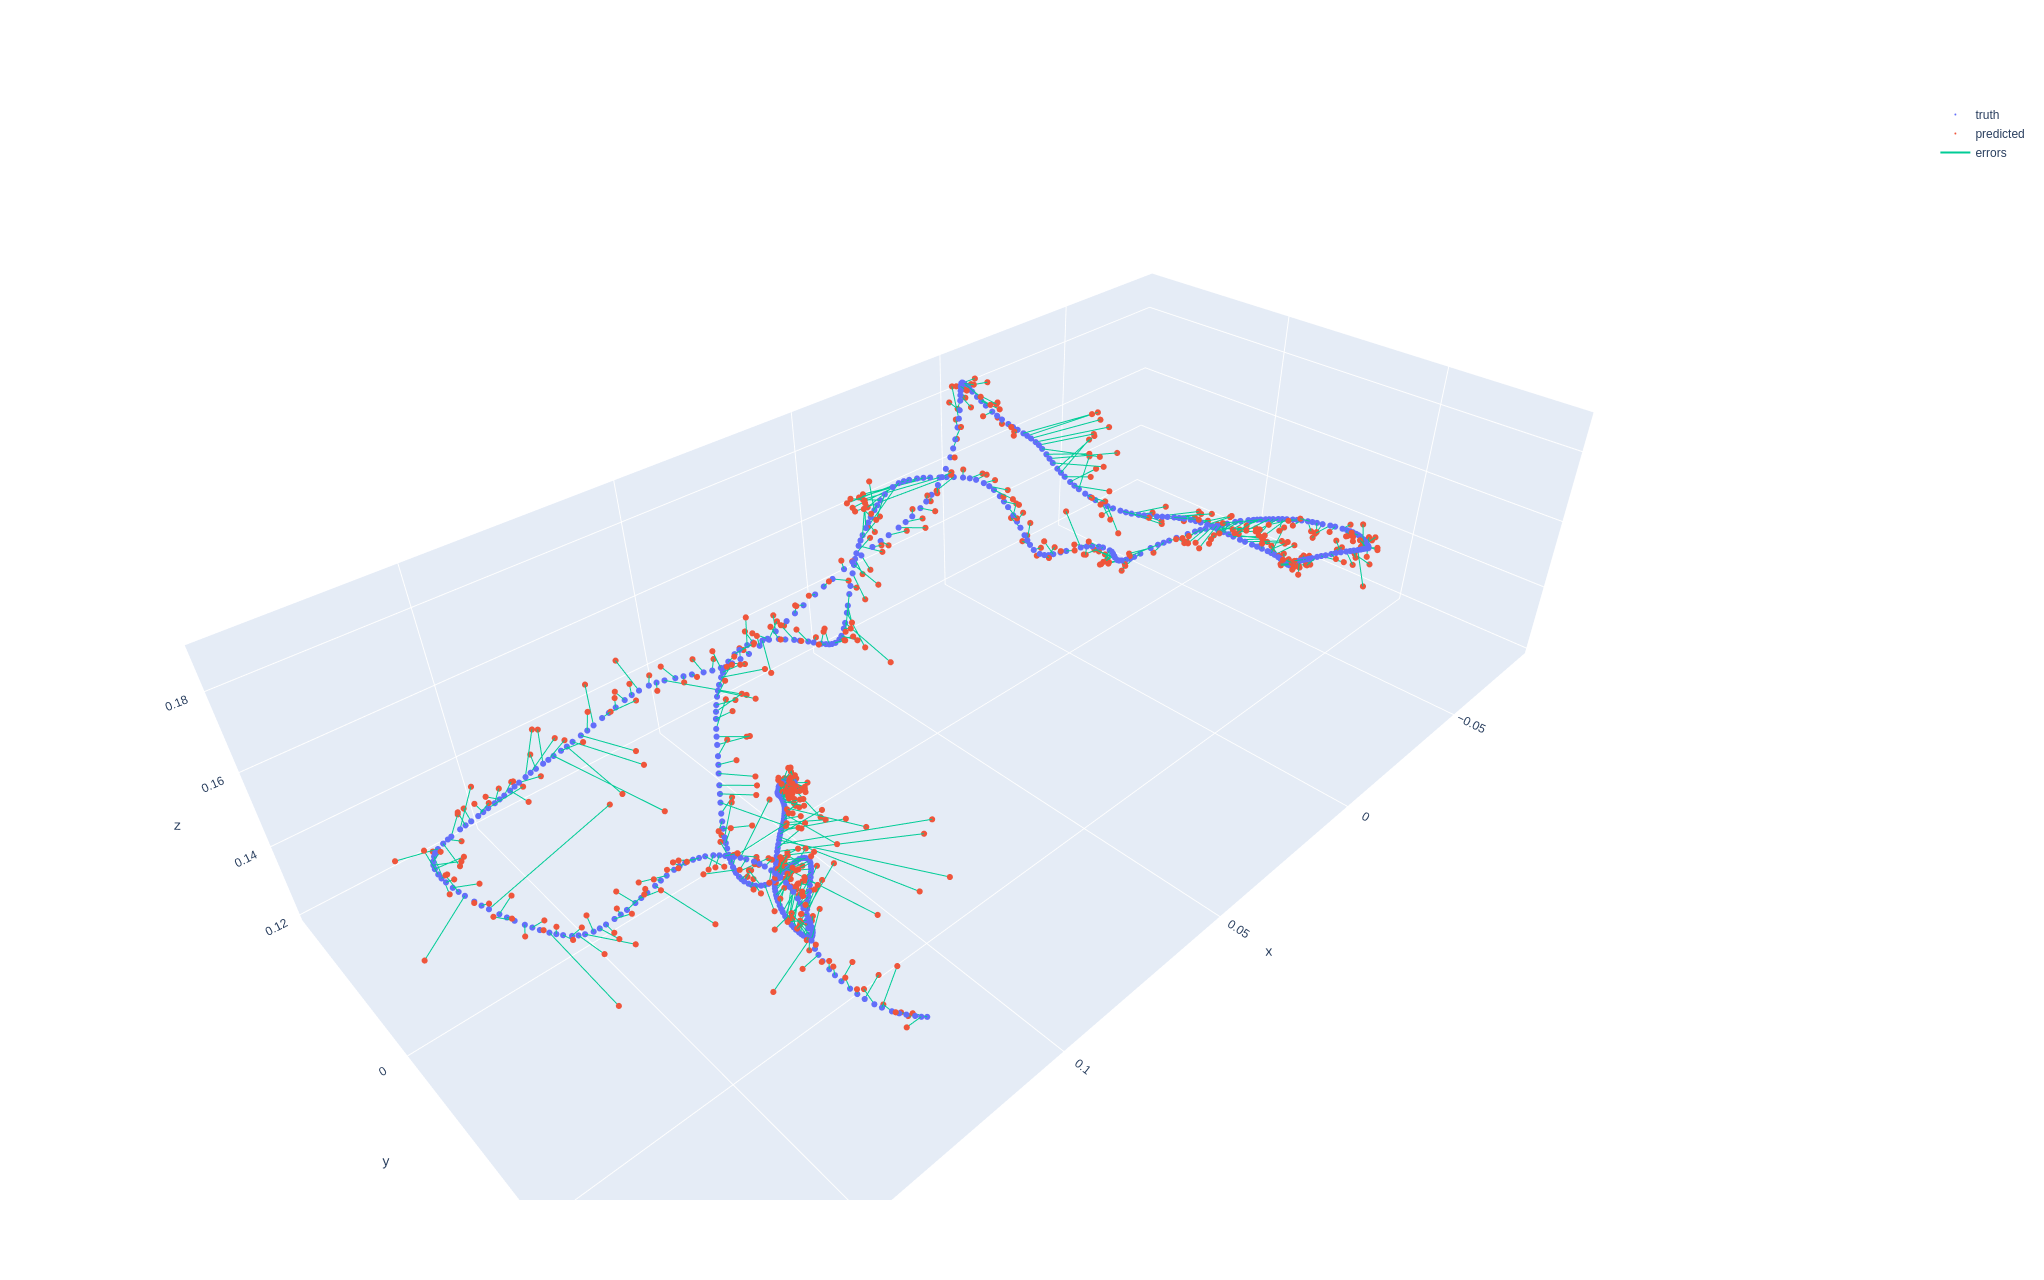

In [15]:
show_trajectories(np.array(gt_poses)[:, 3, :3], np.array(poses)[:, 3, :3])

In [72]:
poses[0]

array([[ 0.8735127 ,  0.48643783,  0.01880984,  0.        ],
       [ 0.34341863, -0.58838165, -0.73203176,  0.        ],
       [-0.3450206 ,  0.64589864, -0.6810106 ,  0.        ],
       [ 0.13191056,  0.08617777,  0.15277901,  1.        ]],
      dtype=float32)

In [73]:
gt_poses[0]

array([[ 0.8722986 ,  0.4882979 ,  0.02569568,  0.        ],
       [ 0.34789497, -0.58283824, -0.73434913,  0.        ],
       [-0.34360474,  0.64951116, -0.67828536,  0.        ],
       [ 1.3112    ,  0.8507    ,  1.5186    ,  1.        ]],
      dtype=float32)